# Entrainement de modèles de classification textuelle


<div style="display: inline; float: left">
  <img src="https://www.quinzaine-cineastes.fr/storage/wsm_medias/affiche_film_dydWPWEaJlbgbbcPWUN0wiJlpFJnoV14SEzK9f8t.jpeg?ncache=11" alt="img" width="200" align="right"/>
  <p style="float: left; font-size: 30px;">  
Nous allons voir aujourd'hui comment entrainer des classifieurs textuels, en utilisant des embeddings de mots pour représenter le contenu d'un texte, avec trois méthodes différentes:

1. A partir d'embeddings statiques
précalculés (type word2vec, glove).
2. Avec des embeddings entrainés de zéro en même temps que le modèle de classification.
3. Avec des modèles contextuels pré-entrainés (type Bert/GPT).

Nous prendrons comme exemple de tâches la classification de sentiments, avec le jeu de données IMDB https://huggingface.co/datasets/stanfordnlp/imdb
  </p>
</div>


Ce **TP sera à rendre sur moodle au plus tard le 25/11/2024**, les questions qui vous sont posées sont indiquées **en gras**.

**⛔ Vous devez compléter/ajouter du code et analyser vos résultats selon les différents réglages que vous avez essayés**

# 1. A partir d'embeddings statiques précalculés






On reprend en partie le TD sur les embeddings statiques

In [1]:
!pip install gensim

In [2]:
import gensim
from tqdm import tqdm

In [149]:
# small glove
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-100") #50, 100, 200, 300

In [150]:
vocabulary = model.key_to_index
#print(len(vocabulary))

In [151]:
import numpy as np
import string
punct_remove = str.maketrans('', '',string.punctuation)

In [152]:
# fonction d'encodage de phrase = moyenne des embeddings des mots (possible correction du TD)
def encode(sentence,model):
  vocabulary = set(model.key_to_index)
  words = sentence.lower().translate(punct_remove)
  words = words.split()
  vector = model[[word for word in words if word in vocabulary]].mean(axis=0)
  return vector


In [153]:
%timeit encode("This is a very short test.",model)

29.7 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Le jeu de données
En TD on avait regardé ce jeu de données
(paraphrases):

PAWS: Paraphrase Adversaries from Word Scrambling: https://huggingface.co/datasets/google-research-datasets/paws

On va cette fois considérer l'analyse de "sentiment", sur des critiques de films issus du site IMDB, car l'encodage des instances sera plus simple.

https://huggingface.co/datasets/stanfordnlp/imdb





In [8]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [9]:
from datasets import load_dataset
import pandas as pds

In [154]:
dataset_train, dataset_val, dataset_test = load_dataset("paws", "labeled_final", split=['train', 'validation', 'test'])

In [155]:
# on va seulement entrainer/tester sur une partie du train pour aller plus vite
ds = load_dataset("imdb",split="train")
# on ne touche pas au "vrai" test
ds = ds.train_test_split(train_size=0.04,test_size=0.02)
dataset_train = ds["train"]
dataset_test = ds["test"]

In [12]:
# regardez ce qui est contenu dans les instances
dataset_train[0]

{'text': 'I did not like Chandni Bar from the same director.<br /><br />I did not watch his other movies. They came and went.<br /><br />But Page-3 is nicely made. Seems real. Like Satya from RGV did.<br /><br />The mental sickness of the so called high society is the summary of the movie. In the midst of all the sickness, its difficult to lead a normal life which the protagonist, Konkana Sen, does. Serious movie, not to be watched with children or expecting wives. Page-3 of newspapers is the usual place for reporting the activities going on in the parties of the rich and elite who indulge in much more filth then what is reported. How this Page-3 is also a business prospect is shown in the movie. Event management firms get paid to arrange parties and make a rich but not famous people famous overnight by clicking photographs with the celebrities invited to the party.<br /><br />The western culture has crept into the high society of Mumabi quite deeply. The movie shows it boldly, no hold

## Encodage des données

Il faut maintenant encoder les instances du jeu de données pour avoir un ensemble de vecteurs des phrases, et les labels associés

**Ecrire la fonction suivante qui doit renvoyer 2 listes (ou vecteurs): 1) de vecteur des phrases 2) des labels correspondants**

In [156]:
# doit retourner une liste de vecteurs, et une liste de labels correspondants
def encode_train(instances,model):
  vectors = []
  labels = []
  for instance in tqdm(instances):
    vectors.append(encode(instance["text"],model))
    labels.append(instance["label"])
  return vectors, labels

In [157]:
X, y = encode_train(dataset_train,model)

100%|██████████| 1000/1000 [00:37<00:00, 26.82it/s]


## Entraînement d'un modèle simple

**Vous pouvez maintenant essayer d'entrainer un modèle simple de scikit-learn, par exemple une régression logistique ou un MLP simple, et les évaluer sur les sous-ensembles train et test**


https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html


https://scikit-learn.org/1.5/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

In [15]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00


In [158]:
# Entrainement
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# logistic regression
clf=LogisticRegression(max_iter=1000)
clf.fit(X,y)
print("accuracy train régression logistique:",clf.score(X,y))
# MLP
clf=MLPClassifier(hidden_layer_sizes=(300,),max_iter=1000)
clf.fit(X,y)
print("accuracy train MLP:",clf.score(X,y))

accuracy train régression logistique: 0.801
accuracy train MLP: 0.824


In [17]:
print(dataset_train[0])

{'text': 'I did not like Chandni Bar from the same director.<br /><br />I did not watch his other movies. They came and went.<br /><br />But Page-3 is nicely made. Seems real. Like Satya from RGV did.<br /><br />The mental sickness of the so called high society is the summary of the movie. In the midst of all the sickness, its difficult to lead a normal life which the protagonist, Konkana Sen, does. Serious movie, not to be watched with children or expecting wives. Page-3 of newspapers is the usual place for reporting the activities going on in the parties of the rich and elite who indulge in much more filth then what is reported. How this Page-3 is also a business prospect is shown in the movie. Event management firms get paid to arrange parties and make a rich but not famous people famous overnight by clicking photographs with the celebrities invited to the party.<br /><br />The western culture has crept into the high society of Mumabi quite deeply. The movie shows it boldly, no hold

In [18]:
print(dataset_val[0])  # Print the first instance to see its structure


{'id': 1, 'sentence1': 'Bradd Crellin represented BARLA Cumbria on a tour of Australia with 6 other players representing Britain , also on a tour of Australia .', 'sentence2': 'Bradd Crellin also represented BARLA Great Britain on a tour through Australia on a tour through Australia with 6 other players representing Cumbria .', 'label': 0}


In [159]:
X_val, y_val = encode_train(dataset_test,model)
y_predicted_val = clf.predict(X_val)

# Evaluate the model's performance on the validation set.
print("\n accuracy test MLP:",clf.score(X_val,y_val))

100%|██████████| 500/500 [00:17<00:00, 28.45it/s]


 accuracy test MLP: 0.8


# 2. Un modèle de classification neuronal à partir de zéro

On va maintenant développer des modèles en torch en commençant à zéro.

Le plus simple d'abord est de faire un modèle "feed forward" complètement connecté, en définissant directement une couche d'embedding qui sera appris par le modèle, et en transformant l'input en "embeddingbag" i.e. une moyenne des embeddings des mots de l'input.




In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [21]:
# sur colab, bien choisir un GPU/TPU dans le runtime ("Execution/modifier le type d'execution")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
device

'cpu'

In [22]:
# on transforme les données en tenseur torch, et on met sur le GPU
dataset_train = dataset_train.with_format("torch",device=device)
dataset_test = dataset_test.with_format("torch",device=device)

In [23]:
# on vérifier qu'on peut bien itérer sur le dataset
a = next(iter(dataset_train))
a["text"]

'I did not like Chandni Bar from the same director.<br /><br />I did not watch his other movies. They came and went.<br /><br />But Page-3 is nicely made. Seems real. Like Satya from RGV did.<br /><br />The mental sickness of the so called high society is the summary of the movie. In the midst of all the sickness, its difficult to lead a normal life which the protagonist, Konkana Sen, does. Serious movie, not to be watched with children or expecting wives. Page-3 of newspapers is the usual place for reporting the activities going on in the parties of the rich and elite who indulge in much more filth then what is reported. How this Page-3 is also a business prospect is shown in the movie. Event management firms get paid to arrange parties and make a rich but not famous people famous overnight by clicking photographs with the celebrities invited to the party.<br /><br />The western culture has crept into the high society of Mumabi quite deeply. The movie shows it boldly, no holds barred.

Si on prend comme éléments d'entrée les mots, on risque d'avoir un vocabulaire trop grand, deux stratégies possibles sont:

 - prendre seulement les mots les plus fréquents et enlever les autres ou les remplacer par un mot spécial ("unknown" par exemple)
 - tokeniser en sous-chaines courantes

 Ici on va utiliser la 2e solution, qui est la plus courante actuellement, avec le vocabulaire et le tokenizer d'un modèle existant

In [24]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
vocab_size = tokenizer.vocab_size
print(vocab_size)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

28996


In [25]:
# on pré-tokenize tout pour être prêt à fournir au modèle
# comme on a des séquences de textes de longueurs différentes, il faut décider comment on les aligne pour avoir les inputs tous de même taille.
# ici on décide de faire du "padding", ajouter des 0 à toutes les séquences jusqu'à la longueur de la plus longue séquence.
encoded_train = dataset_train.map(lambda examples: tokenizer(examples['text'],padding='longest'), batched=True)
encoded_test = dataset_test.map(lambda examples: tokenizer(examples['text'],padding='longest'), batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1531 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [26]:
# on peut voir que le tokenizer a encodé la séquence avec les ids des tokens, et créé un "masque" qui permet de récupérer après coup la partie utile de chaque séquence
encoded_train[0]

{'text': 'I did not like Chandni Bar from the same director.<br /><br />I did not watch his other movies. They came and went.<br /><br />But Page-3 is nicely made. Seems real. Like Satya from RGV did.<br /><br />The mental sickness of the so called high society is the summary of the movie. In the midst of all the sickness, its difficult to lead a normal life which the protagonist, Konkana Sen, does. Serious movie, not to be watched with children or expecting wives. Page-3 of newspapers is the usual place for reporting the activities going on in the parties of the rich and elite who indulge in much more filth then what is reported. How this Page-3 is also a business prospect is shown in the movie. Event management firms get paid to arrange parties and make a rich but not famous people famous overnight by clicking photographs with the celebrities invited to the party.<br /><br />The western culture has crept into the high society of Mumabi quite deeply. The movie shows it boldly, no hold

## Modèle simple feed-forward 1 couche


**Ecrire un modèle feed-forward avec juste une couche d'embedding + une couche intermédiaire + une couche de sortie**

Utilisez le module de torch nn.EmbeddingBag pour encoder la phrase


In [27]:
import torch
import torch.nn as nn

class FF_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(FF_Model, self).__init__()

        # Embedding layer using EmbeddingBag for sentence-level embeddings
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)

        # Linear function ==> W1 (hidden layer)
        self.w1 = nn.Linear(embed_dim, hidden_dim)

        # Non-linearity ==> ReLU activation function
        self.sigmoid = nn.Sigmoid()

        # Linear function (output layer)
        self.w2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        # Pass through the embedding layer (text is tokenized)
        embedded = self.embedding(text)

        # Pass through W1 (hidden layer)
        hidden = self.w1(embedded)

        # Apply ReLU activation
        hidden = self.sigmoid(hidden)

        # Pass through W2 (output layer)
        out = self.w2(hidden)


        return out


Les modèles sont généralement entrainés avec des exemples regroupés en paquets ("batch") ce qui rend l'entrainement plus stable que si on met à jour le modèle après chaque instance.
Ici on utilise l'objet DataLoader fourni par la librairie torch, qui gère automatiquement la génération des batchs.

In [28]:
dataloader_train = DataLoader(encoded_train, batch_size=4)
dataloader_test = DataLoader(encoded_test, batch_size=4)

In [29]:
# on peut vérifier qu'on peut itérer sur un batch et regarder son contenu
a = next(iter(dataloader_train))
a.keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

Voici un exemple possible de boucle classique d'entrainement de base en torch, et une fonction d'éaluation des prédictions sur le test.

**Complétez la partie avant le "step 1 dans l'entrainement, et adaptez aussi la fonction d'evaluation**

In [30]:
def training(model, train_loader, optimizer, scheduler=None, num_epochs=5, device="cpu"):
    acc_dots = []
    loss_dots = []
    for epoch in tqdm(range(num_epochs), desc="epoch", position=0):
        train_loss, total_acc, total_count = 0, 0, 0
        for batch in tqdm(train_loader, desc="batch", position=1, leave=False):
            # Extract inputs and labels from the batch
            inpt = batch['input_ids']
            label = batch['label']
            # Move tensors to the appropriate device (e.g., CUDA or CPU)
            inpt, label = inpt.to(device), label.to(device)


            # Move tensors to the appropriate device (e.g., CUDA)
            inpt, label = inpt.to(device), label.to(device)

            # Step 1: Clearing the accumulated gradients
            model.zero_grad()

            # Step 2: Forward pass to get output/logits
            output = model(inpt)

            # Step 3: Compute the loss and update the parameters by calling optimizer.step()
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, label)

            # Step 4: Backward pass (getting gradients)
            loss.backward()

            # Step 5: Updating parameters
            optimizer.step()

            # Accumulating the loss and accuracy over time
            train_loss += loss.item()
            total_count += label.size(0)
            _, predicted = torch.max(output, 1)
            total_acc += (predicted == label).sum().item()

        # Compute accuracy on the train set at each epoch
        print(f'Epoch: {epoch}. Loss: {train_loss/len(train_loader)}. Accuracy: {total_acc/total_count}')
        acc_dots.append(total_acc / total_count)
        loss_dots.append(train_loss / len(train_loader))

        if scheduler:
            scheduler.step()

    return acc_dots, loss_dots


In [31]:
def evaluate_model( model, dev_loader ):
    predictions = []
    gold = []
    total_predictions = correct_predictions = 0
    with torch.no_grad():
        for batch in tqdm(dev_loader):
          label = batch["label"]
          input = batch["input_ids"]
          input, label = input.to(device), label.to(device)

          output = model(input)
          _, predicted = torch.max(output, 1)
          for element in predicted:
            predictions.append(element)
          for element in label:
            gold.append(element)
          total_predictions += label.size(0)
          correct_predictions += (predicted == label).sum().item()

    conf_mat = [[0, 0], [0, 0]]
    for k in range(total_predictions):
      j = abs(gold[k] - 1)
      i = abs(predictions[k] - 1)
      conf_mat[i][j] += 1

    TP = conf_mat[0][0]
    FP = conf_mat[0][1]
    FN = conf_mat[1][0]
    TN = conf_mat[1][1]
    accuracy = correct_predictions/total_predictions
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * (precision*recall)/(precision+recall)

    print("Accuracy: {}\nPrecision: {}\nRecall: {}\nF1: {}".format(accuracy, precision, recall, F1))
    return gold, predictions

In [32]:
from sklearn.model_selection import ParameterGrid
import torch

def grid_search(model_class, param_grid, train_loader, device="cpu"):
    best_accuracy = 0
    best_params = None
    best_acc_dots = None
    best_loss_dots = None

    # Create the parameter grid (cross product of all hyperparameters)
    grid = ParameterGrid(param_grid)

    for params in grid:
        print(f"\nTrying combination: {params}")

        # Initialize model with the current hyperparameters
        model_copy = model_class(vocab_size, embed_dim=params['embed_dim'],
                                 hidden_dim=params['hidden_dim'], output_dim=2)
        model_copy.to(device)

        # Set hyperparameters for this trial
        learning_rate = params['lr']
        num_epochs = params['epochs']
        batch_size = params['batch_size']

        # Create the optimizer with the selected learning rate
        optimizer = torch.optim.AdamW(model_copy.parameters(), lr=learning_rate)

        # Create DataLoader with the selected batch size
        dataloader_train = DataLoader(encoded_train, batch_size=batch_size)
        dataloader_test = DataLoader(encoded_test, batch_size=batch_size)

        # Train the model
        accs, loss = training(model_copy, dataloader_train, optimizer, num_epochs=num_epochs, device=device)

        # Find the best accuracy
        final_accuracy = accs[-1]  # Last epoch accuracy

        if final_accuracy > best_accuracy:
            best_accuracy = final_accuracy
            best_params = params
            best_acc_dots = accs
            best_loss_dots = loss

    print(f"\nBest Hyperparameters: {best_params}")
    print(f"Best Accuracy: {best_accuracy}")

    return best_params, best_accuracy, best_acc_dots, best_loss_dots

# Example of parameter grid for grid search
param_grid = {
    'lr': [0.001, 0.002, 0.005],
    'epochs': [5, 10, 20],
    'batch_size': [8, 16],
    'embed_dim': [100, 200],
    'hidden_dim': [50, 100, 150]
}

# Train the model with grid search
device = 'cuda'  # Or 'cpu' if you're using CPU
best_params, best_accuracy, best_acc_dots, best_loss_dots = grid_search(FF_Model, param_grid, dataloader_train, device)



Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 50, 'lr': 0.001}


epoch:  20%|██        | 1/5 [00:01<00:04,  1.23s/it]

Epoch: 0. Loss: 0.6987044539451599. Accuracy: 0.506



epoch:  40%|████      | 2/5 [00:01<00:02,  1.25it/s]

Epoch: 1. Loss: 0.7000677723884583. Accuracy: 0.496



epoch:  60%|██████    | 3/5 [00:02<00:01,  1.49it/s]

Epoch: 2. Loss: 0.6983967847824096. Accuracy: 0.506



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.55it/s]

Epoch: 3. Loss: 0.6969430866241455. Accuracy: 0.516



epoch: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch: 4. Loss: 0.6954612631797791. Accuracy: 0.528

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 50, 'lr': 0.002}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.58it/s]

Epoch: 0. Loss: 0.7001255984306336. Accuracy: 0.522



epoch:  40%|████      | 2/5 [00:01<00:02,  1.49it/s]

Epoch: 1. Loss: 0.7000689988136292. Accuracy: 0.51



epoch:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

Epoch: 2. Loss: 0.696368260383606. Accuracy: 0.516



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.67it/s]

Epoch: 3. Loss: 0.6941945543289184. Accuracy: 0.523



epoch: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch: 4. Loss: 0.6919715332984925. Accuracy: 0.541

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 50, 'lr': 0.005}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.84it/s]

Epoch: 0. Loss: 0.7015971598625184. Accuracy: 0.525



epoch:  40%|████      | 2/5 [00:01<00:01,  1.95it/s]

Epoch: 1. Loss: 0.7001536288261414. Accuracy: 0.505



epoch:  60%|██████    | 3/5 [00:01<00:01,  1.94it/s]

Epoch: 2. Loss: 0.6960283799171447. Accuracy: 0.523



epoch:  80%|████████  | 4/5 [00:02<00:00,  2.00it/s]

Epoch: 3. Loss: 0.6818836882114411. Accuracy: 0.539



epoch: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch: 4. Loss: 0.5398980069160462. Accuracy: 0.738

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 100, 'lr': 0.001}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.05it/s]

Epoch: 0. Loss: 0.7008257541656494. Accuracy: 0.506



epoch:  40%|████      | 2/5 [00:01<00:01,  1.96it/s]

Epoch: 1. Loss: 0.701212767124176. Accuracy: 0.515



epoch:  60%|██████    | 3/5 [00:01<00:01,  1.99it/s]

Epoch: 2. Loss: 0.6998658437728882. Accuracy: 0.504



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.96it/s]

Epoch: 3. Loss: 0.698115427017212. Accuracy: 0.514



epoch: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch: 4. Loss: 0.6960105948448181. Accuracy: 0.528

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 100, 'lr': 0.002}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.93it/s]

Epoch: 0. Loss: 0.6998116846084594. Accuracy: 0.52



epoch:  40%|████      | 2/5 [00:01<00:01,  2.01it/s]

Epoch: 1. Loss: 0.6985149722099304. Accuracy: 0.532



epoch:  60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

Epoch: 2. Loss: 0.6994863786697387. Accuracy: 0.52



epoch:  80%|████████  | 4/5 [00:02<00:00,  2.01it/s]

Epoch: 3. Loss: 0.6959313769340515. Accuracy: 0.529



epoch: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch: 4. Loss: 0.6916948776245118. Accuracy: 0.547

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 100, 'lr': 0.005}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.07it/s]

Epoch: 0. Loss: 0.7062557511329651. Accuracy: 0.526



epoch:  40%|████      | 2/5 [00:01<00:01,  1.97it/s]

Epoch: 1. Loss: 0.699095064163208. Accuracy: 0.494



epoch:  60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

Epoch: 2. Loss: 0.695803792476654. Accuracy: 0.512



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.72it/s]

Epoch: 3. Loss: 0.6913666648864746. Accuracy: 0.52



epoch: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 4. Loss: 0.6638124823570252. Accuracy: 0.58

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 150, 'lr': 0.001}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.45it/s]

Epoch: 0. Loss: 0.6986948313713074. Accuracy: 0.512



epoch:  40%|████      | 2/5 [00:01<00:01,  1.53it/s]

Epoch: 1. Loss: 0.7001198267936707. Accuracy: 0.522



epoch:  60%|██████    | 3/5 [00:01<00:01,  1.70it/s]

Epoch: 2. Loss: 0.7003230519294739. Accuracy: 0.513



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.80it/s]

Epoch: 3. Loss: 0.6991137971878052. Accuracy: 0.526



epoch: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 4. Loss: 0.6964142723083496. Accuracy: 0.531

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 150, 'lr': 0.002}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.00it/s]

Epoch: 0. Loss: 0.7002381095886231. Accuracy: 0.528



epoch:  40%|████      | 2/5 [00:01<00:01,  1.95it/s]

Epoch: 1. Loss: 0.6963462295532227. Accuracy: 0.533



epoch:  60%|██████    | 3/5 [00:01<00:01,  1.97it/s]

Epoch: 2. Loss: 0.6949163498878479. Accuracy: 0.532



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.96it/s]

Epoch: 3. Loss: 0.6934713311195374. Accuracy: 0.529



epoch: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch: 4. Loss: 0.6891218023300171. Accuracy: 0.539

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 150, 'lr': 0.005}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.94it/s]

Epoch: 0. Loss: 0.7072202060222625. Accuracy: 0.529



epoch:  40%|████      | 2/5 [00:01<00:01,  1.97it/s]

Epoch: 1. Loss: 0.6978515787124634. Accuracy: 0.518



epoch:  60%|██████    | 3/5 [00:01<00:01,  1.96it/s]

Epoch: 2. Loss: 0.694129656791687. Accuracy: 0.517



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.96it/s]

Epoch: 3. Loss: 0.6907551646232605. Accuracy: 0.514



epoch: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch: 4. Loss: 0.6601582934856415. Accuracy: 0.582

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 50, 'lr': 0.001}


epoch:  10%|█         | 1/10 [00:00<00:04,  2.03it/s]

Epoch: 0. Loss: 0.6985486388206482. Accuracy: 0.506



epoch:  20%|██        | 2/10 [00:01<00:04,  1.95it/s]

Epoch: 1. Loss: 0.6999742889404297. Accuracy: 0.497



epoch:  30%|███       | 3/10 [00:01<00:03,  1.97it/s]

Epoch: 2. Loss: 0.6981740927696228. Accuracy: 0.512



epoch:  40%|████      | 4/10 [00:02<00:03,  1.95it/s]

Epoch: 3. Loss: 0.6967151942253113. Accuracy: 0.517



epoch:  50%|█████     | 5/10 [00:02<00:02,  1.96it/s]

Epoch: 4. Loss: 0.6953926405906677. Accuracy: 0.524



epoch:  60%|██████    | 6/10 [00:03<00:02,  1.93it/s]

Epoch: 5. Loss: 0.6940470037460327. Accuracy: 0.531



epoch:  70%|███████   | 7/10 [00:03<00:01,  1.81it/s]

Epoch: 6. Loss: 0.6925217633247376. Accuracy: 0.543



epoch:  80%|████████  | 8/10 [00:04<00:01,  1.79it/s]

Epoch: 7. Loss: 0.6906424627304077. Accuracy: 0.548



epoch:  90%|█████████ | 9/10 [00:04<00:00,  1.73it/s]

Epoch: 8. Loss: 0.6881582145690918. Accuracy: 0.563



epoch: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch: 9. Loss: 0.6846437101364136. Accuracy: 0.58

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 50, 'lr': 0.002}


epoch:  10%|█         | 1/10 [00:00<00:05,  1.67it/s]

Epoch: 0. Loss: 0.7028144292831421. Accuracy: 0.512



epoch:  20%|██        | 2/10 [00:01<00:04,  1.75it/s]

Epoch: 1. Loss: 0.699623345375061. Accuracy: 0.516



epoch:  30%|███       | 3/10 [00:01<00:03,  1.87it/s]

Epoch: 2. Loss: 0.6962885494232178. Accuracy: 0.54



epoch:  40%|████      | 4/10 [00:02<00:03,  1.88it/s]

Epoch: 3. Loss: 0.6930031871795654. Accuracy: 0.54



epoch:  50%|█████     | 5/10 [00:02<00:02,  1.93it/s]

Epoch: 4. Loss: 0.6877738423347474. Accuracy: 0.564



epoch:  60%|██████    | 6/10 [00:03<00:02,  1.91it/s]

Epoch: 5. Loss: 0.6729302058219909. Accuracy: 0.591



epoch:  70%|███████   | 7/10 [00:03<00:01,  1.94it/s]

Epoch: 6. Loss: 0.6144393684864045. Accuracy: 0.667



epoch:  80%|████████  | 8/10 [00:04<00:01,  1.89it/s]

Epoch: 7. Loss: 0.46293770480155944. Accuracy: 0.822



epoch:  90%|█████████ | 9/10 [00:04<00:00,  1.93it/s]

Epoch: 8. Loss: 0.32863477075099945. Accuracy: 0.895



epoch: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch: 9. Loss: 0.22977146834135057. Accuracy: 0.939

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 50, 'lr': 0.005}


epoch:  10%|█         | 1/10 [00:00<00:04,  2.04it/s]

Epoch: 0. Loss: 0.6983636498451233. Accuracy: 0.531



epoch:  20%|██        | 2/10 [00:01<00:04,  1.95it/s]

Epoch: 1. Loss: 0.6988943004608155. Accuracy: 0.521



epoch:  30%|███       | 3/10 [00:01<00:03,  1.96it/s]

Epoch: 2. Loss: 0.6936783485412598. Accuracy: 0.525



epoch:  40%|████      | 4/10 [00:02<00:03,  1.92it/s]

Epoch: 3. Loss: 0.6704076595306396. Accuracy: 0.564



epoch:  50%|█████     | 5/10 [00:02<00:02,  1.95it/s]

Epoch: 4. Loss: 0.4708521665334702. Accuracy: 0.791



epoch:  60%|██████    | 6/10 [00:03<00:02,  1.91it/s]

Epoch: 5. Loss: 0.24552656507492066. Accuracy: 0.906



epoch:  70%|███████   | 7/10 [00:03<00:01,  1.96it/s]

Epoch: 6. Loss: 0.1299016944691539. Accuracy: 0.959



epoch:  80%|████████  | 8/10 [00:04<00:01,  1.92it/s]

Epoch: 7. Loss: 0.07077977235242724. Accuracy: 0.984



epoch:  90%|█████████ | 9/10 [00:04<00:00,  1.96it/s]

Epoch: 8. Loss: 0.04230957609415054. Accuracy: 0.988



epoch: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch: 9. Loss: 0.03356812525494024. Accuracy: 0.993

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 100, 'lr': 0.001}


epoch:  10%|█         | 1/10 [00:00<00:05,  1.68it/s]

Epoch: 0. Loss: 0.6984851665496826. Accuracy: 0.511



epoch:  20%|██        | 2/10 [00:01<00:04,  1.67it/s]

Epoch: 1. Loss: 0.7017337336540223. Accuracy: 0.513



epoch:  30%|███       | 3/10 [00:01<00:04,  1.62it/s]

Epoch: 2. Loss: 0.7004804363250733. Accuracy: 0.509



epoch:  40%|████      | 4/10 [00:02<00:03,  1.59it/s]

Epoch: 3. Loss: 0.6986535539627076. Accuracy: 0.516



epoch:  50%|█████     | 5/10 [00:03<00:03,  1.56it/s]

Epoch: 4. Loss: 0.696850486278534. Accuracy: 0.525



epoch:  60%|██████    | 6/10 [00:03<00:02,  1.66it/s]

Epoch: 5. Loss: 0.694966851234436. Accuracy: 0.531



epoch:  70%|███████   | 7/10 [00:04<00:01,  1.76it/s]

Epoch: 6. Loss: 0.6927645320892334. Accuracy: 0.542



epoch:  80%|████████  | 8/10 [00:04<00:01,  1.79it/s]

Epoch: 7. Loss: 0.6899135293960571. Accuracy: 0.552



epoch:  90%|█████████ | 9/10 [00:05<00:00,  1.85it/s]

Epoch: 8. Loss: 0.6858459410667419. Accuracy: 0.579



epoch: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch: 9. Loss: 0.6794449763298035. Accuracy: 0.588

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 100, 'lr': 0.002}


epoch:  10%|█         | 1/10 [00:00<00:04,  2.02it/s]

Epoch: 0. Loss: 0.6982415695190429. Accuracy: 0.529



epoch:  20%|██        | 2/10 [00:01<00:04,  1.94it/s]

Epoch: 1. Loss: 0.6972483620643616. Accuracy: 0.527



epoch:  30%|███       | 3/10 [00:01<00:03,  1.96it/s]

Epoch: 2. Loss: 0.6985450000762939. Accuracy: 0.515



epoch:  40%|████      | 4/10 [00:02<00:03,  1.90it/s]

Epoch: 3. Loss: 0.6962001852989197. Accuracy: 0.523



epoch:  50%|█████     | 5/10 [00:02<00:02,  1.94it/s]

Epoch: 4. Loss: 0.6904217147827149. Accuracy: 0.553



epoch:  60%|██████    | 6/10 [00:03<00:02,  1.92it/s]

Epoch: 5. Loss: 0.6800390949249268. Accuracy: 0.576



epoch:  70%|███████   | 7/10 [00:03<00:01,  1.95it/s]

Epoch: 6. Loss: 0.6490996837615967. Accuracy: 0.609



epoch:  80%|████████  | 8/10 [00:04<00:01,  1.92it/s]

Epoch: 7. Loss: 0.5254958550930023. Accuracy: 0.77



epoch:  90%|█████████ | 9/10 [00:04<00:00,  1.95it/s]

Epoch: 8. Loss: 0.3711088738441467. Accuracy: 0.866



epoch: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch: 9. Loss: 0.25128453719615934. Accuracy: 0.935

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 100, 'lr': 0.005}


epoch:  10%|█         | 1/10 [00:00<00:04,  1.97it/s]

Epoch: 0. Loss: 0.7040419914722442. Accuracy: 0.524



epoch:  20%|██        | 2/10 [00:01<00:04,  1.93it/s]

Epoch: 1. Loss: 0.6977223625183105. Accuracy: 0.518



epoch:  30%|███       | 3/10 [00:01<00:03,  1.95it/s]

Epoch: 2. Loss: 0.6974333143234253. Accuracy: 0.506



epoch:  40%|████      | 4/10 [00:02<00:03,  1.91it/s]

Epoch: 3. Loss: 0.6821203181743621. Accuracy: 0.554



epoch:  50%|█████     | 5/10 [00:02<00:02,  1.75it/s]

Epoch: 4. Loss: 0.5369956396818161. Accuracy: 0.715



epoch:  60%|██████    | 6/10 [00:03<00:02,  1.72it/s]

Epoch: 5. Loss: 0.32404614359140393. Accuracy: 0.86



epoch:  70%|███████   | 7/10 [00:04<00:01,  1.62it/s]

Epoch: 6. Loss: 0.17926889824867248. Accuracy: 0.925



epoch:  80%|████████  | 8/10 [00:04<00:01,  1.55it/s]

Epoch: 7. Loss: 0.10755539203435183. Accuracy: 0.963



epoch:  90%|█████████ | 9/10 [00:05<00:00,  1.62it/s]

Epoch: 8. Loss: 0.06796583917737008. Accuracy: 0.978



epoch: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch: 9. Loss: 0.036438098752405494. Accuracy: 0.989

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 150, 'lr': 0.001}


epoch:  10%|█         | 1/10 [00:00<00:04,  1.98it/s]

Epoch: 0. Loss: 0.6990721569061279. Accuracy: 0.516



epoch:  20%|██        | 2/10 [00:01<00:04,  1.91it/s]

Epoch: 1. Loss: 0.7004144716262818. Accuracy: 0.521



epoch:  30%|███       | 3/10 [00:01<00:03,  1.94it/s]

Epoch: 2. Loss: 0.7009098515510559. Accuracy: 0.516



epoch:  40%|████      | 4/10 [00:02<00:03,  1.91it/s]

Epoch: 3. Loss: 0.6999426131248474. Accuracy: 0.518



epoch:  50%|█████     | 5/10 [00:02<00:02,  1.93it/s]

Epoch: 4. Loss: 0.6979400734901429. Accuracy: 0.511



epoch:  60%|██████    | 6/10 [00:03<00:02,  1.90it/s]

Epoch: 5. Loss: 0.695550286769867. Accuracy: 0.527



epoch:  70%|███████   | 7/10 [00:03<00:01,  1.89it/s]

Epoch: 6. Loss: 0.6927800822257996. Accuracy: 0.538



epoch:  80%|████████  | 8/10 [00:04<00:01,  1.90it/s]

Epoch: 7. Loss: 0.6892597932815552. Accuracy: 0.555



epoch:  90%|█████████ | 9/10 [00:04<00:00,  1.90it/s]

Epoch: 8. Loss: 0.6842642850875854. Accuracy: 0.57



epoch: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch: 9. Loss: 0.6762779903411865. Accuracy: 0.59

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 150, 'lr': 0.002}


epoch:  10%|█         | 1/10 [00:00<00:04,  1.84it/s]

Epoch: 0. Loss: 0.7000706992149353. Accuracy: 0.528



epoch:  20%|██        | 2/10 [00:01<00:04,  1.91it/s]

Epoch: 1. Loss: 0.6963044629096985. Accuracy: 0.528



epoch:  30%|███       | 3/10 [00:01<00:03,  1.84it/s]

Epoch: 2. Loss: 0.6969169096946717. Accuracy: 0.53



epoch:  40%|████      | 4/10 [00:02<00:03,  1.90it/s]

Epoch: 3. Loss: 0.696604510307312. Accuracy: 0.522



epoch:  50%|█████     | 5/10 [00:02<00:02,  1.86it/s]

Epoch: 4. Loss: 0.6914473395347596. Accuracy: 0.545



epoch:  60%|██████    | 6/10 [00:03<00:02,  1.88it/s]

Epoch: 5. Loss: 0.6836914038658142. Accuracy: 0.553



epoch:  70%|███████   | 7/10 [00:03<00:01,  1.88it/s]

Epoch: 6. Loss: 0.6586967694759369. Accuracy: 0.59



epoch:  80%|████████  | 8/10 [00:04<00:01,  1.78it/s]

Epoch: 7. Loss: 0.5431710357666015. Accuracy: 0.744



epoch:  90%|█████████ | 9/10 [00:04<00:00,  1.75it/s]

Epoch: 8. Loss: 0.3988953527212143. Accuracy: 0.844



epoch: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch: 9. Loss: 0.28376451593637464. Accuracy: 0.915

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 150, 'lr': 0.005}


epoch:  10%|█         | 1/10 [00:00<00:05,  1.56it/s]

Epoch: 0. Loss: 0.7083907818794251. Accuracy: 0.529



epoch:  20%|██        | 2/10 [00:01<00:05,  1.57it/s]

Epoch: 1. Loss: 0.6979580669403076. Accuracy: 0.516



epoch:  30%|███       | 3/10 [00:01<00:04,  1.60it/s]

Epoch: 2. Loss: 0.6960778594017029. Accuracy: 0.514



epoch:  40%|████      | 4/10 [00:02<00:03,  1.72it/s]

Epoch: 3. Loss: 0.6914765100479126. Accuracy: 0.525



epoch:  50%|█████     | 5/10 [00:02<00:02,  1.77it/s]

Epoch: 4. Loss: 0.6709096837043762. Accuracy: 0.564



epoch:  60%|██████    | 6/10 [00:03<00:02,  1.85it/s]

Epoch: 5. Loss: 0.5202183245420456. Accuracy: 0.73



epoch:  70%|███████   | 7/10 [00:03<00:01,  1.86it/s]

Epoch: 6. Loss: 0.27595143562555313. Accuracy: 0.886



epoch:  80%|████████  | 8/10 [00:04<00:01,  1.90it/s]

Epoch: 7. Loss: 0.17349724380671977. Accuracy: 0.939



epoch:  90%|█████████ | 9/10 [00:05<00:00,  1.88it/s]

Epoch: 8. Loss: 0.08005522315762938. Accuracy: 0.98



epoch: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch: 9. Loss: 0.052471733150538054. Accuracy: 0.988

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.001}


epoch:   5%|▌         | 1/20 [00:00<00:10,  1.85it/s]

Epoch: 0. Loss: 0.7001162085533142. Accuracy: 0.509



epoch:  10%|█         | 2/20 [00:01<00:09,  1.94it/s]

Epoch: 1. Loss: 0.6978430390357971. Accuracy: 0.517



epoch:  15%|█▌        | 3/20 [00:01<00:08,  1.90it/s]

Epoch: 2. Loss: 0.6966908564567565. Accuracy: 0.525



epoch:  20%|██        | 4/20 [00:02<00:08,  1.92it/s]

Epoch: 3. Loss: 0.6956131992340088. Accuracy: 0.52



epoch:  25%|██▌       | 5/20 [00:02<00:07,  1.88it/s]

Epoch: 4. Loss: 0.6944862265586853. Accuracy: 0.531



epoch:  30%|███       | 6/20 [00:03<00:07,  1.90it/s]

Epoch: 5. Loss: 0.6931850304603576. Accuracy: 0.538



epoch:  35%|███▌      | 7/20 [00:03<00:06,  1.89it/s]

Epoch: 6. Loss: 0.6915679812431336. Accuracy: 0.544



epoch:  40%|████      | 8/20 [00:04<00:06,  1.86it/s]

Epoch: 7. Loss: 0.6894308834075927. Accuracy: 0.557



epoch:  45%|████▌     | 9/20 [00:04<00:05,  1.89it/s]

Epoch: 8. Loss: 0.686427562713623. Accuracy: 0.572



epoch:  50%|█████     | 10/20 [00:05<00:05,  1.90it/s]

Epoch: 9. Loss: 0.6818798570632935. Accuracy: 0.591



epoch:  55%|█████▌    | 11/20 [00:05<00:04,  1.93it/s]

Epoch: 10. Loss: 0.6736903667449952. Accuracy: 0.611



epoch:  60%|██████    | 12/20 [00:06<00:04,  1.83it/s]

Epoch: 11. Loss: 0.6569635286331177. Accuracy: 0.638



epoch:  65%|██████▌   | 13/20 [00:06<00:03,  1.78it/s]

Epoch: 12. Loss: 0.6242581505775452. Accuracy: 0.664



epoch:  70%|███████   | 14/20 [00:07<00:03,  1.68it/s]

Epoch: 13. Loss: 0.5669212357997895. Accuracy: 0.742



epoch:  75%|███████▌  | 15/20 [00:08<00:03,  1.60it/s]

Epoch: 14. Loss: 0.4905528695583343. Accuracy: 0.827



epoch:  80%|████████  | 16/20 [00:08<00:02,  1.60it/s]

Epoch: 15. Loss: 0.41549599945545196. Accuracy: 0.882



epoch:  85%|████████▌ | 17/20 [00:09<00:01,  1.64it/s]

Epoch: 16. Loss: 0.34972533118724825. Accuracy: 0.913



epoch:  90%|█████████ | 18/20 [00:10<00:01,  1.73it/s]

Epoch: 17. Loss: 0.2944752378463745. Accuracy: 0.931



epoch:  95%|█████████▌| 19/20 [00:11<00:00,  1.22it/s]

Epoch: 18. Loss: 0.2488637712597847. Accuracy: 0.954



epoch: 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Epoch: 19. Loss: 0.21148624056577683. Accuracy: 0.963

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.002}


epoch:   5%|▌         | 1/20 [00:00<00:16,  1.17it/s]

Epoch: 0. Loss: 0.7000552473068238. Accuracy: 0.509



epoch:  10%|█         | 2/20 [00:02<00:20,  1.14s/it]

Epoch: 1. Loss: 0.7001006584167481. Accuracy: 0.518



epoch:  15%|█▌        | 3/20 [00:02<00:14,  1.15it/s]

Epoch: 2. Loss: 0.6967201972007752. Accuracy: 0.522



epoch:  20%|██        | 4/20 [00:03<00:11,  1.38it/s]

Epoch: 3. Loss: 0.6943692626953125. Accuracy: 0.531



epoch:  25%|██▌       | 5/20 [00:03<00:09,  1.51it/s]

Epoch: 4. Loss: 0.6920811295509338. Accuracy: 0.544



epoch:  30%|███       | 6/20 [00:04<00:08,  1.65it/s]

Epoch: 5. Loss: 0.6885856809616089. Accuracy: 0.563



epoch:  35%|███▌      | 7/20 [00:04<00:07,  1.72it/s]

Epoch: 6. Loss: 0.6752300758361817. Accuracy: 0.569



epoch:  40%|████      | 8/20 [00:05<00:06,  1.80it/s]

Epoch: 7. Loss: 0.629771207332611. Accuracy: 0.65



epoch:  45%|████▌     | 9/20 [00:05<00:06,  1.82it/s]

Epoch: 8. Loss: 0.4881908754110336. Accuracy: 0.802



epoch:  50%|█████     | 10/20 [00:06<00:05,  1.87it/s]

Epoch: 9. Loss: 0.3397584236264229. Accuracy: 0.898



epoch:  55%|█████▌    | 11/20 [00:07<00:05,  1.75it/s]

Epoch: 10. Loss: 0.23369670808315277. Accuracy: 0.942



epoch:  60%|██████    | 12/20 [00:07<00:04,  1.71it/s]

Epoch: 11. Loss: 0.16671385073661804. Accuracy: 0.958



epoch:  65%|██████▌   | 13/20 [00:08<00:04,  1.69it/s]

Epoch: 12. Loss: 0.12236968547105789. Accuracy: 0.974



epoch:  70%|███████   | 14/20 [00:08<00:03,  1.61it/s]

Epoch: 13. Loss: 0.09265057387948036. Accuracy: 0.978



epoch:  75%|███████▌  | 15/20 [00:09<00:03,  1.61it/s]

Epoch: 14. Loss: 0.07272521488368511. Accuracy: 0.982



epoch:  80%|████████  | 16/20 [00:10<00:02,  1.56it/s]

Epoch: 15. Loss: 0.05855924823880196. Accuracy: 0.986



epoch:  85%|████████▌ | 17/20 [00:10<00:01,  1.62it/s]

Epoch: 16. Loss: 0.04872314693406224. Accuracy: 0.992



epoch:  90%|█████████ | 18/20 [00:11<00:01,  1.72it/s]

Epoch: 17. Loss: 0.041963602256029846. Accuracy: 0.992



epoch:  95%|█████████▌| 19/20 [00:11<00:00,  1.74it/s]

Epoch: 18. Loss: 0.0355733292652294. Accuracy: 0.995



epoch: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


Epoch: 19. Loss: 0.027313340893015264. Accuracy: 0.997

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.005}


epoch:   5%|▌         | 1/20 [00:00<00:10,  1.87it/s]

Epoch: 0. Loss: 0.7048174810409545. Accuracy: 0.494



epoch:  10%|█         | 2/20 [00:01<00:09,  1.91it/s]

Epoch: 1. Loss: 0.6959217767715454. Accuracy: 0.508



epoch:  15%|█▌        | 3/20 [00:01<00:09,  1.88it/s]

Epoch: 2. Loss: 0.693018337726593. Accuracy: 0.518



epoch:  20%|██        | 4/20 [00:02<00:08,  1.89it/s]

Epoch: 3. Loss: 0.6906810202598572. Accuracy: 0.527



epoch:  25%|██▌       | 5/20 [00:02<00:08,  1.86it/s]

Epoch: 4. Loss: 0.6577367978096008. Accuracy: 0.581



epoch:  30%|███       | 6/20 [00:03<00:07,  1.88it/s]

Epoch: 5. Loss: 0.44614475578069684. Accuracy: 0.788



epoch:  35%|███▌      | 7/20 [00:03<00:06,  1.89it/s]

Epoch: 6. Loss: 0.23045035243034362. Accuracy: 0.916



epoch:  40%|████      | 8/20 [00:04<00:06,  1.89it/s]

Epoch: 7. Loss: 0.12001707521826029. Accuracy: 0.96



epoch:  45%|████▌     | 9/20 [00:04<00:05,  1.90it/s]

Epoch: 8. Loss: 0.06368605023436248. Accuracy: 0.983



epoch:  50%|█████     | 10/20 [00:05<00:05,  1.89it/s]

Epoch: 9. Loss: 0.03783535076165572. Accuracy: 0.991



epoch:  55%|█████▌    | 11/20 [00:05<00:04,  1.91it/s]

Epoch: 10. Loss: 0.030388082347810267. Accuracy: 0.992



epoch:  60%|██████    | 12/20 [00:06<00:04,  1.90it/s]

Epoch: 11. Loss: 0.01861375256231986. Accuracy: 0.995



epoch:  65%|██████▌   | 13/20 [00:06<00:03,  1.92it/s]

Epoch: 12. Loss: 0.0088573362424504. Accuracy: 0.999



epoch:  70%|███████   | 14/20 [00:07<00:03,  1.91it/s]

Epoch: 13. Loss: 0.006965455493831541. Accuracy: 1.0



epoch:  75%|███████▌  | 15/20 [00:07<00:02,  1.93it/s]

Epoch: 14. Loss: 0.005636045806342736. Accuracy: 1.0



epoch:  80%|████████  | 16/20 [00:08<00:02,  1.78it/s]

Epoch: 15. Loss: 0.003199657254765043. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:09<00:01,  1.75it/s]

Epoch: 16. Loss: 0.002540284709073603. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:09<00:01,  1.65it/s]

Epoch: 17. Loss: 0.002200700250803493. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:10<00:00,  1.62it/s]

Epoch: 18. Loss: 0.0019306839958881028. Accuracy: 1.0



epoch: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Epoch: 19. Loss: 0.0017084186088468414. Accuracy: 1.0

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.001}


epoch:   5%|▌         | 1/20 [00:00<00:10,  1.85it/s]

Epoch: 0. Loss: 0.6983213038444519. Accuracy: 0.515



epoch:  10%|█         | 2/20 [00:01<00:09,  1.87it/s]

Epoch: 1. Loss: 0.7016565322875976. Accuracy: 0.51



epoch:  15%|█▌        | 3/20 [00:01<00:08,  1.90it/s]

Epoch: 2. Loss: 0.6999953317642212. Accuracy: 0.503



epoch:  20%|██        | 4/20 [00:02<00:08,  1.91it/s]

Epoch: 3. Loss: 0.6982701554298401. Accuracy: 0.518



epoch:  25%|██▌       | 5/20 [00:02<00:07,  1.92it/s]

Epoch: 4. Loss: 0.6966478238105774. Accuracy: 0.519



epoch:  30%|███       | 6/20 [00:03<00:07,  1.90it/s]

Epoch: 5. Loss: 0.6949467368125916. Accuracy: 0.535



epoch:  35%|███▌      | 7/20 [00:03<00:06,  1.91it/s]

Epoch: 6. Loss: 0.692954792022705. Accuracy: 0.54



epoch:  40%|████      | 8/20 [00:04<00:06,  1.89it/s]

Epoch: 7. Loss: 0.6903687167167664. Accuracy: 0.547



epoch:  45%|████▌     | 9/20 [00:04<00:05,  1.89it/s]

Epoch: 8. Loss: 0.6866448497772217. Accuracy: 0.567



epoch:  50%|█████     | 10/20 [00:05<00:05,  1.88it/s]

Epoch: 9. Loss: 0.6807096571922302. Accuracy: 0.584



epoch:  55%|█████▌    | 11/20 [00:05<00:04,  1.90it/s]

Epoch: 10. Loss: 0.6702517046928406. Accuracy: 0.604



epoch:  60%|██████    | 12/20 [00:06<00:04,  1.89it/s]

Epoch: 11. Loss: 0.6482840783596039. Accuracy: 0.629



epoch:  65%|██████▌   | 13/20 [00:06<00:03,  1.89it/s]

Epoch: 12. Loss: 0.5939955489635468. Accuracy: 0.711



epoch:  70%|███████   | 14/20 [00:07<00:03,  1.86it/s]

Epoch: 13. Loss: 0.503606603384018. Accuracy: 0.811



epoch:  75%|███████▌  | 15/20 [00:07<00:02,  1.88it/s]

Epoch: 14. Loss: 0.4153991584777832. Accuracy: 0.869



epoch:  80%|████████  | 16/20 [00:08<00:02,  1.86it/s]

Epoch: 15. Loss: 0.34233511781692505. Accuracy: 0.914



epoch:  85%|████████▌ | 17/20 [00:09<00:01,  1.86it/s]

Epoch: 16. Loss: 0.28295896512269975. Accuracy: 0.935



epoch:  90%|█████████ | 18/20 [00:09<00:01,  1.88it/s]

Epoch: 17. Loss: 0.23535056626796722. Accuracy: 0.948



epoch:  95%|█████████▌| 19/20 [00:10<00:00,  1.89it/s]

Epoch: 18. Loss: 0.1973615827560425. Accuracy: 0.958



epoch: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch: 19. Loss: 0.16704556295275688. Accuracy: 0.966

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.002}


epoch:   5%|▌         | 1/20 [00:00<00:12,  1.51it/s]

Epoch: 0. Loss: 0.6987176899909973. Accuracy: 0.531



epoch:  10%|█         | 2/20 [00:01<00:11,  1.51it/s]

Epoch: 1. Loss: 0.6987109942436218. Accuracy: 0.534



epoch:  15%|█▌        | 3/20 [00:01<00:11,  1.53it/s]

Epoch: 2. Loss: 0.7000229806900025. Accuracy: 0.521



epoch:  20%|██        | 4/20 [00:02<00:10,  1.50it/s]

Epoch: 3. Loss: 0.6966433916091919. Accuracy: 0.527



epoch:  25%|██▌       | 5/20 [00:03<00:09,  1.58it/s]

Epoch: 4. Loss: 0.6928313965797425. Accuracy: 0.54



epoch:  30%|███       | 6/20 [00:03<00:08,  1.64it/s]

Epoch: 5. Loss: 0.6876777873039246. Accuracy: 0.561



epoch:  35%|███▌      | 7/20 [00:04<00:07,  1.71it/s]

Epoch: 6. Loss: 0.6732238073349. Accuracy: 0.588



epoch:  40%|████      | 8/20 [00:04<00:06,  1.77it/s]

Epoch: 7. Loss: 0.6011692440509796. Accuracy: 0.678



epoch:  45%|████▌     | 9/20 [00:05<00:06,  1.79it/s]

Epoch: 8. Loss: 0.4448728656768799. Accuracy: 0.829



epoch:  50%|█████     | 10/20 [00:05<00:05,  1.83it/s]

Epoch: 9. Loss: 0.30171779412031174. Accuracy: 0.9



epoch:  55%|█████▌    | 11/20 [00:06<00:04,  1.83it/s]

Epoch: 10. Loss: 0.20521502530574798. Accuracy: 0.942



epoch:  60%|██████    | 12/20 [00:06<00:04,  1.86it/s]

Epoch: 11. Loss: 0.14517097021639347. Accuracy: 0.969



epoch:  65%|██████▌   | 13/20 [00:07<00:03,  1.87it/s]

Epoch: 12. Loss: 0.1064058999568224. Accuracy: 0.977



epoch:  70%|███████   | 14/20 [00:08<00:03,  1.89it/s]

Epoch: 13. Loss: 0.07968501574546098. Accuracy: 0.982



epoch:  75%|███████▌  | 15/20 [00:08<00:02,  1.86it/s]

Epoch: 14. Loss: 0.06210517729446292. Accuracy: 0.985



epoch:  80%|████████  | 16/20 [00:09<00:02,  1.88it/s]

Epoch: 15. Loss: 0.04974708237685263. Accuracy: 0.987



epoch:  85%|████████▌ | 17/20 [00:09<00:01,  1.86it/s]

Epoch: 16. Loss: 0.040741328867152336. Accuracy: 0.992



epoch:  90%|█████████ | 18/20 [00:10<00:01,  1.87it/s]

Epoch: 17. Loss: 0.03594821501802653. Accuracy: 0.992



epoch:  95%|█████████▌| 19/20 [00:10<00:00,  1.84it/s]

Epoch: 18. Loss: 0.034922606469132006. Accuracy: 0.995



epoch: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Epoch: 19. Loss: 0.033595209828112274. Accuracy: 0.994

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.005}


epoch:   5%|▌         | 1/20 [00:00<00:09,  1.95it/s]

Epoch: 0. Loss: 0.7049339554309845. Accuracy: 0.532



epoch:  10%|█         | 2/20 [00:01<00:09,  1.90it/s]

Epoch: 1. Loss: 0.6934268078804016. Accuracy: 0.532



epoch:  15%|█▌        | 3/20 [00:01<00:09,  1.87it/s]

Epoch: 2. Loss: 0.6845660605430604. Accuracy: 0.548



epoch:  20%|██        | 4/20 [00:02<00:09,  1.69it/s]

Epoch: 3. Loss: 0.5872178336381912. Accuracy: 0.688



epoch:  25%|██▌       | 5/20 [00:02<00:08,  1.67it/s]

Epoch: 4. Loss: 0.32141198694705964. Accuracy: 0.868



epoch:  30%|███       | 6/20 [00:03<00:08,  1.60it/s]

Epoch: 5. Loss: 0.1538056233227253. Accuracy: 0.945



epoch:  35%|███▌      | 7/20 [00:04<00:08,  1.54it/s]

Epoch: 6. Loss: 0.08095070319063961. Accuracy: 0.976



epoch:  40%|████      | 8/20 [00:04<00:07,  1.53it/s]

Epoch: 7. Loss: 0.04194757596729323. Accuracy: 0.991



epoch:  45%|████▌     | 9/20 [00:05<00:06,  1.59it/s]

Epoch: 8. Loss: 0.0287511519966647. Accuracy: 0.992



epoch:  50%|█████     | 10/20 [00:06<00:06,  1.65it/s]

Epoch: 9. Loss: 0.025302125199406875. Accuracy: 0.992



epoch:  55%|█████▌    | 11/20 [00:06<00:05,  1.73it/s]

Epoch: 10. Loss: 0.03198921141770552. Accuracy: 0.99



epoch:  60%|██████    | 12/20 [00:07<00:04,  1.75it/s]

Epoch: 11. Loss: 0.0059757125930627805. Accuracy: 1.0



epoch:  65%|██████▌   | 13/20 [00:07<00:03,  1.79it/s]

Epoch: 12. Loss: 0.0040567433448159135. Accuracy: 1.0



epoch:  70%|███████   | 14/20 [00:08<00:03,  1.81it/s]

Epoch: 13. Loss: 0.0030800836452108344. Accuracy: 1.0



epoch:  75%|███████▌  | 15/20 [00:08<00:02,  1.85it/s]

Epoch: 14. Loss: 0.0025511633282876574. Accuracy: 1.0



epoch:  80%|████████  | 16/20 [00:09<00:02,  1.85it/s]

Epoch: 15. Loss: 0.0021595305965165608. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:09<00:01,  1.88it/s]

Epoch: 16. Loss: 0.0018375660796300507. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:10<00:01,  1.88it/s]

Epoch: 17. Loss: 0.0015801763222261797. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:10<00:00,  1.89it/s]

Epoch: 18. Loss: 0.001374094329221407. Accuracy: 1.0



epoch: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch: 19. Loss: 0.0012055471335916082. Accuracy: 1.0

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 150, 'lr': 0.001}


epoch:   5%|▌         | 1/20 [00:00<00:09,  1.92it/s]

Epoch: 0. Loss: 0.6979856657981872. Accuracy: 0.514



epoch:  10%|█         | 2/20 [00:01<00:09,  1.88it/s]

Epoch: 1. Loss: 0.6994791474342347. Accuracy: 0.522



epoch:  15%|█▌        | 3/20 [00:01<00:09,  1.86it/s]

Epoch: 2. Loss: 0.7003657531738281. Accuracy: 0.513



epoch:  20%|██        | 4/20 [00:02<00:08,  1.90it/s]

Epoch: 3. Loss: 0.7000764651298523. Accuracy: 0.519



epoch:  25%|██▌       | 5/20 [00:02<00:08,  1.86it/s]

Epoch: 4. Loss: 0.698360836982727. Accuracy: 0.514



epoch:  30%|███       | 6/20 [00:03<00:07,  1.89it/s]

Epoch: 5. Loss: 0.6959680509567261. Accuracy: 0.534



epoch:  35%|███▌      | 7/20 [00:03<00:07,  1.81it/s]

Epoch: 6. Loss: 0.6932245802879333. Accuracy: 0.543



epoch:  40%|████      | 8/20 [00:04<00:07,  1.71it/s]

Epoch: 7. Loss: 0.6898470139503479. Accuracy: 0.551



epoch:  45%|████▌     | 9/20 [00:05<00:06,  1.63it/s]

Epoch: 8. Loss: 0.6851338968276978. Accuracy: 0.567



epoch:  50%|█████     | 10/20 [00:05<00:06,  1.58it/s]

Epoch: 9. Loss: 0.6776540803909302. Accuracy: 0.583



epoch:  55%|█████▌    | 11/20 [00:06<00:05,  1.53it/s]

Epoch: 10. Loss: 0.6631974635124207. Accuracy: 0.61



epoch:  60%|██████    | 12/20 [00:07<00:05,  1.52it/s]

Epoch: 11. Loss: 0.6280243120193482. Accuracy: 0.648



epoch:  65%|██████▌   | 13/20 [00:07<00:04,  1.59it/s]

Epoch: 12. Loss: 0.5488424515724182. Accuracy: 0.766



epoch:  70%|███████   | 14/20 [00:08<00:03,  1.69it/s]

Epoch: 13. Loss: 0.45645611846446993. Accuracy: 0.86



epoch:  75%|███████▌  | 15/20 [00:08<00:02,  1.73it/s]

Epoch: 14. Loss: 0.3762165433168411. Accuracy: 0.892



epoch:  80%|████████  | 16/20 [00:09<00:02,  1.80it/s]

Epoch: 15. Loss: 0.30887460988759996. Accuracy: 0.92



epoch:  85%|████████▌ | 17/20 [00:09<00:01,  1.79it/s]

Epoch: 16. Loss: 0.2543194908499718. Accuracy: 0.939



epoch:  90%|█████████ | 18/20 [00:10<00:01,  1.84it/s]

Epoch: 17. Loss: 0.21097607538104057. Accuracy: 0.956



epoch:  95%|█████████▌| 19/20 [00:10<00:00,  1.84it/s]

Epoch: 18. Loss: 0.17673401924967766. Accuracy: 0.964



epoch: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Epoch: 19. Loss: 0.14955244153738023. Accuracy: 0.97

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 150, 'lr': 0.002}


epoch:   5%|▌         | 1/20 [00:00<00:10,  1.80it/s]

Epoch: 0. Loss: 0.7017102975845337. Accuracy: 0.528



epoch:  10%|█         | 2/20 [00:01<00:09,  1.84it/s]

Epoch: 1. Loss: 0.696315936088562. Accuracy: 0.528



epoch:  15%|█▌        | 3/20 [00:01<00:09,  1.87it/s]

Epoch: 2. Loss: 0.6949509949684143. Accuracy: 0.533



epoch:  20%|██        | 4/20 [00:02<00:08,  1.87it/s]

Epoch: 3. Loss: 0.6932272434234619. Accuracy: 0.529



epoch:  25%|██▌       | 5/20 [00:02<00:07,  1.88it/s]

Epoch: 4. Loss: 0.6879617419242859. Accuracy: 0.54



epoch:  30%|███       | 6/20 [00:03<00:07,  1.84it/s]

Epoch: 5. Loss: 0.6734428625106812. Accuracy: 0.581



epoch:  35%|███▌      | 7/20 [00:03<00:06,  1.87it/s]

Epoch: 6. Loss: 0.6218548700809479. Accuracy: 0.643



epoch:  40%|████      | 8/20 [00:04<00:06,  1.86it/s]

Epoch: 7. Loss: 0.47761805248260497. Accuracy: 0.798



epoch:  45%|████▌     | 9/20 [00:04<00:05,  1.88it/s]

Epoch: 8. Loss: 0.33126621025800707. Accuracy: 0.882



epoch:  50%|█████     | 10/20 [00:05<00:05,  1.85it/s]

Epoch: 9. Loss: 0.2249999070763588. Accuracy: 0.935



epoch:  55%|█████▌    | 11/20 [00:05<00:05,  1.78it/s]

Epoch: 10. Loss: 0.15741202494502068. Accuracy: 0.959



epoch:  60%|██████    | 12/20 [00:06<00:04,  1.68it/s]

Epoch: 11. Loss: 0.11593922409415246. Accuracy: 0.974



epoch:  65%|██████▌   | 13/20 [00:07<00:04,  1.64it/s]

Epoch: 12. Loss: 0.09002447599172592. Accuracy: 0.977



epoch:  70%|███████   | 14/20 [00:08<00:03,  1.57it/s]

Epoch: 13. Loss: 0.07057032806426286. Accuracy: 0.982



epoch:  75%|███████▌  | 15/20 [00:08<00:03,  1.54it/s]

Epoch: 14. Loss: 0.05334580910205841. Accuracy: 0.987



epoch:  80%|████████  | 16/20 [00:09<00:02,  1.61it/s]

Epoch: 15. Loss: 0.04203801286406815. Accuracy: 0.993



epoch:  85%|████████▌ | 17/20 [00:09<00:01,  1.70it/s]

Epoch: 16. Loss: 0.03368573935516179. Accuracy: 0.994



epoch:  90%|█████████ | 18/20 [00:10<00:01,  1.73it/s]

Epoch: 17. Loss: 0.02648996093124151. Accuracy: 0.997



epoch:  95%|█████████▌| 19/20 [00:10<00:00,  1.78it/s]

Epoch: 18. Loss: 0.021981099420692773. Accuracy: 0.997



epoch: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Epoch: 19. Loss: 0.020192915362305938. Accuracy: 0.997

Trying combination: {'batch_size': 8, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 150, 'lr': 0.005}


epoch:   5%|▌         | 1/20 [00:00<00:10,  1.82it/s]

Epoch: 0. Loss: 0.7104264051914215. Accuracy: 0.528



epoch:  10%|█         | 2/20 [00:01<00:10,  1.76it/s]

Epoch: 1. Loss: 0.6978738336563111. Accuracy: 0.517



epoch:  15%|█▌        | 3/20 [00:01<00:09,  1.76it/s]

Epoch: 2. Loss: 0.6939970970153808. Accuracy: 0.527



epoch:  20%|██        | 4/20 [00:02<00:08,  1.79it/s]

Epoch: 3. Loss: 0.6869278063774109. Accuracy: 0.541



epoch:  25%|██▌       | 5/20 [00:02<00:08,  1.80it/s]

Epoch: 4. Loss: 0.6290305078029632. Accuracy: 0.64



epoch:  30%|███       | 6/20 [00:03<00:07,  1.82it/s]

Epoch: 5. Loss: 0.3971594929695129. Accuracy: 0.822



epoch:  35%|███▌      | 7/20 [00:03<00:07,  1.79it/s]

Epoch: 6. Loss: 0.21581287252902984. Accuracy: 0.911



epoch:  40%|████      | 8/20 [00:04<00:06,  1.83it/s]

Epoch: 7. Loss: 0.13589992307126522. Accuracy: 0.949



epoch:  45%|████▌     | 9/20 [00:04<00:06,  1.82it/s]

Epoch: 8. Loss: 0.07610505097638816. Accuracy: 0.973



epoch:  50%|█████     | 10/20 [00:05<00:05,  1.84it/s]

Epoch: 9. Loss: 0.03777114617591724. Accuracy: 0.991



epoch:  55%|█████▌    | 11/20 [00:06<00:04,  1.81it/s]

Epoch: 10. Loss: 0.02870310056512244. Accuracy: 0.991



epoch:  60%|██████    | 12/20 [00:06<00:04,  1.83it/s]

Epoch: 11. Loss: 0.021026272953604347. Accuracy: 0.995



epoch:  65%|██████▌   | 13/20 [00:07<00:03,  1.84it/s]

Epoch: 12. Loss: 0.0253125629035203. Accuracy: 0.989



epoch:  70%|███████   | 14/20 [00:07<00:03,  1.68it/s]

Epoch: 13. Loss: 0.0043530050995759665. Accuracy: 1.0



epoch:  75%|███████▌  | 15/20 [00:08<00:03,  1.66it/s]

Epoch: 14. Loss: 0.0033678056671633387. Accuracy: 1.0



epoch:  80%|████████  | 16/20 [00:09<00:02,  1.59it/s]

Epoch: 15. Loss: 0.00269089992584486. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:09<00:01,  1.53it/s]

Epoch: 16. Loss: 0.002274259410944069. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:10<00:01,  1.53it/s]

Epoch: 17. Loss: 0.001958265481662238. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:11<00:00,  1.60it/s]

Epoch: 18. Loss: 0.0016848121006041766. Accuracy: 1.0



epoch: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Epoch: 19. Loss: 0.0014457689663395286. Accuracy: 1.0

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 50, 'lr': 0.001}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.51it/s]

Epoch: 0. Loss: 0.6993685865402222. Accuracy: 0.515



epoch:  40%|████      | 2/5 [00:01<00:02,  1.47it/s]

Epoch: 1. Loss: 0.7020710635185242. Accuracy: 0.501



epoch:  60%|██████    | 3/5 [00:02<00:01,  1.46it/s]

Epoch: 2. Loss: 0.6990824670791626. Accuracy: 0.505



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.48it/s]

Epoch: 3. Loss: 0.6960805821418762. Accuracy: 0.517



epoch: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch: 4. Loss: 0.6935568971633911. Accuracy: 0.543

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 50, 'lr': 0.002}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.44it/s]

Epoch: 0. Loss: 0.6977449922561646. Accuracy: 0.526



epoch:  40%|████      | 2/5 [00:01<00:02,  1.48it/s]

Epoch: 1. Loss: 0.6998450841903686. Accuracy: 0.507



epoch:  60%|██████    | 3/5 [00:02<00:01,  1.45it/s]

Epoch: 2. Loss: 0.6960868277549743. Accuracy: 0.517



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.46it/s]

Epoch: 3. Loss: 0.6939880499839782. Accuracy: 0.534



epoch: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch: 4. Loss: 0.6917235112190246. Accuracy: 0.554

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 50, 'lr': 0.005}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Epoch: 0. Loss: 0.7060485315322876. Accuracy: 0.521



epoch:  40%|████      | 2/5 [00:01<00:02,  1.46it/s]

Epoch: 1. Loss: 0.7011912150382995. Accuracy: 0.498



epoch:  60%|██████    | 3/5 [00:02<00:01,  1.41it/s]

Epoch: 2. Loss: 0.6995657687187194. Accuracy: 0.498



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.36it/s]

Epoch: 3. Loss: 0.6912172203063964. Accuracy: 0.513



epoch: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch: 4. Loss: 0.6155267972946167. Accuracy: 0.654

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 100, 'lr': 0.001}


epoch:  20%|██        | 1/5 [00:00<00:03,  1.23it/s]

Epoch: 0. Loss: 0.6970411901473998. Accuracy: 0.521



epoch:  40%|████      | 2/5 [00:01<00:02,  1.21it/s]

Epoch: 1. Loss: 0.7000321617126465. Accuracy: 0.516



epoch:  60%|██████    | 3/5 [00:02<00:01,  1.26it/s]

Epoch: 2. Loss: 0.7002701277732849. Accuracy: 0.525



epoch:  80%|████████  | 4/5 [00:03<00:00,  1.33it/s]

Epoch: 3. Loss: 0.6972660112380982. Accuracy: 0.519



epoch: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 4. Loss: 0.6940030770301819. Accuracy: 0.541

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 100, 'lr': 0.002}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Epoch: 0. Loss: 0.7029696321487426. Accuracy: 0.531



epoch:  40%|████      | 2/5 [00:01<00:02,  1.49it/s]

Epoch: 1. Loss: 0.7002673935890198. Accuracy: 0.514



epoch:  60%|██████    | 3/5 [00:02<00:01,  1.49it/s]

Epoch: 2. Loss: 0.6977990717887879. Accuracy: 0.521



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.48it/s]

Epoch: 3. Loss: 0.6952223529815674. Accuracy: 0.52



epoch: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch: 4. Loss: 0.693435601234436. Accuracy: 0.534

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 100, 'lr': 0.005}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.52it/s]

Epoch: 0. Loss: 0.7068129189014435. Accuracy: 0.52



epoch:  40%|████      | 2/5 [00:01<00:02,  1.48it/s]

Epoch: 1. Loss: 0.6992184944152832. Accuracy: 0.504



epoch:  60%|██████    | 3/5 [00:02<00:01,  1.45it/s]

Epoch: 2. Loss: 0.6950930562019348. Accuracy: 0.507



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

Epoch: 3. Loss: 0.6834457507133483. Accuracy: 0.542



epoch: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch: 4. Loss: 0.5817757377028465. Accuracy: 0.706

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 150, 'lr': 0.001}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.43it/s]

Epoch: 0. Loss: 0.703497166633606. Accuracy: 0.518



epoch:  40%|████      | 2/5 [00:01<00:02,  1.44it/s]

Epoch: 1. Loss: 0.6991552948951721. Accuracy: 0.527



epoch:  60%|██████    | 3/5 [00:02<00:01,  1.36it/s]

Epoch: 2. Loss: 0.7007769470214844. Accuracy: 0.516



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.32it/s]

Epoch: 3. Loss: 0.6997229647636414. Accuracy: 0.507



epoch: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 4. Loss: 0.6970287318229675. Accuracy: 0.524

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 150, 'lr': 0.002}


epoch:  20%|██        | 1/5 [00:00<00:03,  1.17it/s]

Epoch: 0. Loss: 0.7020854477882386. Accuracy: 0.528



epoch:  40%|████      | 2/5 [00:01<00:02,  1.31it/s]

Epoch: 1. Loss: 0.6959325814247131. Accuracy: 0.535



epoch:  60%|██████    | 3/5 [00:02<00:01,  1.39it/s]

Epoch: 2. Loss: 0.6982169499397278. Accuracy: 0.515



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.42it/s]

Epoch: 3. Loss: 0.6949848513603211. Accuracy: 0.521



epoch: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch: 4. Loss: 0.6893781514167786. Accuracy: 0.532

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 150, 'lr': 0.005}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.51it/s]

Epoch: 0. Loss: 0.7150258309841157. Accuracy: 0.51



epoch:  40%|████      | 2/5 [00:01<00:02,  1.46it/s]

Epoch: 1. Loss: 0.697296486377716. Accuracy: 0.513



epoch:  60%|██████    | 3/5 [00:02<00:01,  1.46it/s]

Epoch: 2. Loss: 0.6938215279579163. Accuracy: 0.513



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.48it/s]

Epoch: 3. Loss: 0.6890407810211182. Accuracy: 0.532



epoch: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch: 4. Loss: 0.6472409198284149. Accuracy: 0.613

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 50, 'lr': 0.001}


epoch:  10%|█         | 1/10 [00:00<00:06,  1.47it/s]

Epoch: 0. Loss: 0.6985381541252136. Accuracy: 0.518



epoch:  20%|██        | 2/10 [00:01<00:05,  1.47it/s]

Epoch: 1. Loss: 0.7002298359870911. Accuracy: 0.507



epoch:  30%|███       | 3/10 [00:02<00:04,  1.47it/s]

Epoch: 2. Loss: 0.6973439555168152. Accuracy: 0.515



epoch:  40%|████      | 4/10 [00:02<00:04,  1.43it/s]

Epoch: 3. Loss: 0.6956192765235901. Accuracy: 0.514



epoch:  50%|█████     | 5/10 [00:03<00:03,  1.44it/s]

Epoch: 4. Loss: 0.6944615359306335. Accuracy: 0.528



epoch:  60%|██████    | 6/10 [00:04<00:02,  1.39it/s]

Epoch: 5. Loss: 0.6934357438087463. Accuracy: 0.53



epoch:  70%|███████   | 7/10 [00:05<00:02,  1.35it/s]

Epoch: 6. Loss: 0.6922522644996643. Accuracy: 0.541



epoch:  80%|████████  | 8/10 [00:05<00:01,  1.32it/s]

Epoch: 7. Loss: 0.6905710577964783. Accuracy: 0.553



epoch:  90%|█████████ | 9/10 [00:06<00:00,  1.28it/s]

Epoch: 8. Loss: 0.6877699494361877. Accuracy: 0.578



epoch: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Epoch: 9. Loss: 0.6824639806747437. Accuracy: 0.579

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 50, 'lr': 0.002}


epoch:  10%|█         | 1/10 [00:00<00:06,  1.31it/s]

Epoch: 0. Loss: 0.7096333932876587. Accuracy: 0.504



epoch:  20%|██        | 2/10 [00:01<00:05,  1.38it/s]

Epoch: 1. Loss: 0.6988673787117005. Accuracy: 0.526



epoch:  30%|███       | 3/10 [00:02<00:04,  1.41it/s]

Epoch: 2. Loss: 0.6959204335212708. Accuracy: 0.521



epoch:  40%|████      | 4/10 [00:02<00:04,  1.43it/s]

Epoch: 3. Loss: 0.6942201890945434. Accuracy: 0.54



epoch:  50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Epoch: 4. Loss: 0.691681173324585. Accuracy: 0.546



epoch:  60%|██████    | 6/10 [00:04<00:02,  1.45it/s]

Epoch: 5. Loss: 0.6827903146743775. Accuracy: 0.556



epoch:  70%|███████   | 7/10 [00:04<00:02,  1.44it/s]

Epoch: 6. Loss: 0.6414514648914337. Accuracy: 0.611



epoch:  80%|████████  | 8/10 [00:05<00:01,  1.45it/s]

Epoch: 7. Loss: 0.5100104267597199. Accuracy: 0.771



epoch:  90%|█████████ | 9/10 [00:06<00:00,  1.45it/s]

Epoch: 8. Loss: 0.3555418039560318. Accuracy: 0.874



epoch: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Epoch: 9. Loss: 0.24011873668432235. Accuracy: 0.931

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 50, 'lr': 0.005}


epoch:  10%|█         | 1/10 [00:00<00:06,  1.48it/s]

Epoch: 0. Loss: 0.7054614362716675. Accuracy: 0.496



epoch:  20%|██        | 2/10 [00:01<00:05,  1.47it/s]

Epoch: 1. Loss: 0.6988970494270325. Accuracy: 0.507



epoch:  30%|███       | 3/10 [00:02<00:04,  1.46it/s]

Epoch: 2. Loss: 0.6968090715408325. Accuracy: 0.502



epoch:  40%|████      | 4/10 [00:02<00:04,  1.48it/s]

Epoch: 3. Loss: 0.6938677496910095. Accuracy: 0.506



epoch:  50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Epoch: 4. Loss: 0.6635637204647065. Accuracy: 0.583



epoch:  60%|██████    | 6/10 [00:04<00:02,  1.37it/s]

Epoch: 5. Loss: 0.44967485386133194. Accuracy: 0.783



epoch:  70%|███████   | 7/10 [00:05<00:02,  1.35it/s]

Epoch: 6. Loss: 0.22749630193412304. Accuracy: 0.91



epoch:  80%|████████  | 8/10 [00:05<00:01,  1.33it/s]

Epoch: 7. Loss: 0.12368705409765243. Accuracy: 0.962



epoch:  90%|█████████ | 9/10 [00:06<00:00,  1.29it/s]

Epoch: 8. Loss: 0.05951547789946198. Accuracy: 0.982



epoch: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Epoch: 9. Loss: 0.032614984671119604. Accuracy: 0.99

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 100, 'lr': 0.001}


epoch:  10%|█         | 1/10 [00:00<00:06,  1.39it/s]

Epoch: 0. Loss: 0.6980160536766052. Accuracy: 0.523



epoch:  20%|██        | 2/10 [00:01<00:05,  1.43it/s]

Epoch: 1. Loss: 0.7005718698501587. Accuracy: 0.51



epoch:  30%|███       | 3/10 [00:02<00:04,  1.47it/s]

Epoch: 2. Loss: 0.7005716691017151. Accuracy: 0.521



epoch:  40%|████      | 4/10 [00:02<00:04,  1.46it/s]

Epoch: 3. Loss: 0.6975711288452149. Accuracy: 0.529



epoch:  50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Epoch: 4. Loss: 0.694860062122345. Accuracy: 0.535



epoch:  60%|██████    | 6/10 [00:04<00:02,  1.46it/s]

Epoch: 5. Loss: 0.6923703856468201. Accuracy: 0.547



epoch:  70%|███████   | 7/10 [00:04<00:02,  1.44it/s]

Epoch: 6. Loss: 0.6894087839126587. Accuracy: 0.562



epoch:  80%|████████  | 8/10 [00:05<00:01,  1.45it/s]

Epoch: 7. Loss: 0.6850231947898865. Accuracy: 0.578



epoch:  90%|█████████ | 9/10 [00:06<00:00,  1.46it/s]

Epoch: 8. Loss: 0.6763426265716552. Accuracy: 0.578



epoch: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Epoch: 9. Loss: 0.655235876083374. Accuracy: 0.615

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 100, 'lr': 0.002}


epoch:  10%|█         | 1/10 [00:00<00:06,  1.45it/s]

Epoch: 0. Loss: 0.7023794155120849. Accuracy: 0.53



epoch:  20%|██        | 2/10 [00:01<00:05,  1.44it/s]

Epoch: 1. Loss: 0.6990111207962036. Accuracy: 0.516



epoch:  30%|███       | 3/10 [00:02<00:04,  1.45it/s]

Epoch: 2. Loss: 0.696828583240509. Accuracy: 0.53



epoch:  40%|████      | 4/10 [00:02<00:04,  1.43it/s]

Epoch: 3. Loss: 0.6924306564331054. Accuracy: 0.535



epoch:  50%|█████     | 5/10 [00:03<00:03,  1.33it/s]

Epoch: 4. Loss: 0.6857751374244689. Accuracy: 0.554



epoch:  60%|██████    | 6/10 [00:04<00:03,  1.28it/s]

Epoch: 5. Loss: 0.6612944650650024. Accuracy: 0.58



epoch:  70%|███████   | 7/10 [00:05<00:02,  1.25it/s]

Epoch: 6. Loss: 0.5308147097826004. Accuracy: 0.754



epoch:  80%|████████  | 8/10 [00:06<00:01,  1.25it/s]

Epoch: 7. Loss: 0.35987260907888413. Accuracy: 0.861



epoch:  90%|█████████ | 9/10 [00:06<00:00,  1.23it/s]

Epoch: 8. Loss: 0.22659844610095023. Accuracy: 0.928



epoch: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Epoch: 9. Loss: 0.14642899957299232. Accuracy: 0.96

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 100, 'lr': 0.005}


epoch:  10%|█         | 1/10 [00:00<00:06,  1.43it/s]

Epoch: 0. Loss: 0.712959353685379. Accuracy: 0.513



epoch:  20%|██        | 2/10 [00:01<00:05,  1.45it/s]

Epoch: 1. Loss: 0.70036256980896. Accuracy: 0.494



epoch:  30%|███       | 3/10 [00:02<00:04,  1.45it/s]

Epoch: 2. Loss: 0.6984139485359192. Accuracy: 0.505



epoch:  40%|████      | 4/10 [00:02<00:04,  1.44it/s]

Epoch: 3. Loss: 0.6956550188064575. Accuracy: 0.506



epoch:  50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Epoch: 4. Loss: 0.6829262082576751. Accuracy: 0.537



epoch:  60%|██████    | 6/10 [00:04<00:02,  1.45it/s]

Epoch: 5. Loss: 0.5675819988250732. Accuracy: 0.685



epoch:  70%|███████   | 7/10 [00:04<00:02,  1.44it/s]

Epoch: 6. Loss: 0.3178910865187645. Accuracy: 0.859



epoch:  80%|████████  | 8/10 [00:05<00:01,  1.46it/s]

Epoch: 7. Loss: 0.14625547184050083. Accuracy: 0.942



epoch:  90%|█████████ | 9/10 [00:06<00:00,  1.45it/s]

Epoch: 8. Loss: 0.10071191574074329. Accuracy: 0.961



epoch: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Epoch: 9. Loss: 0.05000341045181267. Accuracy: 0.981

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 150, 'lr': 0.001}


epoch:  10%|█         | 1/10 [00:00<00:06,  1.45it/s]

Epoch: 0. Loss: 0.7018806056976319. Accuracy: 0.52



epoch:  20%|██        | 2/10 [00:01<00:05,  1.47it/s]

Epoch: 1. Loss: 0.6987606816291809. Accuracy: 0.528



epoch:  30%|███       | 3/10 [00:02<00:04,  1.43it/s]

Epoch: 2. Loss: 0.7005818347930908. Accuracy: 0.515



epoch:  40%|████      | 4/10 [00:02<00:04,  1.34it/s]

Epoch: 3. Loss: 0.6992627487182618. Accuracy: 0.509



epoch:  50%|█████     | 5/10 [00:03<00:03,  1.28it/s]

Epoch: 4. Loss: 0.6967162237167358. Accuracy: 0.533



epoch:  60%|██████    | 6/10 [00:04<00:03,  1.24it/s]

Epoch: 5. Loss: 0.6945421233177185. Accuracy: 0.528



epoch:  70%|███████   | 7/10 [00:05<00:02,  1.20it/s]

Epoch: 6. Loss: 0.692195086479187. Accuracy: 0.542



epoch:  80%|████████  | 8/10 [00:06<00:01,  1.20it/s]

Epoch: 7. Loss: 0.6889490237236023. Accuracy: 0.556



epoch:  90%|█████████ | 9/10 [00:07<00:00,  1.26it/s]

Epoch: 8. Loss: 0.6833922848701477. Accuracy: 0.56



epoch: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch: 9. Loss: 0.6713149962425232. Accuracy: 0.583

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 150, 'lr': 0.002}


epoch:  10%|█         | 1/10 [00:00<00:06,  1.49it/s]

Epoch: 0. Loss: 0.7036013598442078. Accuracy: 0.531



epoch:  20%|██        | 2/10 [00:01<00:05,  1.45it/s]

Epoch: 1. Loss: 0.6970191464424134. Accuracy: 0.53



epoch:  30%|███       | 3/10 [00:02<00:04,  1.42it/s]

Epoch: 2. Loss: 0.6988220171928405. Accuracy: 0.511



epoch:  40%|████      | 4/10 [00:02<00:04,  1.42it/s]

Epoch: 3. Loss: 0.6948651375770569. Accuracy: 0.526



epoch:  50%|█████     | 5/10 [00:03<00:03,  1.43it/s]

Epoch: 4. Loss: 0.6899880399703979. Accuracy: 0.538



epoch:  60%|██████    | 6/10 [00:04<00:02,  1.43it/s]

Epoch: 5. Loss: 0.6753786425590516. Accuracy: 0.587



epoch:  70%|███████   | 7/10 [00:04<00:02,  1.43it/s]

Epoch: 6. Loss: 0.5763797471523285. Accuracy: 0.708



epoch:  80%|████████  | 8/10 [00:05<00:01,  1.45it/s]

Epoch: 7. Loss: 0.4017773218154907. Accuracy: 0.836



epoch:  90%|█████████ | 9/10 [00:06<00:00,  1.45it/s]

Epoch: 8. Loss: 0.2574181540310383. Accuracy: 0.911



epoch: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Epoch: 9. Loss: 0.1655507680773735. Accuracy: 0.953

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 150, 'lr': 0.005}


epoch:  10%|█         | 1/10 [00:00<00:06,  1.49it/s]

Epoch: 0. Loss: 0.7112372999191284. Accuracy: 0.522



epoch:  20%|██        | 2/10 [00:01<00:05,  1.44it/s]

Epoch: 1. Loss: 0.6996391167640686. Accuracy: 0.502



epoch:  30%|███       | 3/10 [00:02<00:05,  1.36it/s]

Epoch: 2. Loss: 0.6979481611251831. Accuracy: 0.505



epoch:  40%|████      | 4/10 [00:02<00:04,  1.34it/s]

Epoch: 3. Loss: 0.6877318003177643. Accuracy: 0.525



epoch:  50%|█████     | 5/10 [00:03<00:03,  1.33it/s]

Epoch: 4. Loss: 0.6205784830600023. Accuracy: 0.643



epoch:  60%|██████    | 6/10 [00:04<00:03,  1.25it/s]

Epoch: 5. Loss: 0.34553482204675673. Accuracy: 0.848



epoch:  70%|███████   | 7/10 [00:05<00:02,  1.22it/s]

Epoch: 6. Loss: 0.15154464944452048. Accuracy: 0.941



epoch:  80%|████████  | 8/10 [00:06<00:01,  1.27it/s]

Epoch: 7. Loss: 0.09801829493790865. Accuracy: 0.965



epoch:  90%|█████████ | 9/10 [00:06<00:00,  1.32it/s]

Epoch: 8. Loss: 0.04617237096233293. Accuracy: 0.983



epoch: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Epoch: 9. Loss: 0.03861634535738267. Accuracy: 0.984

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.001}


epoch:   5%|▌         | 1/20 [00:00<00:13,  1.43it/s]

Epoch: 0. Loss: 0.6989726238250732. Accuracy: 0.512



epoch:  10%|█         | 2/20 [00:01<00:12,  1.44it/s]

Epoch: 1. Loss: 0.6995651168823243. Accuracy: 0.514



epoch:  15%|█▌        | 3/20 [00:02<00:11,  1.45it/s]

Epoch: 2. Loss: 0.696515839099884. Accuracy: 0.517



epoch:  20%|██        | 4/20 [00:02<00:11,  1.44it/s]

Epoch: 3. Loss: 0.6946890144348145. Accuracy: 0.528



epoch:  25%|██▌       | 5/20 [00:03<00:10,  1.44it/s]

Epoch: 4. Loss: 0.693388279914856. Accuracy: 0.528



epoch:  30%|███       | 6/20 [00:04<00:09,  1.45it/s]

Epoch: 5. Loss: 0.6921910390853881. Accuracy: 0.532



epoch:  35%|███▌      | 7/20 [00:04<00:08,  1.45it/s]

Epoch: 6. Loss: 0.6907441563606262. Accuracy: 0.544



epoch:  40%|████      | 8/20 [00:05<00:08,  1.44it/s]

Epoch: 7. Loss: 0.6886054081916809. Accuracy: 0.565



epoch:  45%|████▌     | 9/20 [00:06<00:07,  1.45it/s]

Epoch: 8. Loss: 0.6849596920013428. Accuracy: 0.586



epoch:  50%|█████     | 10/20 [00:06<00:06,  1.45it/s]

Epoch: 9. Loss: 0.6770916013717652. Accuracy: 0.591



epoch:  55%|█████▌    | 11/20 [00:07<00:06,  1.44it/s]

Epoch: 10. Loss: 0.6603413896560669. Accuracy: 0.61



epoch:  60%|██████    | 12/20 [00:08<00:05,  1.36it/s]

Epoch: 11. Loss: 0.6081779437065125. Accuracy: 0.678



epoch:  65%|██████▌   | 13/20 [00:09<00:05,  1.30it/s]

Epoch: 12. Loss: 0.5233902170658111. Accuracy: 0.789



epoch:  70%|███████   | 14/20 [00:10<00:04,  1.27it/s]

Epoch: 13. Loss: 0.44014788246154785. Accuracy: 0.841



epoch:  75%|███████▌  | 15/20 [00:11<00:04,  1.21it/s]

Epoch: 14. Loss: 0.3655155200958252. Accuracy: 0.882



epoch:  80%|████████  | 16/20 [00:11<00:03,  1.23it/s]

Epoch: 15. Loss: 0.30240623772144315. Accuracy: 0.917



epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.29it/s]

Epoch: 16. Loss: 0.2504704537987709. Accuracy: 0.933



epoch:  90%|█████████ | 18/20 [00:13<00:01,  1.33it/s]

Epoch: 17. Loss: 0.20825669699907304. Accuracy: 0.948



epoch:  95%|█████████▌| 19/20 [00:13<00:00,  1.37it/s]

Epoch: 18. Loss: 0.1742037578523159. Accuracy: 0.962



epoch: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch: 19. Loss: 0.1468777571618557. Accuracy: 0.971

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.002}


epoch:   5%|▌         | 1/20 [00:00<00:13,  1.43it/s]

Epoch: 0. Loss: 0.7011384701728821. Accuracy: 0.517



epoch:  10%|█         | 2/20 [00:01<00:12,  1.45it/s]

Epoch: 1. Loss: 0.7003491821289063. Accuracy: 0.499



epoch:  15%|█▌        | 3/20 [00:02<00:11,  1.45it/s]

Epoch: 2. Loss: 0.695677749633789. Accuracy: 0.521



epoch:  20%|██        | 4/20 [00:02<00:11,  1.43it/s]

Epoch: 3. Loss: 0.6928223271369934. Accuracy: 0.532



epoch:  25%|██▌       | 5/20 [00:03<00:10,  1.45it/s]

Epoch: 4. Loss: 0.6899694361686707. Accuracy: 0.562



epoch:  30%|███       | 6/20 [00:04<00:09,  1.45it/s]

Epoch: 5. Loss: 0.6826694202423096. Accuracy: 0.576



epoch:  35%|███▌      | 7/20 [00:04<00:09,  1.43it/s]

Epoch: 6. Loss: 0.6559797539710999. Accuracy: 0.598



epoch:  40%|████      | 8/20 [00:05<00:08,  1.43it/s]

Epoch: 7. Loss: 0.5272577295303345. Accuracy: 0.755



epoch:  45%|████▌     | 9/20 [00:06<00:07,  1.45it/s]

Epoch: 8. Loss: 0.3600223745107651. Accuracy: 0.87



epoch:  50%|█████     | 10/20 [00:06<00:07,  1.43it/s]

Epoch: 9. Loss: 0.23612688022851944. Accuracy: 0.93



epoch:  55%|█████▌    | 11/20 [00:07<00:06,  1.32it/s]

Epoch: 10. Loss: 0.15881775629520417. Accuracy: 0.958



epoch:  60%|██████    | 12/20 [00:08<00:06,  1.31it/s]

Epoch: 11. Loss: 0.11365471930801868. Accuracy: 0.966



epoch:  65%|██████▌   | 13/20 [00:09<00:05,  1.26it/s]

Epoch: 12. Loss: 0.08381169829145074. Accuracy: 0.976



epoch:  70%|███████   | 14/20 [00:10<00:04,  1.24it/s]

Epoch: 13. Loss: 0.0625959206931293. Accuracy: 0.983



epoch:  75%|███████▌  | 15/20 [00:11<00:04,  1.22it/s]

Epoch: 14. Loss: 0.04990659201145172. Accuracy: 0.988



epoch:  80%|████████  | 16/20 [00:11<00:03,  1.28it/s]

Epoch: 15. Loss: 0.042679865265265106. Accuracy: 0.989



epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.33it/s]

Epoch: 16. Loss: 0.03716175090242177. Accuracy: 0.991



epoch:  90%|█████████ | 18/20 [00:13<00:01,  1.36it/s]

Epoch: 17. Loss: 0.027939784017857162. Accuracy: 0.995



epoch:  95%|█████████▌| 19/20 [00:13<00:00,  1.37it/s]

Epoch: 18. Loss: 0.026875280606560407. Accuracy: 0.995



epoch: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch: 19. Loss: 0.021569362703943624. Accuracy: 0.996

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.005}


epoch:   5%|▌         | 1/20 [00:00<00:13,  1.43it/s]

Epoch: 0. Loss: 0.706339124917984. Accuracy: 0.517



epoch:  10%|█         | 2/20 [00:01<00:12,  1.42it/s]

Epoch: 1. Loss: 0.6989626870155334. Accuracy: 0.503



epoch:  15%|█▌        | 3/20 [00:02<00:12,  1.41it/s]

Epoch: 2. Loss: 0.6972166457176209. Accuracy: 0.51



epoch:  20%|██        | 4/20 [00:02<00:11,  1.43it/s]

Epoch: 3. Loss: 0.6894836158752441. Accuracy: 0.525



epoch:  25%|██▌       | 5/20 [00:03<00:10,  1.44it/s]

Epoch: 4. Loss: 0.6045668543577194. Accuracy: 0.663



epoch:  30%|███       | 6/20 [00:04<00:09,  1.42it/s]

Epoch: 5. Loss: 0.3562912479639053. Accuracy: 0.855



epoch:  35%|███▌      | 7/20 [00:04<00:09,  1.43it/s]

Epoch: 6. Loss: 0.17532667523622514. Accuracy: 0.935



epoch:  40%|████      | 8/20 [00:05<00:08,  1.44it/s]

Epoch: 7. Loss: 0.11563222717493772. Accuracy: 0.954



epoch:  45%|████▌     | 9/20 [00:06<00:07,  1.42it/s]

Epoch: 8. Loss: 0.05892204601690173. Accuracy: 0.981



epoch:  50%|█████     | 10/20 [00:07<00:07,  1.32it/s]

Epoch: 9. Loss: 0.04159366587596014. Accuracy: 0.982



epoch:  55%|█████▌    | 11/20 [00:08<00:07,  1.27it/s]

Epoch: 10. Loss: 0.0383650740890298. Accuracy: 0.984



epoch:  60%|██████    | 12/20 [00:08<00:06,  1.23it/s]

Epoch: 11. Loss: 0.0232568317479454. Accuracy: 0.994



epoch:  65%|██████▌   | 13/20 [00:09<00:05,  1.22it/s]

Epoch: 12. Loss: 0.005881563770584762. Accuracy: 1.0



epoch:  70%|███████   | 14/20 [00:10<00:04,  1.24it/s]

Epoch: 13. Loss: 0.0044155686796875674. Accuracy: 1.0



epoch:  75%|███████▌  | 15/20 [00:11<00:03,  1.27it/s]

Epoch: 14. Loss: 0.0033991314097656868. Accuracy: 1.0



epoch:  80%|████████  | 16/20 [00:11<00:03,  1.31it/s]

Epoch: 15. Loss: 0.0027463690117001532. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.34it/s]

Epoch: 16. Loss: 0.0022720553886611014. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:13<00:01,  1.36it/s]

Epoch: 17. Loss: 0.0019131128436420113. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:14<00:00,  1.37it/s]

Epoch: 18. Loss: 0.0016317481962905731. Accuracy: 1.0



epoch: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch: 19. Loss: 0.0014066868789086584. Accuracy: 1.0

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.001}


epoch:   5%|▌         | 1/20 [00:00<00:12,  1.50it/s]

Epoch: 0. Loss: 0.6973449892997742. Accuracy: 0.522



epoch:  10%|█         | 2/20 [00:01<00:12,  1.45it/s]

Epoch: 1. Loss: 0.7003268790245056. Accuracy: 0.512



epoch:  15%|█▌        | 3/20 [00:02<00:11,  1.43it/s]

Epoch: 2. Loss: 0.7007872881889343. Accuracy: 0.517



epoch:  20%|██        | 4/20 [00:02<00:11,  1.45it/s]

Epoch: 3. Loss: 0.6980192756652832. Accuracy: 0.526



epoch:  25%|██▌       | 5/20 [00:03<00:10,  1.44it/s]

Epoch: 4. Loss: 0.695703948020935. Accuracy: 0.53



epoch:  30%|███       | 6/20 [00:04<00:09,  1.42it/s]

Epoch: 5. Loss: 0.6938326697349548. Accuracy: 0.538



epoch:  35%|███▌      | 7/20 [00:04<00:09,  1.44it/s]

Epoch: 6. Loss: 0.6918794221878052. Accuracy: 0.542



epoch:  40%|████      | 8/20 [00:05<00:08,  1.43it/s]

Epoch: 7. Loss: 0.6892785577774048. Accuracy: 0.557



epoch:  45%|████▌     | 9/20 [00:06<00:08,  1.35it/s]

Epoch: 8. Loss: 0.6849856829643249. Accuracy: 0.564



epoch:  50%|█████     | 10/20 [00:07<00:07,  1.30it/s]

Epoch: 9. Loss: 0.674872760295868. Accuracy: 0.59



epoch:  55%|█████▌    | 11/20 [00:08<00:07,  1.27it/s]

Epoch: 10. Loss: 0.6487862801551819. Accuracy: 0.611



epoch:  60%|██████    | 12/20 [00:08<00:06,  1.23it/s]

Epoch: 11. Loss: 0.5700624802112579. Accuracy: 0.729



epoch:  65%|██████▌   | 13/20 [00:09<00:05,  1.22it/s]

Epoch: 12. Loss: 0.4727659051418304. Accuracy: 0.812



epoch:  70%|███████   | 14/20 [00:10<00:04,  1.21it/s]

Epoch: 13. Loss: 0.37768366169929507. Accuracy: 0.877



epoch:  75%|███████▌  | 15/20 [00:11<00:03,  1.27it/s]

Epoch: 14. Loss: 0.3005391154885292. Accuracy: 0.914



epoch:  80%|████████  | 16/20 [00:12<00:03,  1.30it/s]

Epoch: 15. Loss: 0.24083331447839737. Accuracy: 0.942



epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.34it/s]

Epoch: 16. Loss: 0.19533412542939185. Accuracy: 0.954



epoch:  90%|█████████ | 18/20 [00:13<00:01,  1.36it/s]

Epoch: 17. Loss: 0.16051666870713233. Accuracy: 0.963



epoch:  95%|█████████▌| 19/20 [00:14<00:00,  1.38it/s]

Epoch: 18. Loss: 0.1332926131039858. Accuracy: 0.972



epoch: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch: 19. Loss: 0.11144098268449307. Accuracy: 0.976

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.002}


epoch:   5%|▌         | 1/20 [00:00<00:13,  1.43it/s]

Epoch: 0. Loss: 0.700789677619934. Accuracy: 0.528



epoch:  10%|█         | 2/20 [00:01<00:12,  1.43it/s]

Epoch: 1. Loss: 0.6958056321144104. Accuracy: 0.534



epoch:  15%|█▌        | 3/20 [00:02<00:12,  1.41it/s]

Epoch: 2. Loss: 0.6988184161186218. Accuracy: 0.516



epoch:  20%|██        | 4/20 [00:02<00:11,  1.43it/s]

Epoch: 3. Loss: 0.6963828582763671. Accuracy: 0.529



epoch:  25%|██▌       | 5/20 [00:03<00:10,  1.42it/s]

Epoch: 4. Loss: 0.6923201498985291. Accuracy: 0.53



epoch:  30%|███       | 6/20 [00:04<00:09,  1.42it/s]

Epoch: 5. Loss: 0.6842784261703492. Accuracy: 0.56



epoch:  35%|███▌      | 7/20 [00:04<00:09,  1.42it/s]

Epoch: 6. Loss: 0.6466711134910583. Accuracy: 0.613



epoch:  40%|████      | 8/20 [00:05<00:08,  1.41it/s]

Epoch: 7. Loss: 0.5149385821819306. Accuracy: 0.752



epoch:  45%|████▌     | 9/20 [00:06<00:08,  1.34it/s]

Epoch: 8. Loss: 0.3711335265636444. Accuracy: 0.849



epoch:  50%|█████     | 10/20 [00:07<00:07,  1.31it/s]

Epoch: 9. Loss: 0.24913943737745284. Accuracy: 0.914



epoch:  55%|█████▌    | 11/20 [00:08<00:07,  1.28it/s]

Epoch: 10. Loss: 0.16695401351153852. Accuracy: 0.946



epoch:  60%|██████    | 12/20 [00:08<00:06,  1.27it/s]

Epoch: 11. Loss: 0.11412978442758322. Accuracy: 0.971



epoch:  65%|██████▌   | 13/20 [00:09<00:05,  1.23it/s]

Epoch: 12. Loss: 0.08108856270462275. Accuracy: 0.979



epoch:  70%|███████   | 14/20 [00:10<00:04,  1.25it/s]

Epoch: 13. Loss: 0.05869965077191591. Accuracy: 0.987



epoch:  75%|███████▌  | 15/20 [00:11<00:03,  1.30it/s]

Epoch: 14. Loss: 0.043065047599375246. Accuracy: 0.993



epoch:  80%|████████  | 16/20 [00:11<00:03,  1.33it/s]

Epoch: 15. Loss: 0.032095000750385225. Accuracy: 0.994



epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.36it/s]

Epoch: 16. Loss: 0.02693114375229925. Accuracy: 0.996



epoch:  90%|█████████ | 18/20 [00:13<00:01,  1.37it/s]

Epoch: 17. Loss: 0.024207764130551368. Accuracy: 0.997



epoch:  95%|█████████▌| 19/20 [00:14<00:00,  1.33it/s]

Epoch: 18. Loss: 0.02295795903285034. Accuracy: 0.997



epoch: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Epoch: 19. Loss: 0.021802049135789276. Accuracy: 0.997

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.005}


epoch:   5%|▌         | 1/20 [00:00<00:13,  1.46it/s]

Epoch: 0. Loss: 0.7115906593799591. Accuracy: 0.513



epoch:  10%|█         | 2/20 [00:01<00:12,  1.44it/s]

Epoch: 1. Loss: 0.6988276767730713. Accuracy: 0.498



epoch:  15%|█▌        | 3/20 [00:02<00:11,  1.43it/s]

Epoch: 2. Loss: 0.6962593421936035. Accuracy: 0.509



epoch:  20%|██        | 4/20 [00:02<00:11,  1.44it/s]

Epoch: 3. Loss: 0.6907193918228149. Accuracy: 0.513



epoch:  25%|██▌       | 5/20 [00:03<00:10,  1.45it/s]

Epoch: 4. Loss: 0.6361541216373443. Accuracy: 0.629



epoch:  30%|███       | 6/20 [00:04<00:09,  1.43it/s]

Epoch: 5. Loss: 0.38524307596683505. Accuracy: 0.827



epoch:  35%|███▌      | 7/20 [00:04<00:09,  1.38it/s]

Epoch: 6. Loss: 0.1669922319725156. Accuracy: 0.94



epoch:  40%|████      | 8/20 [00:05<00:09,  1.33it/s]

Epoch: 7. Loss: 0.11210723740234971. Accuracy: 0.953



epoch:  45%|████▌     | 9/20 [00:06<00:08,  1.35it/s]

Epoch: 8. Loss: 0.05658176578464918. Accuracy: 0.977



epoch:  50%|█████     | 10/20 [00:07<00:07,  1.28it/s]

Epoch: 9. Loss: 0.03214665882417467. Accuracy: 0.988



epoch:  55%|█████▌    | 11/20 [00:08<00:07,  1.24it/s]

Epoch: 10. Loss: 0.02120749292918481. Accuracy: 0.994



epoch:  60%|██████    | 12/20 [00:08<00:06,  1.25it/s]

Epoch: 11. Loss: 0.005861951030325144. Accuracy: 1.0



epoch:  65%|██████▌   | 13/20 [00:09<00:05,  1.29it/s]

Epoch: 12. Loss: 0.004011537095182575. Accuracy: 1.0



epoch:  70%|███████   | 14/20 [00:10<00:04,  1.33it/s]

Epoch: 13. Loss: 0.002486540765850805. Accuracy: 1.0



epoch:  75%|███████▌  | 15/20 [00:11<00:03,  1.36it/s]

Epoch: 14. Loss: 0.0020017877303034766. Accuracy: 1.0



epoch:  80%|████████  | 16/20 [00:11<00:02,  1.38it/s]

Epoch: 15. Loss: 0.001634700402188173. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.40it/s]

Epoch: 16. Loss: 0.001350718413195864. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:13<00:01,  1.40it/s]

Epoch: 17. Loss: 0.0011314188225660473. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:13<00:00,  1.41it/s]

Epoch: 18. Loss: 0.0009603562262200285. Accuracy: 1.0



epoch: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch: 19. Loss: 0.0008240193112142152. Accuracy: 1.0

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 150, 'lr': 0.001}


epoch:   5%|▌         | 1/20 [00:00<00:13,  1.45it/s]

Epoch: 0. Loss: 0.6973759870529175. Accuracy: 0.526



epoch:  10%|█         | 2/20 [00:01<00:12,  1.43it/s]

Epoch: 1. Loss: 0.6972121510505677. Accuracy: 0.524



epoch:  15%|█▌        | 3/20 [00:02<00:11,  1.42it/s]

Epoch: 2. Loss: 0.6983476686477661. Accuracy: 0.52



epoch:  20%|██        | 4/20 [00:02<00:11,  1.45it/s]

Epoch: 3. Loss: 0.6987229819297791. Accuracy: 0.516



epoch:  25%|██▌       | 5/20 [00:03<00:10,  1.43it/s]

Epoch: 4. Loss: 0.6958442783355713. Accuracy: 0.531



epoch:  30%|███       | 6/20 [00:04<00:10,  1.40it/s]

Epoch: 5. Loss: 0.6916194796562195. Accuracy: 0.547



epoch:  35%|███▌      | 7/20 [00:05<00:09,  1.31it/s]

Epoch: 6. Loss: 0.6864833059310913. Accuracy: 0.565



epoch:  40%|████      | 8/20 [00:05<00:09,  1.27it/s]

Epoch: 7. Loss: 0.6780676083564758. Accuracy: 0.592



epoch:  45%|████▌     | 9/20 [00:06<00:08,  1.23it/s]

Epoch: 8. Loss: 0.6592481424808502. Accuracy: 0.597



epoch:  50%|█████     | 10/20 [00:07<00:08,  1.22it/s]

Epoch: 9. Loss: 0.5950615403652191. Accuracy: 0.682



epoch:  55%|█████▌    | 11/20 [00:08<00:07,  1.21it/s]

Epoch: 10. Loss: 0.4901952655315399. Accuracy: 0.795



epoch:  60%|██████    | 12/20 [00:09<00:06,  1.26it/s]

Epoch: 11. Loss: 0.38545717287063597. Accuracy: 0.875



epoch:  65%|██████▌   | 13/20 [00:09<00:05,  1.31it/s]

Epoch: 12. Loss: 0.3005217076539993. Accuracy: 0.904



epoch:  70%|███████   | 14/20 [00:10<00:04,  1.34it/s]

Epoch: 13. Loss: 0.23584600776433945. Accuracy: 0.939



epoch:  75%|███████▌  | 15/20 [00:11<00:03,  1.36it/s]

Epoch: 14. Loss: 0.1875544364452362. Accuracy: 0.953



epoch:  80%|████████  | 16/20 [00:12<00:02,  1.38it/s]

Epoch: 15. Loss: 0.15148152628540992. Accuracy: 0.965



epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.39it/s]

Epoch: 16. Loss: 0.12380452537536621. Accuracy: 0.972



epoch:  90%|█████████ | 18/20 [00:13<00:01,  1.39it/s]

Epoch: 17. Loss: 0.10192245170474053. Accuracy: 0.978



epoch:  95%|█████████▌| 19/20 [00:14<00:00,  1.40it/s]

Epoch: 18. Loss: 0.08453145733475685. Accuracy: 0.984



epoch: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch: 19. Loss: 0.0709119606539607. Accuracy: 0.986

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 150, 'lr': 0.002}


epoch:   5%|▌         | 1/20 [00:00<00:13,  1.42it/s]

Epoch: 0. Loss: 0.704415174484253. Accuracy: 0.523



epoch:  10%|█         | 2/20 [00:01<00:12,  1.41it/s]

Epoch: 1. Loss: 0.6955414328575135. Accuracy: 0.533



epoch:  15%|█▌        | 3/20 [00:02<00:12,  1.41it/s]

Epoch: 2. Loss: 0.6933742723464966. Accuracy: 0.533



epoch:  20%|██        | 4/20 [00:02<00:11,  1.44it/s]

Epoch: 3. Loss: 0.6923664965629578. Accuracy: 0.523



epoch:  25%|██▌       | 5/20 [00:03<00:10,  1.42it/s]

Epoch: 4. Loss: 0.6835295486450196. Accuracy: 0.556



epoch:  30%|███       | 6/20 [00:04<00:10,  1.32it/s]

Epoch: 5. Loss: 0.6433294401168823. Accuracy: 0.614



epoch:  35%|███▌      | 7/20 [00:05<00:10,  1.24it/s]

Epoch: 6. Loss: 0.5064797344207763. Accuracy: 0.754



epoch:  40%|████      | 8/20 [00:06<00:09,  1.22it/s]

Epoch: 7. Loss: 0.3611499096751213. Accuracy: 0.841



epoch:  45%|████▌     | 9/20 [00:07<00:09,  1.19it/s]

Epoch: 8. Loss: 0.24513631510734557. Accuracy: 0.911



epoch:  50%|█████     | 10/20 [00:07<00:08,  1.19it/s]

Epoch: 9. Loss: 0.16359870395809412. Accuracy: 0.944



epoch:  55%|█████▌    | 11/20 [00:08<00:07,  1.26it/s]

Epoch: 10. Loss: 0.11103508057445288. Accuracy: 0.972



epoch:  60%|██████    | 12/20 [00:09<00:06,  1.30it/s]

Epoch: 11. Loss: 0.07696345261484384. Accuracy: 0.978



epoch:  65%|██████▌   | 13/20 [00:09<00:05,  1.34it/s]

Epoch: 12. Loss: 0.05523401663824916. Accuracy: 0.985



epoch:  70%|███████   | 14/20 [00:10<00:04,  1.36it/s]

Epoch: 13. Loss: 0.040863229552283886. Accuracy: 0.992



epoch:  75%|███████▌  | 15/20 [00:11<00:03,  1.36it/s]

Epoch: 14. Loss: 0.032379251387901604. Accuracy: 0.994



epoch:  80%|████████  | 16/20 [00:12<00:02,  1.38it/s]

Epoch: 15. Loss: 0.02906203064508736. Accuracy: 0.995



epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.40it/s]

Epoch: 16. Loss: 0.02509482931997627. Accuracy: 0.994



epoch:  90%|█████████ | 18/20 [00:13<00:01,  1.39it/s]

Epoch: 17. Loss: 0.02101403808873147. Accuracy: 0.997



epoch:  95%|█████████▌| 19/20 [00:14<00:00,  1.38it/s]

Epoch: 18. Loss: 0.02463457717822166. Accuracy: 0.995



epoch: 100%|██████████| 20/20 [00:14<00:00,  1.33it/s]


Epoch: 19. Loss: 0.015571314851287753. Accuracy: 0.997

Trying combination: {'batch_size': 8, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 150, 'lr': 0.005}


epoch:   5%|▌         | 1/20 [00:00<00:13,  1.46it/s]

Epoch: 0. Loss: 0.7126815047264099. Accuracy: 0.525



epoch:  10%|█         | 2/20 [00:01<00:12,  1.42it/s]

Epoch: 1. Loss: 0.6996416792869568. Accuracy: 0.504



epoch:  15%|█▌        | 3/20 [00:02<00:12,  1.40it/s]

Epoch: 2. Loss: 0.6964086380004882. Accuracy: 0.518



epoch:  20%|██        | 4/20 [00:02<00:11,  1.36it/s]

Epoch: 3. Loss: 0.695014805316925. Accuracy: 0.517



epoch:  25%|██▌       | 5/20 [00:03<00:11,  1.32it/s]

Epoch: 4. Loss: 0.6916526498794555. Accuracy: 0.504



epoch:  30%|███       | 6/20 [00:04<00:10,  1.30it/s]

Epoch: 5. Loss: 0.6643884260654449. Accuracy: 0.56



epoch:  35%|███▌      | 7/20 [00:05<00:10,  1.27it/s]

Epoch: 6. Loss: 0.4772872735261917. Accuracy: 0.741



epoch:  40%|████      | 8/20 [00:06<00:09,  1.22it/s]

Epoch: 7. Loss: 0.20847891882061959. Accuracy: 0.929



epoch:  45%|████▌     | 9/20 [00:07<00:08,  1.23it/s]

Epoch: 8. Loss: 0.16844873017072678. Accuracy: 0.94



epoch:  50%|█████     | 10/20 [00:07<00:08,  1.23it/s]

Epoch: 9. Loss: 0.06881027187220752. Accuracy: 0.977



epoch:  55%|█████▌    | 11/20 [00:08<00:07,  1.26it/s]

Epoch: 10. Loss: 0.04131217427342199. Accuracy: 0.984



epoch:  60%|██████    | 12/20 [00:09<00:06,  1.30it/s]

Epoch: 11. Loss: 0.03137586671524332. Accuracy: 0.99



epoch:  65%|██████▌   | 13/20 [00:09<00:05,  1.33it/s]

Epoch: 12. Loss: 0.025444892693805742. Accuracy: 0.99



epoch:  70%|███████   | 14/20 [00:10<00:04,  1.35it/s]

Epoch: 13. Loss: 0.018978973377714283. Accuracy: 0.996



epoch:  75%|███████▌  | 15/20 [00:11<00:03,  1.37it/s]

Epoch: 14. Loss: 0.003866264104603033. Accuracy: 1.0



epoch:  80%|████████  | 16/20 [00:12<00:02,  1.38it/s]

Epoch: 15. Loss: 0.0024840980353073973. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.40it/s]

Epoch: 16. Loss: 0.00222974923390575. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:13<00:01,  1.40it/s]

Epoch: 17. Loss: 0.0015338623152274522. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:14<00:00,  1.39it/s]

Epoch: 18. Loss: 0.0010816420392766304. Accuracy: 1.0



epoch: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Epoch: 19. Loss: 0.0008537242839120154. Accuracy: 1.0

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 50, 'lr': 0.001}


epoch:  20%|██        | 1/5 [00:00<00:01,  3.04it/s]

Epoch: 0. Loss: 0.6979357496140495. Accuracy: 0.498



epoch:  40%|████      | 2/5 [00:00<00:01,  2.97it/s]

Epoch: 1. Loss: 0.6959096174391489. Accuracy: 0.508



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.79it/s]

Epoch: 2. Loss: 0.6952722233439249. Accuracy: 0.511



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.90it/s]

Epoch: 3. Loss: 0.6946342596932064. Accuracy: 0.509



epoch: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Epoch: 4. Loss: 0.693921999325828. Accuracy: 0.507

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 50, 'lr': 0.002}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.67it/s]

Epoch: 0. Loss: 0.7006238329978216. Accuracy: 0.499



epoch:  40%|████      | 2/5 [00:00<00:01,  2.82it/s]

Epoch: 1. Loss: 0.703106491338639. Accuracy: 0.499



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.64it/s]

Epoch: 2. Loss: 0.6995899885419815. Accuracy: 0.509



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.56it/s]

Epoch: 3. Loss: 0.6960291502967714. Accuracy: 0.526



epoch: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


Epoch: 4. Loss: 0.6926187825581384. Accuracy: 0.539

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 50, 'lr': 0.005}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.47it/s]

Epoch: 0. Loss: 0.7077697487104506. Accuracy: 0.492



epoch:  40%|████      | 2/5 [00:00<00:01,  2.77it/s]

Epoch: 1. Loss: 0.697710256727915. Accuracy: 0.506



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.84it/s]

Epoch: 2. Loss: 0.6934818086170015. Accuracy: 0.527



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.51it/s]

Epoch: 3. Loss: 0.6902116291106694. Accuracy: 0.556



epoch: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Epoch: 4. Loss: 0.6650552158317868. Accuracy: 0.575

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 100, 'lr': 0.001}


epoch:  20%|██        | 1/5 [00:00<00:02,  2.00it/s]

Epoch: 0. Loss: 0.6986195615359715. Accuracy: 0.505



epoch:  40%|████      | 2/5 [00:00<00:01,  2.16it/s]

Epoch: 1. Loss: 0.7019310044863868. Accuracy: 0.499



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.34it/s]

Epoch: 2. Loss: 0.700155032059503. Accuracy: 0.507



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.39it/s]

Epoch: 3. Loss: 0.6986302960486639. Accuracy: 0.523



epoch: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch: 4. Loss: 0.6973897228165279. Accuracy: 0.525

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 100, 'lr': 0.002}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.57it/s]

Epoch: 0. Loss: 0.7056116357682243. Accuracy: 0.498



epoch:  40%|████      | 2/5 [00:00<00:01,  2.62it/s]

Epoch: 1. Loss: 0.7089532377227904. Accuracy: 0.495



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.55it/s]

Epoch: 2. Loss: 0.7017680917467389. Accuracy: 0.503



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.49it/s]

Epoch: 3. Loss: 0.698546186326042. Accuracy: 0.527



epoch: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Epoch: 4. Loss: 0.6947742530277797. Accuracy: 0.539

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 100, 'lr': 0.005}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.65it/s]

Epoch: 0. Loss: 0.7060619649432954. Accuracy: 0.524



epoch:  40%|████      | 2/5 [00:00<00:01,  2.71it/s]

Epoch: 1. Loss: 0.7075625979711139. Accuracy: 0.514



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.65it/s]

Epoch: 2. Loss: 0.693743055775052. Accuracy: 0.52



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.68it/s]

Epoch: 3. Loss: 0.6913136347891793. Accuracy: 0.534



epoch: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Epoch: 4. Loss: 0.6830479616210574. Accuracy: 0.557

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 150, 'lr': 0.001}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.63it/s]

Epoch: 0. Loss: 0.703888614026327. Accuracy: 0.502



epoch:  40%|████      | 2/5 [00:00<00:01,  2.76it/s]

Epoch: 1. Loss: 0.7033625320782737. Accuracy: 0.499



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.79it/s]

Epoch: 2. Loss: 0.7020027751014346. Accuracy: 0.503



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.80it/s]

Epoch: 3. Loss: 0.7005148643539065. Accuracy: 0.512



epoch: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Epoch: 4. Loss: 0.6990992682320731. Accuracy: 0.527

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 150, 'lr': 0.002}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.73it/s]

Epoch: 0. Loss: 0.7058287518365043. Accuracy: 0.503



epoch:  40%|████      | 2/5 [00:00<00:01,  2.79it/s]

Epoch: 1. Loss: 0.7146999779201689. Accuracy: 0.505



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.82it/s]

Epoch: 2. Loss: 0.7016284569861397. Accuracy: 0.499



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.66it/s]

Epoch: 3. Loss: 0.6989644065735832. Accuracy: 0.52



epoch: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


Epoch: 4. Loss: 0.695392145997002. Accuracy: 0.54

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 5, 'hidden_dim': 150, 'lr': 0.005}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.72it/s]

Epoch: 0. Loss: 0.7102654954743763. Accuracy: 0.505



epoch:  40%|████      | 2/5 [00:00<00:01,  2.66it/s]

Epoch: 1. Loss: 0.7099216684462533. Accuracy: 0.524



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.74it/s]

Epoch: 2. Loss: 0.6968787653105599. Accuracy: 0.519



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.73it/s]

Epoch: 3. Loss: 0.6931495004230075. Accuracy: 0.532



epoch: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Epoch: 4. Loss: 0.6884189948203072. Accuracy: 0.542

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 50, 'lr': 0.001}


epoch:  10%|█         | 1/10 [00:00<00:03,  2.86it/s]

Epoch: 0. Loss: 0.6979065632063245. Accuracy: 0.496



epoch:  20%|██        | 2/10 [00:00<00:03,  2.47it/s]

Epoch: 1. Loss: 0.6955671755094377. Accuracy: 0.507



epoch:  30%|███       | 3/10 [00:01<00:02,  2.46it/s]

Epoch: 2. Loss: 0.6950861726488385. Accuracy: 0.508



epoch:  40%|████      | 4/10 [00:01<00:02,  2.34it/s]

Epoch: 3. Loss: 0.6946594033922467. Accuracy: 0.505



epoch:  50%|█████     | 5/10 [00:02<00:02,  2.39it/s]

Epoch: 4. Loss: 0.6942128766150701. Accuracy: 0.507



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.34it/s]

Epoch: 5. Loss: 0.6937083933088515. Accuracy: 0.506



epoch:  70%|███████   | 7/10 [00:02<00:01,  2.43it/s]

Epoch: 6. Loss: 0.6931015167917524. Accuracy: 0.508



epoch:  80%|████████  | 8/10 [00:03<00:00,  2.42it/s]

Epoch: 7. Loss: 0.6923425538199288. Accuracy: 0.519



epoch:  90%|█████████ | 9/10 [00:03<00:00,  2.35it/s]

Epoch: 8. Loss: 0.691374419227479. Accuracy: 0.523



epoch: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Epoch: 9. Loss: 0.6901257511169191. Accuracy: 0.528

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 50, 'lr': 0.002}


epoch:  10%|█         | 1/10 [00:00<00:03,  2.33it/s]

Epoch: 0. Loss: 0.6998173641780067. Accuracy: 0.509



epoch:  20%|██        | 2/10 [00:00<00:03,  2.23it/s]

Epoch: 1. Loss: 0.7016063200102912. Accuracy: 0.501



epoch:  30%|███       | 3/10 [00:01<00:02,  2.39it/s]

Epoch: 2. Loss: 0.6983439345208425. Accuracy: 0.521



epoch:  40%|████      | 4/10 [00:01<00:02,  2.39it/s]

Epoch: 3. Loss: 0.6957397754230197. Accuracy: 0.519



epoch:  50%|█████     | 5/10 [00:02<00:01,  2.52it/s]

Epoch: 4. Loss: 0.6936700003487724. Accuracy: 0.525



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.50it/s]

Epoch: 5. Loss: 0.6914009915457832. Accuracy: 0.534



epoch:  70%|███████   | 7/10 [00:02<00:01,  2.57it/s]

Epoch: 6. Loss: 0.6883968994730995. Accuracy: 0.545



epoch:  80%|████████  | 8/10 [00:03<00:00,  2.64it/s]

Epoch: 7. Loss: 0.6838714745309618. Accuracy: 0.573



epoch:  90%|█████████ | 9/10 [00:03<00:00,  2.64it/s]

Epoch: 8. Loss: 0.6763095448887537. Accuracy: 0.588



epoch: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch: 9. Loss: 0.6611585900897071. Accuracy: 0.606

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 50, 'lr': 0.005}


epoch:  10%|█         | 1/10 [00:00<00:03,  2.80it/s]

Epoch: 0. Loss: 0.7073338107457237. Accuracy: 0.502



epoch:  20%|██        | 2/10 [00:00<00:02,  2.70it/s]

Epoch: 1. Loss: 0.7059630278557066. Accuracy: 0.51



epoch:  30%|███       | 3/10 [00:01<00:02,  2.83it/s]

Epoch: 2. Loss: 0.6948335189667959. Accuracy: 0.516



epoch:  40%|████      | 4/10 [00:01<00:02,  2.79it/s]

Epoch: 3. Loss: 0.6900475744217162. Accuracy: 0.549



epoch:  50%|█████     | 5/10 [00:01<00:01,  2.78it/s]

Epoch: 4. Loss: 0.6735662505740211. Accuracy: 0.58



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.83it/s]

Epoch: 5. Loss: 0.617230780067898. Accuracy: 0.633



epoch:  70%|███████   | 7/10 [00:02<00:01,  2.78it/s]

Epoch: 6. Loss: 0.376030779192372. Accuracy: 0.865



epoch:  80%|████████  | 8/10 [00:02<00:00,  2.83it/s]

Epoch: 7. Loss: 0.19070315284151879. Accuracy: 0.942



epoch:  90%|█████████ | 9/10 [00:03<00:00,  2.85it/s]

Epoch: 8. Loss: 0.10955439058561174. Accuracy: 0.97



epoch: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Epoch: 9. Loss: 0.08597239401812355. Accuracy: 0.975

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 100, 'lr': 0.001}


epoch:  10%|█         | 1/10 [00:00<00:03,  2.85it/s]

Epoch: 0. Loss: 0.6981895433531867. Accuracy: 0.513



epoch:  20%|██        | 2/10 [00:00<00:02,  2.88it/s]

Epoch: 1. Loss: 0.7012362309864589. Accuracy: 0.502



epoch:  30%|███       | 3/10 [00:01<00:02,  2.83it/s]

Epoch: 2. Loss: 0.6992323672960675. Accuracy: 0.511



epoch:  40%|████      | 4/10 [00:01<00:02,  2.85it/s]

Epoch: 3. Loss: 0.6976855425607591. Accuracy: 0.52



epoch:  50%|█████     | 5/10 [00:01<00:01,  2.83it/s]

Epoch: 4. Loss: 0.6963672902848985. Accuracy: 0.523



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.86it/s]

Epoch: 5. Loss: 0.6949636056309655. Accuracy: 0.525



epoch:  70%|███████   | 7/10 [00:02<00:01,  2.86it/s]

Epoch: 6. Loss: 0.6933015556562514. Accuracy: 0.528



epoch:  80%|████████  | 8/10 [00:02<00:00,  2.79it/s]

Epoch: 7. Loss: 0.6912202125503903. Accuracy: 0.536



epoch:  90%|█████████ | 9/10 [00:03<00:00,  2.79it/s]

Epoch: 8. Loss: 0.6885282586491297. Accuracy: 0.551



epoch: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Epoch: 9. Loss: 0.6849622149316091. Accuracy: 0.573

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 100, 'lr': 0.002}


epoch:  10%|█         | 1/10 [00:00<00:03,  2.28it/s]

Epoch: 0. Loss: 0.7068150667917161. Accuracy: 0.497



epoch:  20%|██        | 2/10 [00:00<00:03,  2.47it/s]

Epoch: 1. Loss: 0.7064492645717803. Accuracy: 0.498



epoch:  30%|███       | 3/10 [00:01<00:02,  2.34it/s]

Epoch: 2. Loss: 0.7010738934789386. Accuracy: 0.514



epoch:  40%|████      | 4/10 [00:01<00:02,  2.36it/s]

Epoch: 3. Loss: 0.6978972989415365. Accuracy: 0.528



epoch:  50%|█████     | 5/10 [00:02<00:02,  2.36it/s]

Epoch: 4. Loss: 0.6946924905928354. Accuracy: 0.539



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.26it/s]

Epoch: 5. Loss: 0.6911612408501762. Accuracy: 0.548



epoch:  70%|███████   | 7/10 [00:03<00:01,  2.28it/s]

Epoch: 6. Loss: 0.6862669483063712. Accuracy: 0.564



epoch:  80%|████████  | 8/10 [00:03<00:00,  2.23it/s]

Epoch: 7. Loss: 0.6778639167074173. Accuracy: 0.581



epoch:  90%|█████████ | 9/10 [00:03<00:00,  2.24it/s]

Epoch: 8. Loss: 0.6595544114945426. Accuracy: 0.614



epoch: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Epoch: 9. Loss: 0.6276347145201668. Accuracy: 0.657

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 100, 'lr': 0.005}


epoch:  10%|█         | 1/10 [00:00<00:03,  2.69it/s]

Epoch: 0. Loss: 0.714165328987061. Accuracy: 0.491



epoch:  20%|██        | 2/10 [00:00<00:03,  2.56it/s]

Epoch: 1. Loss: 0.7064522940015036. Accuracy: 0.513



epoch:  30%|███       | 3/10 [00:01<00:02,  2.60it/s]

Epoch: 2. Loss: 0.6939507893153599. Accuracy: 0.514



epoch:  40%|████      | 4/10 [00:01<00:02,  2.62it/s]

Epoch: 3. Loss: 0.6930366820759244. Accuracy: 0.533



epoch:  50%|█████     | 5/10 [00:01<00:01,  2.55it/s]

Epoch: 4. Loss: 0.689665675163269. Accuracy: 0.552



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.64it/s]

Epoch: 5. Loss: 0.6661318171591986. Accuracy: 0.575



epoch:  70%|███████   | 7/10 [00:02<00:01,  2.63it/s]

Epoch: 6. Loss: 0.5161692180803844. Accuracy: 0.751



epoch:  80%|████████  | 8/10 [00:03<00:00,  2.64it/s]

Epoch: 7. Loss: 0.33262824586459566. Accuracy: 0.869



epoch:  90%|█████████ | 9/10 [00:03<00:00,  2.71it/s]

Epoch: 8. Loss: 0.1886318726908593. Accuracy: 0.939



epoch: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Epoch: 9. Loss: 0.12974607175777828. Accuracy: 0.957

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 150, 'lr': 0.001}


epoch:  10%|█         | 1/10 [00:00<00:03,  2.95it/s]

Epoch: 0. Loss: 0.7012140949567159. Accuracy: 0.5



epoch:  20%|██        | 2/10 [00:00<00:02,  2.95it/s]

Epoch: 1. Loss: 0.7027182380358378. Accuracy: 0.503



epoch:  30%|███       | 3/10 [00:01<00:02,  2.76it/s]

Epoch: 2. Loss: 0.7011920525914147. Accuracy: 0.508



epoch:  40%|████      | 4/10 [00:01<00:02,  2.83it/s]

Epoch: 3. Loss: 0.6992769288638282. Accuracy: 0.524



epoch:  50%|█████     | 5/10 [00:01<00:01,  2.84it/s]

Epoch: 4. Loss: 0.697264277745807. Accuracy: 0.528



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.70it/s]

Epoch: 5. Loss: 0.6949859119596935. Accuracy: 0.532



epoch:  70%|███████   | 7/10 [00:02<00:01,  2.78it/s]

Epoch: 6. Loss: 0.6922375408429948. Accuracy: 0.543



epoch:  80%|████████  | 8/10 [00:02<00:00,  2.70it/s]

Epoch: 7. Loss: 0.6887526663522872. Accuracy: 0.557



epoch:  90%|█████████ | 9/10 [00:03<00:00,  2.69it/s]

Epoch: 8. Loss: 0.6841459463513087. Accuracy: 0.567



epoch: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Epoch: 9. Loss: 0.6778206257593065. Accuracy: 0.574

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 150, 'lr': 0.002}


epoch:  10%|█         | 1/10 [00:00<00:03,  2.38it/s]

Epoch: 0. Loss: 0.7057555705781967. Accuracy: 0.505



epoch:  20%|██        | 2/10 [00:00<00:02,  2.68it/s]

Epoch: 1. Loss: 0.7138565835498628. Accuracy: 0.501



epoch:  30%|███       | 3/10 [00:01<00:02,  2.78it/s]

Epoch: 2. Loss: 0.7018715237814283. Accuracy: 0.495



epoch:  40%|████      | 4/10 [00:01<00:02,  2.69it/s]

Epoch: 3. Loss: 0.6991086299457248. Accuracy: 0.52



epoch:  50%|█████     | 5/10 [00:01<00:01,  2.79it/s]

Epoch: 4. Loss: 0.6954277318621439. Accuracy: 0.542



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.76it/s]

Epoch: 5. Loss: 0.6911632248333522. Accuracy: 0.553



epoch:  70%|███████   | 7/10 [00:02<00:01,  2.73it/s]

Epoch: 6. Loss: 0.6851749079568046. Accuracy: 0.571



epoch:  80%|████████  | 8/10 [00:02<00:00,  2.64it/s]

Epoch: 7. Loss: 0.6744181863845341. Accuracy: 0.584



epoch:  90%|█████████ | 9/10 [00:03<00:00,  2.46it/s]

Epoch: 8. Loss: 0.6520880403972807. Accuracy: 0.617



epoch: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Epoch: 9. Loss: 0.6123391389846802. Accuracy: 0.639

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 10, 'hidden_dim': 150, 'lr': 0.005}


epoch:  10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Epoch: 0. Loss: 0.7024258630616325. Accuracy: 0.53



epoch:  20%|██        | 2/10 [00:00<00:03,  2.12it/s]

Epoch: 1. Loss: 0.711072616160862. Accuracy: 0.512



epoch:  30%|███       | 3/10 [00:01<00:03,  2.15it/s]

Epoch: 2. Loss: 0.6953013369015285. Accuracy: 0.526



epoch:  40%|████      | 4/10 [00:01<00:02,  2.19it/s]

Epoch: 3. Loss: 0.689415002626086. Accuracy: 0.539



epoch:  50%|█████     | 5/10 [00:02<00:02,  2.24it/s]

Epoch: 4. Loss: 0.6512709401902699. Accuracy: 0.611



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.17it/s]

Epoch: 5. Loss: 0.43935918524151757. Accuracy: 0.816



epoch:  70%|███████   | 7/10 [00:03<00:01,  2.20it/s]

Epoch: 6. Loss: 0.2277877883069099. Accuracy: 0.932



epoch:  80%|████████  | 8/10 [00:03<00:00,  2.32it/s]

Epoch: 7. Loss: 0.11591487986937402. Accuracy: 0.966



epoch:  90%|█████████ | 9/10 [00:03<00:00,  2.44it/s]

Epoch: 8. Loss: 0.06579967858713298. Accuracy: 0.985



epoch: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Epoch: 9. Loss: 0.05023574164610297. Accuracy: 0.985

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.001}


epoch:   5%|▌         | 1/20 [00:00<00:07,  2.70it/s]

Epoch: 0. Loss: 0.6969237942544241. Accuracy: 0.503



epoch:  10%|█         | 2/20 [00:00<00:06,  2.62it/s]

Epoch: 1. Loss: 0.6954407966326154. Accuracy: 0.511



epoch:  15%|█▌        | 3/20 [00:01<00:06,  2.58it/s]

Epoch: 2. Loss: 0.6948943809857444. Accuracy: 0.509



epoch:  20%|██        | 4/20 [00:01<00:06,  2.66it/s]

Epoch: 3. Loss: 0.6943887301853725. Accuracy: 0.507



epoch:  25%|██▌       | 5/20 [00:01<00:05,  2.59it/s]

Epoch: 4. Loss: 0.6938551408903939. Accuracy: 0.507



epoch:  30%|███       | 6/20 [00:02<00:05,  2.64it/s]

Epoch: 5. Loss: 0.6932412802226959. Accuracy: 0.506



epoch:  35%|███▌      | 7/20 [00:02<00:04,  2.71it/s]

Epoch: 6. Loss: 0.6924958323675489. Accuracy: 0.517



epoch:  40%|████      | 8/20 [00:03<00:04,  2.68it/s]

Epoch: 7. Loss: 0.6915608843167623. Accuracy: 0.519



epoch:  45%|████▌     | 9/20 [00:03<00:03,  2.75it/s]

Epoch: 8. Loss: 0.6903667336418515. Accuracy: 0.521



epoch:  50%|█████     | 10/20 [00:03<00:03,  2.79it/s]

Epoch: 9. Loss: 0.6888202646422008. Accuracy: 0.528



epoch:  55%|█████▌    | 11/20 [00:04<00:03,  2.70it/s]

Epoch: 10. Loss: 0.6867860877324664. Accuracy: 0.543



epoch:  60%|██████    | 12/20 [00:04<00:02,  2.78it/s]

Epoch: 11. Loss: 0.6840559792897057. Accuracy: 0.557



epoch:  65%|██████▌   | 13/20 [00:04<00:02,  2.81it/s]

Epoch: 12. Loss: 0.6802978354787069. Accuracy: 0.559



epoch:  70%|███████   | 14/20 [00:05<00:02,  2.77it/s]

Epoch: 13. Loss: 0.6749507491550748. Accuracy: 0.579



epoch:  75%|███████▌  | 15/20 [00:05<00:01,  2.82it/s]

Epoch: 14. Loss: 0.6668904281797863. Accuracy: 0.615



epoch:  80%|████████  | 16/20 [00:05<00:01,  2.80it/s]

Epoch: 15. Loss: 0.6542686924101815. Accuracy: 0.66



epoch:  85%|████████▌ | 17/20 [00:06<00:01,  2.75it/s]

Epoch: 16. Loss: 0.6355933357798864. Accuracy: 0.686



epoch:  90%|█████████ | 18/20 [00:06<00:00,  2.79it/s]

Epoch: 17. Loss: 0.6100779610966879. Accuracy: 0.704



epoch:  95%|█████████▌| 19/20 [00:06<00:00,  2.74it/s]

Epoch: 18. Loss: 0.5779951110718742. Accuracy: 0.744



epoch: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Epoch: 19. Loss: 0.5402121208016835. Accuracy: 0.777

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.002}


epoch:   5%|▌         | 1/20 [00:00<00:06,  2.91it/s]

Epoch: 0. Loss: 0.6999989785845318. Accuracy: 0.51



epoch:  10%|█         | 2/20 [00:00<00:06,  2.63it/s]

Epoch: 1. Loss: 0.7022117896685525. Accuracy: 0.5



epoch:  15%|█▌        | 3/20 [00:01<00:06,  2.75it/s]

Epoch: 2. Loss: 0.698685760535891. Accuracy: 0.521



epoch:  20%|██        | 4/20 [00:01<00:05,  2.72it/s]

Epoch: 3. Loss: 0.6958270687905569. Accuracy: 0.528



epoch:  25%|██▌       | 5/20 [00:01<00:05,  2.53it/s]

Epoch: 4. Loss: 0.6933976761878483. Accuracy: 0.526



epoch:  30%|███       | 6/20 [00:02<00:05,  2.53it/s]

Epoch: 5. Loss: 0.6903974224650671. Accuracy: 0.54



epoch:  35%|███▌      | 7/20 [00:02<00:05,  2.47it/s]

Epoch: 6. Loss: 0.6859739858006674. Accuracy: 0.564



epoch:  40%|████      | 8/20 [00:03<00:04,  2.42it/s]

Epoch: 7. Loss: 0.678645236151559. Accuracy: 0.582



epoch:  45%|████▌     | 9/20 [00:03<00:04,  2.44it/s]

Epoch: 8. Loss: 0.6651095076212807. Accuracy: 0.617



epoch:  50%|█████     | 10/20 [00:03<00:04,  2.40it/s]

Epoch: 9. Loss: 0.6399981218671041. Accuracy: 0.646



epoch:  55%|█████▌    | 11/20 [00:04<00:03,  2.38it/s]

Epoch: 10. Loss: 0.5987896640149374. Accuracy: 0.667



epoch:  60%|██████    | 12/20 [00:04<00:03,  2.29it/s]

Epoch: 11. Loss: 0.5286807961880214. Accuracy: 0.715



epoch:  65%|██████▌   | 13/20 [00:05<00:02,  2.37it/s]

Epoch: 12. Loss: 0.421748643829709. Accuracy: 0.846



epoch:  70%|███████   | 14/20 [00:05<00:02,  2.37it/s]

Epoch: 13. Loss: 0.31941802705091143. Accuracy: 0.914



epoch:  75%|███████▌  | 15/20 [00:06<00:02,  2.29it/s]

Epoch: 14. Loss: 0.2435340586872328. Accuracy: 0.947



epoch:  80%|████████  | 16/20 [00:06<00:01,  2.38it/s]

Epoch: 15. Loss: 0.18702515971566003. Accuracy: 0.961



epoch:  85%|████████▌ | 17/20 [00:06<00:01,  2.46it/s]

Epoch: 16. Loss: 0.1456856598693227. Accuracy: 0.974



epoch:  90%|█████████ | 18/20 [00:07<00:00,  2.53it/s]

Epoch: 17. Loss: 0.11548604343145613. Accuracy: 0.983



epoch:  95%|█████████▌| 19/20 [00:07<00:00,  2.58it/s]

Epoch: 18. Loss: 0.09295777538939128. Accuracy: 0.986



epoch: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Epoch: 19. Loss: 0.07607834591042428. Accuracy: 0.987

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.005}


epoch:   5%|▌         | 1/20 [00:00<00:07,  2.65it/s]

Epoch: 0. Loss: 0.7058432518489777. Accuracy: 0.499



epoch:  10%|█         | 2/20 [00:00<00:06,  2.59it/s]

Epoch: 1. Loss: 0.6985285471356104. Accuracy: 0.511



epoch:  15%|█▌        | 3/20 [00:01<00:06,  2.52it/s]

Epoch: 2. Loss: 0.6929787586605738. Accuracy: 0.537



epoch:  20%|██        | 4/20 [00:01<00:06,  2.46it/s]

Epoch: 3. Loss: 0.6902690548745413. Accuracy: 0.554



epoch:  25%|██▌       | 5/20 [00:01<00:05,  2.54it/s]

Epoch: 4. Loss: 0.6727143459849887. Accuracy: 0.586



epoch:  30%|███       | 6/20 [00:02<00:05,  2.56it/s]

Epoch: 5. Loss: 0.6308729553979541. Accuracy: 0.628



epoch:  35%|███▌      | 7/20 [00:02<00:05,  2.55it/s]

Epoch: 6. Loss: 0.40890641415876056. Accuracy: 0.847



epoch:  40%|████      | 8/20 [00:03<00:04,  2.58it/s]

Epoch: 7. Loss: 0.20980202838305442. Accuracy: 0.929



epoch:  45%|████▌     | 9/20 [00:03<00:04,  2.60it/s]

Epoch: 8. Loss: 0.11706548716340746. Accuracy: 0.971



epoch:  50%|█████     | 10/20 [00:03<00:03,  2.61it/s]

Epoch: 9. Loss: 0.08509909991352331. Accuracy: 0.97



epoch:  55%|█████▌    | 11/20 [00:04<00:03,  2.64it/s]

Epoch: 10. Loss: 0.050971750850005756. Accuracy: 0.993



epoch:  60%|██████    | 12/20 [00:04<00:03,  2.66it/s]

Epoch: 11. Loss: 0.02960598860896887. Accuracy: 0.997



epoch:  65%|██████▌   | 13/20 [00:04<00:02,  2.73it/s]

Epoch: 12. Loss: 0.020276740355978883. Accuracy: 0.997



epoch:  70%|███████   | 14/20 [00:05<00:02,  2.71it/s]

Epoch: 13. Loss: 0.014159487405170998. Accuracy: 1.0



epoch:  75%|███████▌  | 15/20 [00:05<00:01,  2.64it/s]

Epoch: 14. Loss: 0.011509061345667948. Accuracy: 1.0



epoch:  80%|████████  | 16/20 [00:06<00:01,  2.68it/s]

Epoch: 15. Loss: 0.010261412255377286. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:06<00:01,  2.61it/s]

Epoch: 16. Loss: 0.0098846178198795. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:06<00:00,  2.60it/s]

Epoch: 17. Loss: 0.009885774300773703. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:07<00:00,  2.66it/s]

Epoch: 18. Loss: 0.01016838962049593. Accuracy: 1.0



epoch: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


Epoch: 19. Loss: 0.010694202782201862. Accuracy: 1.0

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.001}


epoch:   5%|▌         | 1/20 [00:00<00:06,  2.92it/s]

Epoch: 0. Loss: 0.6984737770898002. Accuracy: 0.51



epoch:  10%|█         | 2/20 [00:00<00:07,  2.40it/s]

Epoch: 1. Loss: 0.7017596733002436. Accuracy: 0.502



epoch:  15%|█▌        | 3/20 [00:01<00:06,  2.48it/s]

Epoch: 2. Loss: 0.6996087696817186. Accuracy: 0.511



epoch:  20%|██        | 4/20 [00:01<00:06,  2.55it/s]

Epoch: 3. Loss: 0.6978607594020783. Accuracy: 0.521



epoch:  25%|██▌       | 5/20 [00:01<00:05,  2.59it/s]

Epoch: 4. Loss: 0.6963956062755887. Accuracy: 0.521



epoch:  30%|███       | 6/20 [00:02<00:05,  2.67it/s]

Epoch: 5. Loss: 0.694946603169517. Accuracy: 0.526



epoch:  35%|███▌      | 7/20 [00:02<00:04,  2.69it/s]

Epoch: 6. Loss: 0.693373459672171. Accuracy: 0.523



epoch:  40%|████      | 8/20 [00:03<00:04,  2.63it/s]

Epoch: 7. Loss: 0.6915547043558151. Accuracy: 0.529



epoch:  45%|████▌     | 9/20 [00:03<00:04,  2.50it/s]

Epoch: 8. Loss: 0.6893564434278578. Accuracy: 0.549



epoch:  50%|█████     | 10/20 [00:03<00:04,  2.34it/s]

Epoch: 9. Loss: 0.6866066711289542. Accuracy: 0.555



epoch:  55%|█████▌    | 11/20 [00:04<00:03,  2.28it/s]

Epoch: 10. Loss: 0.6830632554160224. Accuracy: 0.569



epoch:  60%|██████    | 12/20 [00:04<00:03,  2.24it/s]

Epoch: 11. Loss: 0.67836803765524. Accuracy: 0.576



epoch:  65%|██████▌   | 13/20 [00:05<00:03,  2.19it/s]

Epoch: 12. Loss: 0.6719798502467927. Accuracy: 0.596



epoch:  70%|███████   | 14/20 [00:05<00:02,  2.26it/s]

Epoch: 13. Loss: 0.6630725491614569. Accuracy: 0.621



epoch:  75%|███████▌  | 15/20 [00:06<00:02,  2.38it/s]

Epoch: 14. Loss: 0.6504289943074423. Accuracy: 0.653



epoch:  80%|████████  | 16/20 [00:06<00:01,  2.49it/s]

Epoch: 15. Loss: 0.6326195995012919. Accuracy: 0.66



epoch:  85%|████████▌ | 17/20 [00:06<00:01,  2.41it/s]

Epoch: 16. Loss: 0.6089396448362441. Accuracy: 0.698



epoch:  90%|█████████ | 18/20 [00:07<00:00,  2.50it/s]

Epoch: 17. Loss: 0.5785557764863211. Accuracy: 0.723



epoch:  95%|█████████▌| 19/20 [00:07<00:00,  2.52it/s]

Epoch: 18. Loss: 0.542706276689257. Accuracy: 0.735



epoch: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Epoch: 19. Loss: 0.5024057943669576. Accuracy: 0.76

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.002}


epoch:   5%|▌         | 1/20 [00:00<00:06,  2.78it/s]

Epoch: 0. Loss: 0.7054835037579612. Accuracy: 0.497



epoch:  10%|█         | 2/20 [00:00<00:07,  2.53it/s]

Epoch: 1. Loss: 0.7033240095017448. Accuracy: 0.507



epoch:  15%|█▌        | 3/20 [00:01<00:06,  2.56it/s]

Epoch: 2. Loss: 0.6990459476198468. Accuracy: 0.527



epoch:  20%|██        | 4/20 [00:01<00:06,  2.57it/s]

Epoch: 3. Loss: 0.6961341954412914. Accuracy: 0.524



epoch:  25%|██▌       | 5/20 [00:01<00:05,  2.59it/s]

Epoch: 4. Loss: 0.6941032617811173. Accuracy: 0.527



epoch:  30%|███       | 6/20 [00:02<00:05,  2.61it/s]

Epoch: 5. Loss: 0.6920680346943083. Accuracy: 0.544



epoch:  35%|███▌      | 7/20 [00:02<00:05,  2.58it/s]

Epoch: 6. Loss: 0.6892471900061955. Accuracy: 0.549



epoch:  40%|████      | 8/20 [00:03<00:04,  2.54it/s]

Epoch: 7. Loss: 0.6844125891488696. Accuracy: 0.574



epoch:  45%|████▌     | 9/20 [00:03<00:04,  2.54it/s]

Epoch: 8. Loss: 0.6732434497939216. Accuracy: 0.582



epoch:  50%|█████     | 10/20 [00:03<00:03,  2.54it/s]

Epoch: 9. Loss: 0.6548580905747792. Accuracy: 0.625



epoch:  55%|█████▌    | 11/20 [00:04<00:03,  2.59it/s]

Epoch: 10. Loss: 0.6071675902321225. Accuracy: 0.637



epoch:  60%|██████    | 12/20 [00:04<00:03,  2.60it/s]

Epoch: 11. Loss: 0.5094287007574051. Accuracy: 0.752



epoch:  65%|██████▌   | 13/20 [00:05<00:02,  2.64it/s]

Epoch: 12. Loss: 0.36564844018883175. Accuracy: 0.882



epoch:  70%|███████   | 14/20 [00:05<00:02,  2.64it/s]

Epoch: 13. Loss: 0.26556834767735193. Accuracy: 0.925



epoch:  75%|███████▌  | 15/20 [00:05<00:01,  2.59it/s]

Epoch: 14. Loss: 0.19943632055369634. Accuracy: 0.95



epoch:  80%|████████  | 16/20 [00:06<00:01,  2.65it/s]

Epoch: 15. Loss: 0.1546012574126796. Accuracy: 0.964



epoch:  85%|████████▌ | 17/20 [00:06<00:01,  2.68it/s]

Epoch: 16. Loss: 0.12357552920187277. Accuracy: 0.971



epoch:  90%|█████████ | 18/20 [00:06<00:00,  2.67it/s]

Epoch: 17. Loss: 0.10154393090615196. Accuracy: 0.975



epoch:  95%|█████████▌| 19/20 [00:07<00:00,  2.61it/s]

Epoch: 18. Loss: 0.0865239877667692. Accuracy: 0.977



epoch: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


Epoch: 19. Loss: 0.07655613470290389. Accuracy: 0.987

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.005}


epoch:   5%|▌         | 1/20 [00:00<00:08,  2.32it/s]

Epoch: 0. Loss: 0.711335561578236. Accuracy: 0.491



epoch:  10%|█         | 2/20 [00:00<00:07,  2.25it/s]

Epoch: 1. Loss: 0.7078646648497808. Accuracy: 0.514



epoch:  15%|█▌        | 3/20 [00:01<00:07,  2.22it/s]

Epoch: 2. Loss: 0.6945988895401122. Accuracy: 0.516



epoch:  20%|██        | 4/20 [00:01<00:07,  2.23it/s]

Epoch: 3. Loss: 0.6929480603763035. Accuracy: 0.529



epoch:  25%|██▌       | 5/20 [00:02<00:06,  2.24it/s]

Epoch: 4. Loss: 0.6879194747833979. Accuracy: 0.56



epoch:  30%|███       | 6/20 [00:02<00:06,  2.20it/s]

Epoch: 5. Loss: 0.6455730961428748. Accuracy: 0.615



epoch:  35%|███▌      | 7/20 [00:03<00:05,  2.19it/s]

Epoch: 6. Loss: 0.4305787578461662. Accuracy: 0.823



epoch:  40%|████      | 8/20 [00:03<00:05,  2.25it/s]

Epoch: 7. Loss: 0.22748479613709072. Accuracy: 0.928



epoch:  45%|████▌     | 9/20 [00:04<00:05,  2.19it/s]

Epoch: 8. Loss: 0.12481602234026742. Accuracy: 0.964



epoch:  50%|█████     | 10/20 [00:04<00:04,  2.18it/s]

Epoch: 9. Loss: 0.07823803503480223. Accuracy: 0.979



epoch:  55%|█████▌    | 11/20 [00:04<00:04,  2.25it/s]

Epoch: 10. Loss: 0.07065161524547471. Accuracy: 0.979



epoch:  60%|██████    | 12/20 [00:05<00:03,  2.34it/s]

Epoch: 11. Loss: 0.06388421919167278. Accuracy: 0.982



epoch:  65%|██████▌   | 13/20 [00:05<00:02,  2.39it/s]

Epoch: 12. Loss: 0.02208499646087783. Accuracy: 0.995



epoch:  70%|███████   | 14/20 [00:06<00:02,  2.43it/s]

Epoch: 13. Loss: 0.014625529276340135. Accuracy: 0.998



epoch:  75%|███████▌  | 15/20 [00:06<00:01,  2.51it/s]

Epoch: 14. Loss: 0.012045590578401018. Accuracy: 0.999



epoch:  80%|████████  | 16/20 [00:06<00:01,  2.47it/s]

Epoch: 15. Loss: 0.010331824736019212. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:07<00:01,  2.53it/s]

Epoch: 16. Loss: 0.009516065197420261. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:07<00:00,  2.57it/s]

Epoch: 17. Loss: 0.009201065664889202. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:08<00:00,  2.57it/s]

Epoch: 18. Loss: 0.009244356115925171. Accuracy: 1.0



epoch: 100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


Epoch: 19. Loss: 0.009525438602496352. Accuracy: 1.0

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 150, 'lr': 0.001}


epoch:   5%|▌         | 1/20 [00:00<00:07,  2.48it/s]

Epoch: 0. Loss: 0.7022178135220967. Accuracy: 0.504



epoch:  10%|█         | 2/20 [00:00<00:06,  2.63it/s]

Epoch: 1. Loss: 0.703542034777384. Accuracy: 0.497



epoch:  15%|█▌        | 3/20 [00:01<00:06,  2.72it/s]

Epoch: 2. Loss: 0.701913092817579. Accuracy: 0.499



epoch:  20%|██        | 4/20 [00:01<00:06,  2.64it/s]

Epoch: 3. Loss: 0.7000845500401088. Accuracy: 0.515



epoch:  25%|██▌       | 5/20 [00:01<00:05,  2.66it/s]

Epoch: 4. Loss: 0.6984176976340157. Accuracy: 0.528



epoch:  30%|███       | 6/20 [00:02<00:05,  2.69it/s]

Epoch: 5. Loss: 0.6967926649820237. Accuracy: 0.532



epoch:  35%|███▌      | 7/20 [00:02<00:04,  2.69it/s]

Epoch: 6. Loss: 0.6950741362950158. Accuracy: 0.537



epoch:  40%|████      | 8/20 [00:02<00:04,  2.68it/s]

Epoch: 7. Loss: 0.6931241457424466. Accuracy: 0.541



epoch:  45%|████▌     | 9/20 [00:03<00:04,  2.64it/s]

Epoch: 8. Loss: 0.6907867950106424. Accuracy: 0.549



epoch:  50%|█████     | 10/20 [00:03<00:03,  2.65it/s]

Epoch: 9. Loss: 0.6878562853449867. Accuracy: 0.556



epoch:  55%|█████▌    | 11/20 [00:04<00:03,  2.67it/s]

Epoch: 10. Loss: 0.6840311090151469. Accuracy: 0.569



epoch:  60%|██████    | 12/20 [00:04<00:03,  2.61it/s]

Epoch: 11. Loss: 0.6788426817409576. Accuracy: 0.585



epoch:  65%|██████▌   | 13/20 [00:04<00:02,  2.64it/s]

Epoch: 12. Loss: 0.6715311568880838. Accuracy: 0.607



epoch:  70%|███████   | 14/20 [00:05<00:02,  2.62it/s]

Epoch: 13. Loss: 0.6607339230794755. Accuracy: 0.616



epoch:  75%|███████▌  | 15/20 [00:05<00:01,  2.62it/s]

Epoch: 14. Loss: 0.6445311610660855. Accuracy: 0.635



epoch:  80%|████████  | 16/20 [00:06<00:01,  2.64it/s]

Epoch: 15. Loss: 0.6218230743256826. Accuracy: 0.676



epoch:  85%|████████▌ | 17/20 [00:06<00:01,  2.48it/s]

Epoch: 16. Loss: 0.5905548740947058. Accuracy: 0.692



epoch:  90%|█████████ | 18/20 [00:06<00:00,  2.51it/s]

Epoch: 17. Loss: 0.5514809569669148. Accuracy: 0.704



epoch:  95%|█████████▌| 19/20 [00:07<00:00,  2.45it/s]

Epoch: 18. Loss: 0.5038239908596825. Accuracy: 0.739



epoch: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


Epoch: 19. Loss: 0.44893078908087714. Accuracy: 0.799

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 150, 'lr': 0.002}


epoch:   5%|▌         | 1/20 [00:00<00:08,  2.21it/s]

Epoch: 0. Loss: 0.7145541925278921. Accuracy: 0.491



epoch:  10%|█         | 2/20 [00:00<00:08,  2.19it/s]

Epoch: 1. Loss: 0.7088624125435239. Accuracy: 0.495



epoch:  15%|█▌        | 3/20 [00:01<00:07,  2.14it/s]

Epoch: 2. Loss: 0.7012353861142718. Accuracy: 0.503



epoch:  20%|██        | 4/20 [00:01<00:07,  2.18it/s]

Epoch: 3. Loss: 0.6978601018587748. Accuracy: 0.527



epoch:  25%|██▌       | 5/20 [00:02<00:06,  2.20it/s]

Epoch: 4. Loss: 0.6937415930959914. Accuracy: 0.54



epoch:  30%|███       | 6/20 [00:02<00:06,  2.15it/s]

Epoch: 5. Loss: 0.6884606149461534. Accuracy: 0.555



epoch:  35%|███▌      | 7/20 [00:03<00:05,  2.27it/s]

Epoch: 6. Loss: 0.6799964753408281. Accuracy: 0.57



epoch:  40%|████      | 8/20 [00:03<00:05,  2.30it/s]

Epoch: 7. Loss: 0.6618887715869479. Accuracy: 0.598



epoch:  45%|████▌     | 9/20 [00:03<00:04,  2.43it/s]

Epoch: 8. Loss: 0.631864207131522. Accuracy: 0.632



epoch:  50%|█████     | 10/20 [00:04<00:03,  2.51it/s]

Epoch: 9. Loss: 0.5602413813273112. Accuracy: 0.687



epoch:  55%|█████▌    | 11/20 [00:04<00:03,  2.52it/s]

Epoch: 10. Loss: 0.41865129745195784. Accuracy: 0.849



epoch:  60%|██████    | 12/20 [00:05<00:03,  2.59it/s]

Epoch: 11. Loss: 0.29420902993943954. Accuracy: 0.909



epoch:  65%|██████▌   | 13/20 [00:05<00:02,  2.58it/s]

Epoch: 12. Loss: 0.2144155695088326. Accuracy: 0.934



epoch:  70%|███████   | 14/20 [00:05<00:02,  2.60it/s]

Epoch: 13. Loss: 0.15950989640421337. Accuracy: 0.957



epoch:  75%|███████▌  | 15/20 [00:06<00:01,  2.63it/s]

Epoch: 14. Loss: 0.12276272827552424. Accuracy: 0.973



epoch:  80%|████████  | 16/20 [00:06<00:01,  2.53it/s]

Epoch: 15. Loss: 0.09682513464478747. Accuracy: 0.981



epoch:  85%|████████▌ | 17/20 [00:06<00:01,  2.60it/s]

Epoch: 16. Loss: 0.08066877261513755. Accuracy: 0.984



epoch:  90%|█████████ | 18/20 [00:07<00:00,  2.66it/s]

Epoch: 17. Loss: 0.06930759053913847. Accuracy: 0.988



epoch:  95%|█████████▌| 19/20 [00:07<00:00,  2.62it/s]

Epoch: 18. Loss: 0.05104622125093426. Accuracy: 0.992



epoch: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Epoch: 19. Loss: 0.03828446736322746. Accuracy: 0.992

Trying combination: {'batch_size': 16, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 150, 'lr': 0.005}


epoch:   5%|▌         | 1/20 [00:00<00:07,  2.45it/s]

Epoch: 0. Loss: 0.7238320140611558. Accuracy: 0.499



epoch:  10%|█         | 2/20 [00:00<00:07,  2.54it/s]

Epoch: 1. Loss: 0.7094271514150832. Accuracy: 0.518



epoch:  15%|█▌        | 3/20 [00:01<00:06,  2.62it/s]

Epoch: 2. Loss: 0.6953498200764732. Accuracy: 0.518



epoch:  20%|██        | 4/20 [00:01<00:06,  2.43it/s]

Epoch: 3. Loss: 0.6933265110803029. Accuracy: 0.531



epoch:  25%|██▌       | 5/20 [00:01<00:05,  2.55it/s]

Epoch: 4. Loss: 0.6889908190757509. Accuracy: 0.549



epoch:  30%|███       | 6/20 [00:02<00:05,  2.53it/s]

Epoch: 5. Loss: 0.6620609921122355. Accuracy: 0.595



epoch:  35%|███▌      | 7/20 [00:02<00:05,  2.52it/s]

Epoch: 6. Loss: 0.5038179241948657. Accuracy: 0.767



epoch:  40%|████      | 8/20 [00:03<00:04,  2.57it/s]

Epoch: 7. Loss: 0.2997319265490487. Accuracy: 0.884



epoch:  45%|████▌     | 9/20 [00:03<00:04,  2.48it/s]

Epoch: 8. Loss: 0.16425623401762948. Accuracy: 0.939



epoch:  50%|█████     | 10/20 [00:03<00:03,  2.56it/s]

Epoch: 9. Loss: 0.10462892581782644. Accuracy: 0.969



epoch:  55%|█████▌    | 11/20 [00:04<00:03,  2.53it/s]

Epoch: 10. Loss: 0.08067430051723642. Accuracy: 0.975



epoch:  60%|██████    | 12/20 [00:04<00:03,  2.45it/s]

Epoch: 11. Loss: 0.11973417768003566. Accuracy: 0.946



epoch:  65%|██████▌   | 13/20 [00:05<00:02,  2.43it/s]

Epoch: 12. Loss: 0.03268757071863446. Accuracy: 0.995



epoch:  70%|███████   | 14/20 [00:05<00:02,  2.45it/s]

Epoch: 13. Loss: 0.019552271144228087. Accuracy: 0.997



epoch:  75%|███████▌  | 15/20 [00:05<00:01,  2.52it/s]

Epoch: 14. Loss: 0.014796660814826036. Accuracy: 0.998



epoch:  80%|████████  | 16/20 [00:06<00:01,  2.51it/s]

Epoch: 15. Loss: 0.012060231468196781. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:06<00:01,  2.59it/s]

Epoch: 16. Loss: 0.010528565927719077. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:07<00:00,  2.59it/s]

Epoch: 17. Loss: 0.009764152081934587. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:07<00:00,  2.43it/s]

Epoch: 18. Loss: 0.009548654897131085. Accuracy: 1.0



epoch: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Epoch: 19. Loss: 0.009638885383508981. Accuracy: 1.0

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 50, 'lr': 0.001}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.98it/s]

Epoch: 0. Loss: 0.6990066814044166. Accuracy: 0.509



epoch:  40%|████      | 2/5 [00:00<00:01,  2.06it/s]

Epoch: 1. Loss: 0.7022184975563533. Accuracy: 0.5



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.09it/s]

Epoch: 2. Loss: 0.6987185090307205. Accuracy: 0.518



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

Epoch: 3. Loss: 0.6963828357439192. Accuracy: 0.508



epoch: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch: 4. Loss: 0.6946768297089471. Accuracy: 0.51

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 50, 'lr': 0.002}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.28it/s]

Epoch: 0. Loss: 0.704257207257407. Accuracy: 0.501



epoch:  40%|████      | 2/5 [00:00<00:01,  2.15it/s]

Epoch: 1. Loss: 0.7025018078940255. Accuracy: 0.517



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.23it/s]

Epoch: 2. Loss: 0.6953235732184516. Accuracy: 0.509



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

Epoch: 3. Loss: 0.6934030197915577. Accuracy: 0.515



epoch: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Epoch: 4. Loss: 0.6918415190681578. Accuracy: 0.518

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 50, 'lr': 0.005}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.03it/s]

Epoch: 0. Loss: 0.7049713030694023. Accuracy: 0.515



epoch:  40%|████      | 2/5 [00:00<00:01,  2.18it/s]

Epoch: 1. Loss: 0.6940444225356692. Accuracy: 0.524



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.21it/s]

Epoch: 2. Loss: 0.6926687690946791. Accuracy: 0.536



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

Epoch: 3. Loss: 0.6893102167144655. Accuracy: 0.549



epoch: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch: 4. Loss: 0.6527928785672263. Accuracy: 0.6

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 100, 'lr': 0.001}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.23it/s]

Epoch: 0. Loss: 0.7063680584468539. Accuracy: 0.508



epoch:  40%|████      | 2/5 [00:00<00:01,  2.24it/s]

Epoch: 1. Loss: 0.7036784452105326. Accuracy: 0.502



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.21it/s]

Epoch: 2. Loss: 0.7013008433675009. Accuracy: 0.518



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.26it/s]

Epoch: 3. Loss: 0.6987212924730211. Accuracy: 0.527



epoch: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch: 4. Loss: 0.6964735975341191. Accuracy: 0.53

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 100, 'lr': 0.002}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.22it/s]

Epoch: 0. Loss: 0.710706355079772. Accuracy: 0.491



epoch:  40%|████      | 2/5 [00:00<00:01,  2.09it/s]

Epoch: 1. Loss: 0.7056295077006022. Accuracy: 0.519



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.16it/s]

Epoch: 2. Loss: 0.696769808966016. Accuracy: 0.512



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

Epoch: 3. Loss: 0.6942936484775846. Accuracy: 0.521



epoch: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Epoch: 4. Loss: 0.6919491953319974. Accuracy: 0.544

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 100, 'lr': 0.005}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.88it/s]

Epoch: 0. Loss: 0.7075761708002242. Accuracy: 0.534



epoch:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Epoch: 1. Loss: 0.7070329965107025. Accuracy: 0.506



epoch:  60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

Epoch: 2. Loss: 0.6976548471148052. Accuracy: 0.518



epoch:  80%|████████  | 4/5 [00:02<00:00,  2.00it/s]

Epoch: 3. Loss: 0.6949368128700862. Accuracy: 0.526



epoch: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch: 4. Loss: 0.6886020416305179. Accuracy: 0.536

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 150, 'lr': 0.001}


epoch:  20%|██        | 1/5 [00:00<00:02,  1.89it/s]

Epoch: 0. Loss: 0.7057157754898071. Accuracy: 0.503



epoch:  40%|████      | 2/5 [00:01<00:01,  1.96it/s]

Epoch: 1. Loss: 0.7114732549304054. Accuracy: 0.504



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.08it/s]

Epoch: 2. Loss: 0.7038643530436924. Accuracy: 0.499



epoch:  80%|████████  | 4/5 [00:02<00:00,  1.98it/s]

Epoch: 3. Loss: 0.7016370769531007. Accuracy: 0.507



epoch: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch: 4. Loss: 0.6993609827662272. Accuracy: 0.525

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 150, 'lr': 0.002}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.30it/s]

Epoch: 0. Loss: 0.707495303381057. Accuracy: 0.513



epoch:  40%|████      | 2/5 [00:00<00:01,  2.16it/s]

Epoch: 1. Loss: 0.7144459618462456. Accuracy: 0.523



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.11it/s]

Epoch: 2. Loss: 0.6997732860701424. Accuracy: 0.514



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

Epoch: 3. Loss: 0.6964176694552103. Accuracy: 0.531



epoch: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch: 4. Loss: 0.6935722477852352. Accuracy: 0.532

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 5, 'hidden_dim': 150, 'lr': 0.005}


epoch:  20%|██        | 1/5 [00:00<00:01,  2.23it/s]

Epoch: 0. Loss: 0.7273428761769855. Accuracy: 0.498



epoch:  40%|████      | 2/5 [00:00<00:01,  2.15it/s]

Epoch: 1. Loss: 0.6990636208700756. Accuracy: 0.496



epoch:  60%|██████    | 3/5 [00:01<00:00,  2.25it/s]

Epoch: 2. Loss: 0.6985697604361034. Accuracy: 0.512



epoch:  80%|████████  | 4/5 [00:01<00:00,  2.21it/s]

Epoch: 3. Loss: 0.6965013486998421. Accuracy: 0.522



epoch: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Epoch: 4. Loss: 0.694197192078545. Accuracy: 0.516

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 50, 'lr': 0.001}


epoch:  10%|█         | 1/10 [00:00<00:04,  2.23it/s]

Epoch: 0. Loss: 0.7053938706715902. Accuracy: 0.493



epoch:  20%|██        | 2/10 [00:00<00:03,  2.28it/s]

Epoch: 1. Loss: 0.696311010254754. Accuracy: 0.525



epoch:  30%|███       | 3/10 [00:01<00:03,  2.24it/s]

Epoch: 2. Loss: 0.6956860602848114. Accuracy: 0.523



epoch:  40%|████      | 4/10 [00:01<00:02,  2.31it/s]

Epoch: 3. Loss: 0.6949253243113321. Accuracy: 0.521



epoch:  50%|█████     | 5/10 [00:02<00:02,  2.34it/s]

Epoch: 4. Loss: 0.6941806844302586. Accuracy: 0.514



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.28it/s]

Epoch: 5. Loss: 0.6934222474930778. Accuracy: 0.52



epoch:  70%|███████   | 7/10 [00:03<00:01,  2.30it/s]

Epoch: 6. Loss: 0.6925856887348114. Accuracy: 0.518



epoch:  80%|████████  | 8/10 [00:03<00:00,  2.20it/s]

Epoch: 7. Loss: 0.6915829910172356. Accuracy: 0.519



epoch:  90%|█████████ | 9/10 [00:03<00:00,  2.25it/s]

Epoch: 8. Loss: 0.6902975686012752. Accuracy: 0.525



epoch: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Epoch: 9. Loss: 0.6885656430607751. Accuracy: 0.528

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 50, 'lr': 0.002}


epoch:  10%|█         | 1/10 [00:00<00:04,  2.07it/s]

Epoch: 0. Loss: 0.7103460270261007. Accuracy: 0.488



epoch:  20%|██        | 2/10 [00:01<00:04,  1.98it/s]

Epoch: 1. Loss: 0.7060882997891259. Accuracy: 0.499



epoch:  30%|███       | 3/10 [00:01<00:03,  1.93it/s]

Epoch: 2. Loss: 0.6991669318032643. Accuracy: 0.526



epoch:  40%|████      | 4/10 [00:02<00:03,  1.97it/s]

Epoch: 3. Loss: 0.6957418313102116. Accuracy: 0.527



epoch:  50%|█████     | 5/10 [00:02<00:02,  1.98it/s]

Epoch: 4. Loss: 0.6932026223530845. Accuracy: 0.531



epoch:  60%|██████    | 6/10 [00:03<00:02,  1.92it/s]

Epoch: 5. Loss: 0.6904119641061813. Accuracy: 0.541



epoch:  70%|███████   | 7/10 [00:03<00:01,  1.93it/s]

Epoch: 6. Loss: 0.6859553163013761. Accuracy: 0.566



epoch:  80%|████████  | 8/10 [00:04<00:01,  1.90it/s]

Epoch: 7. Loss: 0.6765610566214909. Accuracy: 0.569



epoch:  90%|█████████ | 9/10 [00:04<00:00,  1.88it/s]

Epoch: 8. Loss: 0.6587166559128534. Accuracy: 0.602



epoch: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch: 9. Loss: 0.6270441114902496. Accuracy: 0.618

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 50, 'lr': 0.005}


epoch:  10%|█         | 1/10 [00:00<00:04,  2.22it/s]

Epoch: 0. Loss: 0.7083177642216758. Accuracy: 0.521



epoch:  20%|██        | 2/10 [00:00<00:03,  2.22it/s]

Epoch: 1. Loss: 0.6945216580042763. Accuracy: 0.516



epoch:  30%|███       | 3/10 [00:01<00:03,  2.20it/s]

Epoch: 2. Loss: 0.6932485292828272. Accuracy: 0.524



epoch:  40%|████      | 4/10 [00:01<00:02,  2.15it/s]

Epoch: 3. Loss: 0.6924173860322862. Accuracy: 0.524



epoch:  50%|█████     | 5/10 [00:02<00:02,  2.21it/s]

Epoch: 4. Loss: 0.6907755562237331. Accuracy: 0.52



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.22it/s]

Epoch: 5. Loss: 0.6777284353498428. Accuracy: 0.552



epoch:  70%|███████   | 7/10 [00:03<00:01,  2.23it/s]

Epoch: 6. Loss: 0.6193626035773565. Accuracy: 0.647



epoch:  80%|████████  | 8/10 [00:03<00:00,  2.23it/s]

Epoch: 7. Loss: 0.42600781931763604. Accuracy: 0.812



epoch:  90%|█████████ | 9/10 [00:04<00:00,  2.25it/s]

Epoch: 8. Loss: 0.20904774260189798. Accuracy: 0.935



epoch: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Epoch: 9. Loss: 0.10446665941604547. Accuracy: 0.967

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 100, 'lr': 0.001}


epoch:  10%|█         | 1/10 [00:00<00:03,  2.37it/s]

Epoch: 0. Loss: 0.7046121112884037. Accuracy: 0.504



epoch:  20%|██        | 2/10 [00:00<00:03,  2.26it/s]

Epoch: 1. Loss: 0.7027596282580543. Accuracy: 0.504



epoch:  30%|███       | 3/10 [00:01<00:03,  2.26it/s]

Epoch: 2. Loss: 0.7003428567023504. Accuracy: 0.518



epoch:  40%|████      | 4/10 [00:01<00:02,  2.24it/s]

Epoch: 3. Loss: 0.6979750470509605. Accuracy: 0.526



epoch:  50%|█████     | 5/10 [00:02<00:02,  2.24it/s]

Epoch: 4. Loss: 0.695942655442253. Accuracy: 0.534



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.26it/s]

Epoch: 5. Loss: 0.6940370798110962. Accuracy: 0.526



epoch:  70%|███████   | 7/10 [00:03<00:01,  2.15it/s]

Epoch: 6. Loss: 0.6920140385627747. Accuracy: 0.533



epoch:  80%|████████  | 8/10 [00:03<00:00,  2.21it/s]

Epoch: 7. Loss: 0.6896388303665888. Accuracy: 0.547



epoch:  90%|█████████ | 9/10 [00:04<00:00,  2.15it/s]

Epoch: 8. Loss: 0.6866161179920983. Accuracy: 0.56



epoch: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Epoch: 9. Loss: 0.6825086597412352. Accuracy: 0.57

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 100, 'lr': 0.002}


epoch:  10%|█         | 1/10 [00:00<00:04,  1.94it/s]

Epoch: 0. Loss: 0.71255937549803. Accuracy: 0.499



epoch:  20%|██        | 2/10 [00:01<00:04,  1.89it/s]

Epoch: 1. Loss: 0.7054457692872911. Accuracy: 0.524



epoch:  30%|███       | 3/10 [00:01<00:03,  1.86it/s]

Epoch: 2. Loss: 0.6969181734418112. Accuracy: 0.526



epoch:  40%|████      | 4/10 [00:02<00:03,  1.92it/s]

Epoch: 3. Loss: 0.6950786615174914. Accuracy: 0.524



epoch:  50%|█████     | 5/10 [00:02<00:02,  1.90it/s]

Epoch: 4. Loss: 0.6935815858462501. Accuracy: 0.528



epoch:  60%|██████    | 6/10 [00:03<00:02,  1.99it/s]

Epoch: 5. Loss: 0.6914633313814799. Accuracy: 0.543



epoch:  70%|███████   | 7/10 [00:03<00:01,  1.92it/s]

Epoch: 6. Loss: 0.687869181708684. Accuracy: 0.538



epoch:  80%|████████  | 8/10 [00:04<00:01,  1.89it/s]

Epoch: 7. Loss: 0.6739989036605472. Accuracy: 0.57



epoch:  90%|█████████ | 9/10 [00:04<00:00,  1.91it/s]

Epoch: 8. Loss: 0.669254637899853. Accuracy: 0.613



epoch: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch: 9. Loss: 0.6265857427839249. Accuracy: 0.609

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 100, 'lr': 0.005}


epoch:  10%|█         | 1/10 [00:00<00:04,  2.22it/s]

Epoch: 0. Loss: 0.7032072430565244. Accuracy: 0.523



epoch:  20%|██        | 2/10 [00:00<00:03,  2.21it/s]

Epoch: 1. Loss: 0.7059858526502337. Accuracy: 0.504



epoch:  30%|███       | 3/10 [00:01<00:03,  2.13it/s]

Epoch: 2. Loss: 0.6973432056487553. Accuracy: 0.517



epoch:  40%|████      | 4/10 [00:01<00:02,  2.20it/s]

Epoch: 3. Loss: 0.694286308591328. Accuracy: 0.513



epoch:  50%|█████     | 5/10 [00:02<00:02,  2.18it/s]

Epoch: 4. Loss: 0.6764286978850289. Accuracy: 0.544



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.18it/s]

Epoch: 5. Loss: 0.5277375313970778. Accuracy: 0.72



epoch:  70%|███████   | 7/10 [00:03<00:01,  2.18it/s]

Epoch: 6. Loss: 0.340839443107446. Accuracy: 0.853



epoch:  80%|████████  | 8/10 [00:03<00:00,  2.18it/s]

Epoch: 7. Loss: 0.17757390948042037. Accuracy: 0.944



epoch:  90%|█████████ | 9/10 [00:04<00:00,  2.13it/s]

Epoch: 8. Loss: 0.1372682877653648. Accuracy: 0.951



epoch: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Epoch: 9. Loss: 0.09210345666441652. Accuracy: 0.963

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 150, 'lr': 0.001}


epoch:  10%|█         | 1/10 [00:00<00:04,  1.96it/s]

Epoch: 0. Loss: 0.7061308565593901. Accuracy: 0.5



epoch:  20%|██        | 2/10 [00:00<00:03,  2.09it/s]

Epoch: 1. Loss: 0.7109073296425834. Accuracy: 0.498



epoch:  30%|███       | 3/10 [00:01<00:03,  2.09it/s]

Epoch: 2. Loss: 0.7038835003262475. Accuracy: 0.498



epoch:  40%|████      | 4/10 [00:01<00:02,  2.14it/s]

Epoch: 3. Loss: 0.7015639789520748. Accuracy: 0.506



epoch:  50%|█████     | 5/10 [00:02<00:02,  2.16it/s]

Epoch: 4. Loss: 0.6992065991674151. Accuracy: 0.522



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.18it/s]

Epoch: 5. Loss: 0.6968665255440606. Accuracy: 0.532



epoch:  70%|███████   | 7/10 [00:03<00:01,  2.17it/s]

Epoch: 6. Loss: 0.6945431317601886. Accuracy: 0.542



epoch:  80%|████████  | 8/10 [00:03<00:00,  2.20it/s]

Epoch: 7. Loss: 0.6921044824615358. Accuracy: 0.549



epoch:  90%|█████████ | 9/10 [00:04<00:00,  2.24it/s]

Epoch: 8. Loss: 0.6893034180005392. Accuracy: 0.56



epoch: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Epoch: 9. Loss: 0.6857816047138638. Accuracy: 0.562

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 150, 'lr': 0.002}


epoch:  10%|█         | 1/10 [00:00<00:04,  2.00it/s]

Epoch: 0. Loss: 0.7152395191646758. Accuracy: 0.502



epoch:  20%|██        | 2/10 [00:01<00:04,  1.86it/s]

Epoch: 1. Loss: 0.7078128012399825. Accuracy: 0.506



epoch:  30%|███       | 3/10 [00:01<00:03,  1.88it/s]

Epoch: 2. Loss: 0.698278512273516. Accuracy: 0.526



epoch:  40%|████      | 4/10 [00:02<00:03,  1.86it/s]

Epoch: 3. Loss: 0.6954319060794891. Accuracy: 0.532



epoch:  50%|█████     | 5/10 [00:02<00:02,  1.88it/s]

Epoch: 4. Loss: 0.6931404840378534. Accuracy: 0.536



epoch:  60%|██████    | 6/10 [00:03<00:02,  1.91it/s]

Epoch: 5. Loss: 0.6902947113627479. Accuracy: 0.553



epoch:  70%|███████   | 7/10 [00:03<00:01,  1.86it/s]

Epoch: 6. Loss: 0.6844805242523314. Accuracy: 0.543



epoch:  80%|████████  | 8/10 [00:04<00:01,  1.96it/s]

Epoch: 7. Loss: 0.6733834260985965. Accuracy: 0.578



epoch:  90%|█████████ | 9/10 [00:04<00:00,  2.01it/s]

Epoch: 8. Loss: 0.6512942210076347. Accuracy: 0.607



epoch: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch: 9. Loss: 0.5605555985655103. Accuracy: 0.703

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 10, 'hidden_dim': 150, 'lr': 0.005}


epoch:  10%|█         | 1/10 [00:00<00:04,  2.12it/s]

Epoch: 0. Loss: 0.7263931064378648. Accuracy: 0.475



epoch:  20%|██        | 2/10 [00:00<00:03,  2.27it/s]

Epoch: 1. Loss: 0.7063011593288846. Accuracy: 0.514



epoch:  30%|███       | 3/10 [00:01<00:03,  2.27it/s]

Epoch: 2. Loss: 0.6956642071406046. Accuracy: 0.514



epoch:  40%|████      | 4/10 [00:01<00:02,  2.24it/s]

Epoch: 3. Loss: 0.6929143487461029. Accuracy: 0.534



epoch:  50%|█████     | 5/10 [00:02<00:02,  2.24it/s]

Epoch: 4. Loss: 0.6729861327580043. Accuracy: 0.562



epoch:  60%|██████    | 6/10 [00:02<00:01,  2.24it/s]

Epoch: 5. Loss: 0.5280381292104721. Accuracy: 0.723



epoch:  70%|███████   | 7/10 [00:03<00:01,  2.29it/s]

Epoch: 6. Loss: 0.2896392700809335. Accuracy: 0.884



epoch:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s]

Epoch: 7. Loss: 0.1630384163960578. Accuracy: 0.94



epoch:  90%|█████████ | 9/10 [00:03<00:00,  2.27it/s]

Epoch: 8. Loss: 0.1003264177531477. Accuracy: 0.963



epoch: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Epoch: 9. Loss: 0.060638982336968184. Accuracy: 0.98

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.001}


epoch:   5%|▌         | 1/20 [00:00<00:08,  2.33it/s]

Epoch: 0. Loss: 0.7005711065398322. Accuracy: 0.506



epoch:  10%|█         | 2/20 [00:00<00:08,  2.24it/s]

Epoch: 1. Loss: 0.6972618566619025. Accuracy: 0.509



epoch:  15%|█▌        | 3/20 [00:01<00:07,  2.25it/s]

Epoch: 2. Loss: 0.6957917298589434. Accuracy: 0.512



epoch:  20%|██        | 4/20 [00:01<00:07,  2.24it/s]

Epoch: 3. Loss: 0.6946451682893057. Accuracy: 0.511



epoch:  25%|██▌       | 5/20 [00:02<00:06,  2.21it/s]

Epoch: 4. Loss: 0.6935220890574985. Accuracy: 0.515



epoch:  30%|███       | 6/20 [00:02<00:06,  2.24it/s]

Epoch: 5. Loss: 0.6922942068841722. Accuracy: 0.514



epoch:  35%|███▌      | 7/20 [00:03<00:05,  2.23it/s]

Epoch: 6. Loss: 0.6908235549926758. Accuracy: 0.519



epoch:  40%|████      | 8/20 [00:03<00:05,  2.25it/s]

Epoch: 7. Loss: 0.688920899989113. Accuracy: 0.524



epoch:  45%|████▌     | 9/20 [00:04<00:04,  2.22it/s]

Epoch: 8. Loss: 0.6862846206104944. Accuracy: 0.534



epoch:  50%|█████     | 10/20 [00:04<00:04,  2.20it/s]

Epoch: 9. Loss: 0.6824084605489459. Accuracy: 0.562



epoch:  55%|█████▌    | 11/20 [00:04<00:04,  2.22it/s]

Epoch: 10. Loss: 0.6764525960362147. Accuracy: 0.583



epoch:  60%|██████    | 12/20 [00:05<00:03,  2.24it/s]

Epoch: 11. Loss: 0.6661638986496699. Accuracy: 0.606



epoch:  65%|██████▌   | 13/20 [00:05<00:03,  2.10it/s]

Epoch: 12. Loss: 0.650170349885547. Accuracy: 0.619



epoch:  70%|███████   | 14/20 [00:06<00:02,  2.08it/s]

Epoch: 13. Loss: 0.6241246073965042. Accuracy: 0.663



epoch:  75%|███████▌  | 15/20 [00:06<00:02,  2.08it/s]

Epoch: 14. Loss: 0.5888942262483021. Accuracy: 0.682



epoch:  80%|████████  | 16/20 [00:07<00:01,  2.07it/s]

Epoch: 15. Loss: 0.5455840092802805. Accuracy: 0.707



epoch:  85%|████████▌ | 17/20 [00:07<00:01,  1.96it/s]

Epoch: 16. Loss: 0.4940593398752667. Accuracy: 0.755



epoch:  90%|█████████ | 18/20 [00:08<00:01,  1.95it/s]

Epoch: 17. Loss: 0.4372194693202064. Accuracy: 0.815



epoch:  95%|█████████▌| 19/20 [00:09<00:00,  1.89it/s]

Epoch: 18. Loss: 0.37976208542074474. Accuracy: 0.872



epoch: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


Epoch: 19. Loss: 0.32852576673030853. Accuracy: 0.906

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.002}


epoch:   5%|▌         | 1/20 [00:00<00:10,  1.85it/s]

Epoch: 0. Loss: 0.7071935789925712. Accuracy: 0.489



epoch:  10%|█         | 2/20 [00:01<00:09,  2.00it/s]

Epoch: 1. Loss: 0.7010868513394916. Accuracy: 0.519



epoch:  15%|█▌        | 3/20 [00:01<00:08,  2.04it/s]

Epoch: 2. Loss: 0.696356111102634. Accuracy: 0.516



epoch:  20%|██        | 4/20 [00:01<00:07,  2.14it/s]

Epoch: 3. Loss: 0.6934360076510717. Accuracy: 0.526



epoch:  25%|██▌       | 5/20 [00:02<00:07,  2.13it/s]

Epoch: 4. Loss: 0.6911884659812564. Accuracy: 0.539



epoch:  30%|███       | 6/20 [00:02<00:06,  2.16it/s]

Epoch: 5. Loss: 0.6880236674868871. Accuracy: 0.557



epoch:  35%|███▌      | 7/20 [00:03<00:06,  2.16it/s]

Epoch: 6. Loss: 0.6822258139413501. Accuracy: 0.562



epoch:  40%|████      | 8/20 [00:03<00:05,  2.20it/s]

Epoch: 7. Loss: 0.6671770338028197. Accuracy: 0.599



epoch:  45%|████▌     | 9/20 [00:04<00:05,  2.16it/s]

Epoch: 8. Loss: 0.6520863790360708. Accuracy: 0.639



epoch:  50%|█████     | 10/20 [00:04<00:04,  2.20it/s]

Epoch: 9. Loss: 0.5951598083216046. Accuracy: 0.644



epoch:  55%|█████▌    | 11/20 [00:05<00:04,  2.19it/s]

Epoch: 10. Loss: 0.4691009336993808. Accuracy: 0.803



epoch:  60%|██████    | 12/20 [00:05<00:03,  2.25it/s]

Epoch: 11. Loss: 0.33553771461759296. Accuracy: 0.91



epoch:  65%|██████▌   | 13/20 [00:05<00:03,  2.28it/s]

Epoch: 12. Loss: 0.24342493961254755. Accuracy: 0.931



epoch:  70%|███████   | 14/20 [00:06<00:02,  2.29it/s]

Epoch: 13. Loss: 0.1788733700911204. Accuracy: 0.953



epoch:  75%|███████▌  | 15/20 [00:06<00:02,  2.28it/s]

Epoch: 14. Loss: 0.1391427722715196. Accuracy: 0.964



epoch:  80%|████████  | 16/20 [00:07<00:01,  2.23it/s]

Epoch: 15. Loss: 0.1138136022029415. Accuracy: 0.97



epoch:  85%|████████▌ | 17/20 [00:07<00:01,  2.23it/s]

Epoch: 16. Loss: 0.09341882262378931. Accuracy: 0.979



epoch:  90%|█████████ | 18/20 [00:08<00:00,  2.19it/s]

Epoch: 17. Loss: 0.08198979325474255. Accuracy: 0.983



epoch:  95%|█████████▌| 19/20 [00:08<00:00,  2.22it/s]

Epoch: 18. Loss: 0.07745628839447385. Accuracy: 0.982



epoch: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Epoch: 19. Loss: 0.049666242696167456. Accuracy: 0.991

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.005}


epoch:   5%|▌         | 1/20 [00:00<00:08,  2.24it/s]

Epoch: 0. Loss: 0.7081074676816426. Accuracy: 0.498



epoch:  10%|█         | 2/20 [00:00<00:07,  2.33it/s]

Epoch: 1. Loss: 0.6965341662603711. Accuracy: 0.508



epoch:  15%|█▌        | 3/20 [00:01<00:07,  2.30it/s]

Epoch: 2. Loss: 0.6939562606433082. Accuracy: 0.524



epoch:  20%|██        | 4/20 [00:01<00:07,  2.15it/s]

Epoch: 3. Loss: 0.6909994757364667. Accuracy: 0.536



epoch:  25%|██▌       | 5/20 [00:02<00:07,  2.09it/s]

Epoch: 4. Loss: 0.6669077939457364. Accuracy: 0.587



epoch:  30%|███       | 6/20 [00:02<00:06,  2.18it/s]

Epoch: 5. Loss: 0.5211249348663148. Accuracy: 0.751



epoch:  35%|███▌      | 7/20 [00:03<00:06,  2.05it/s]

Epoch: 6. Loss: 0.32633101289707517. Accuracy: 0.872



epoch:  40%|████      | 8/20 [00:03<00:06,  1.98it/s]

Epoch: 7. Loss: 0.17487249047391945. Accuracy: 0.942



epoch:  45%|████▌     | 9/20 [00:04<00:05,  1.95it/s]

Epoch: 8. Loss: 0.11689242365814391. Accuracy: 0.967



epoch:  50%|█████     | 10/20 [00:04<00:05,  1.91it/s]

Epoch: 9. Loss: 0.08120532957689157. Accuracy: 0.97



epoch:  55%|█████▌    | 11/20 [00:05<00:04,  1.95it/s]

Epoch: 10. Loss: 0.08456044318154454. Accuracy: 0.968



epoch:  60%|██████    | 12/20 [00:05<00:03,  2.03it/s]

Epoch: 11. Loss: 0.02551472632377039. Accuracy: 0.997



epoch:  65%|██████▌   | 13/20 [00:06<00:03,  2.02it/s]

Epoch: 12. Loss: 0.01698481897816121. Accuracy: 0.998



epoch:  70%|███████   | 14/20 [00:06<00:02,  2.09it/s]

Epoch: 13. Loss: 0.013370685166649757. Accuracy: 0.999



epoch:  75%|███████▌  | 15/20 [00:07<00:02,  2.11it/s]

Epoch: 14. Loss: 0.011082589888708696. Accuracy: 0.999



epoch:  80%|████████  | 16/20 [00:07<00:01,  2.14it/s]

Epoch: 15. Loss: 0.009777787828906662. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:08<00:01,  2.16it/s]

Epoch: 16. Loss: 0.00932083124228354. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:08<00:00,  2.19it/s]

Epoch: 17. Loss: 0.009409591710815826. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:09<00:00,  2.18it/s]

Epoch: 18. Loss: 0.009813335443299914. Accuracy: 0.999



epoch: 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


Epoch: 19. Loss: 0.010352412483558827. Accuracy: 0.999

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.001}


epoch:   5%|▌         | 1/20 [00:00<00:09,  2.02it/s]

Epoch: 0. Loss: 0.7027711073557535. Accuracy: 0.501



epoch:  10%|█         | 2/20 [00:00<00:08,  2.20it/s]

Epoch: 1. Loss: 0.7038593273314219. Accuracy: 0.497



epoch:  15%|█▌        | 3/20 [00:01<00:07,  2.16it/s]

Epoch: 2. Loss: 0.7012802712501042. Accuracy: 0.51



epoch:  20%|██        | 4/20 [00:01<00:07,  2.20it/s]

Epoch: 3. Loss: 0.698561706240215. Accuracy: 0.525



epoch:  25%|██▌       | 5/20 [00:02<00:06,  2.23it/s]

Epoch: 4. Loss: 0.6962832117837573. Accuracy: 0.529



epoch:  30%|███       | 6/20 [00:02<00:06,  2.22it/s]

Epoch: 5. Loss: 0.6943399556099422. Accuracy: 0.524



epoch:  35%|███▌      | 7/20 [00:03<00:05,  2.25it/s]

Epoch: 6. Loss: 0.6924168155306861. Accuracy: 0.532



epoch:  40%|████      | 8/20 [00:03<00:05,  2.20it/s]

Epoch: 7. Loss: 0.6902333791293795. Accuracy: 0.536



epoch:  45%|████▌     | 9/20 [00:04<00:04,  2.21it/s]

Epoch: 8. Loss: 0.6874926884969076. Accuracy: 0.56



epoch:  50%|█████     | 10/20 [00:04<00:04,  2.17it/s]

Epoch: 9. Loss: 0.6837760569557311. Accuracy: 0.576



epoch:  55%|█████▌    | 11/20 [00:05<00:04,  2.19it/s]

Epoch: 10. Loss: 0.6784176306119041. Accuracy: 0.582



epoch:  60%|██████    | 12/20 [00:05<00:03,  2.19it/s]

Epoch: 11. Loss: 0.6699045745153276. Accuracy: 0.599



epoch:  65%|██████▌   | 13/20 [00:05<00:03,  2.24it/s]

Epoch: 12. Loss: 0.656918347827972. Accuracy: 0.611



epoch:  70%|███████   | 14/20 [00:06<00:02,  2.27it/s]

Epoch: 13. Loss: 0.6354994849553184. Accuracy: 0.65



epoch:  75%|███████▌  | 15/20 [00:06<00:02,  2.27it/s]

Epoch: 14. Loss: 0.606202474189183. Accuracy: 0.652



epoch:  80%|████████  | 16/20 [00:07<00:01,  2.26it/s]

Epoch: 15. Loss: 0.5648934727623349. Accuracy: 0.695



epoch:  85%|████████▌ | 17/20 [00:07<00:01,  2.23it/s]

Epoch: 16. Loss: 0.504438214831882. Accuracy: 0.752



epoch:  90%|█████████ | 18/20 [00:08<00:00,  2.24it/s]

Epoch: 17. Loss: 0.42567277214829885. Accuracy: 0.845



epoch:  95%|█████████▌| 19/20 [00:08<00:00,  2.27it/s]

Epoch: 18. Loss: 0.3606845310756138. Accuracy: 0.896



epoch: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Epoch: 19. Loss: 0.3071472692111182. Accuracy: 0.914

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.002}


epoch:   5%|▌         | 1/20 [00:00<00:07,  2.38it/s]

Epoch: 0. Loss: 0.7068781426974705. Accuracy: 0.511



epoch:  10%|█         | 2/20 [00:00<00:08,  2.09it/s]

Epoch: 1. Loss: 0.7095972526641119. Accuracy: 0.516



epoch:  15%|█▌        | 3/20 [00:01<00:08,  2.01it/s]

Epoch: 2. Loss: 0.6977707667956277. Accuracy: 0.525



epoch:  20%|██        | 4/20 [00:01<00:07,  2.00it/s]

Epoch: 3. Loss: 0.694327383760422. Accuracy: 0.533



epoch:  25%|██▌       | 5/20 [00:02<00:07,  1.96it/s]

Epoch: 4. Loss: 0.6917743588250781. Accuracy: 0.543



epoch:  30%|███       | 6/20 [00:02<00:07,  1.97it/s]

Epoch: 5. Loss: 0.688432012285505. Accuracy: 0.562



epoch:  35%|███▌      | 7/20 [00:03<00:06,  2.01it/s]

Epoch: 6. Loss: 0.682586894148872. Accuracy: 0.566



epoch:  40%|████      | 8/20 [00:03<00:05,  2.10it/s]

Epoch: 7. Loss: 0.6663253099199326. Accuracy: 0.588



epoch:  45%|████▌     | 9/20 [00:04<00:05,  2.11it/s]

Epoch: 8. Loss: 0.6547072501409621. Accuracy: 0.63



epoch:  50%|█████     | 10/20 [00:04<00:04,  2.17it/s]

Epoch: 9. Loss: 0.5993492153901903. Accuracy: 0.635



epoch:  55%|█████▌    | 11/20 [00:05<00:04,  2.20it/s]

Epoch: 10. Loss: 0.4639396641462568. Accuracy: 0.803



epoch:  60%|██████    | 12/20 [00:05<00:03,  2.24it/s]

Epoch: 11. Loss: 0.32442553625220344. Accuracy: 0.893



epoch:  65%|██████▌   | 13/20 [00:06<00:03,  2.26it/s]

Epoch: 12. Loss: 0.22219294250484498. Accuracy: 0.935



epoch:  70%|███████   | 14/20 [00:06<00:02,  2.29it/s]

Epoch: 13. Loss: 0.157894419535758. Accuracy: 0.96



epoch:  75%|███████▌  | 15/20 [00:06<00:02,  2.29it/s]

Epoch: 14. Loss: 0.12003632510701816. Accuracy: 0.967



epoch:  80%|████████  | 16/20 [00:07<00:01,  2.23it/s]

Epoch: 15. Loss: 0.1102502615974536. Accuracy: 0.97



epoch:  85%|████████▌ | 17/20 [00:07<00:01,  2.27it/s]

Epoch: 16. Loss: 0.07571220935307561. Accuracy: 0.983



epoch:  90%|█████████ | 18/20 [00:08<00:00,  2.20it/s]

Epoch: 17. Loss: 0.06259794417946112. Accuracy: 0.988



epoch:  95%|█████████▌| 19/20 [00:08<00:00,  2.24it/s]

Epoch: 18. Loss: 0.06439877756767803. Accuracy: 0.989



epoch: 100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch: 19. Loss: 0.060808099754568606. Accuracy: 0.981

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.005}


epoch:   5%|▌         | 1/20 [00:00<00:07,  2.42it/s]

Epoch: 0. Loss: 0.7260824290532915. Accuracy: 0.468



epoch:  10%|█         | 2/20 [00:00<00:07,  2.39it/s]

Epoch: 1. Loss: 0.7015154598251222. Accuracy: 0.52



epoch:  15%|█▌        | 3/20 [00:01<00:07,  2.39it/s]

Epoch: 2. Loss: 0.6964519175272139. Accuracy: 0.522



epoch:  20%|██        | 4/20 [00:01<00:06,  2.39it/s]

Epoch: 3. Loss: 0.694988175043984. Accuracy: 0.522



epoch:  25%|██▌       | 5/20 [00:02<00:06,  2.34it/s]

Epoch: 4. Loss: 0.688840025001102. Accuracy: 0.536



epoch:  30%|███       | 6/20 [00:02<00:05,  2.34it/s]

Epoch: 5. Loss: 0.6620869617613535. Accuracy: 0.587



epoch:  35%|███▌      | 7/20 [00:02<00:05,  2.32it/s]

Epoch: 6. Loss: 0.47636030259586515. Accuracy: 0.764



epoch:  40%|████      | 8/20 [00:03<00:05,  2.34it/s]

Epoch: 7. Loss: 0.2549190770775553. Accuracy: 0.911



epoch:  45%|████▌     | 9/20 [00:03<00:04,  2.27it/s]

Epoch: 8. Loss: 0.12980646687367606. Accuracy: 0.964



epoch:  50%|█████     | 10/20 [00:04<00:04,  2.10it/s]

Epoch: 9. Loss: 0.07634922220475143. Accuracy: 0.975



epoch:  55%|█████▌    | 11/20 [00:04<00:04,  2.15it/s]

Epoch: 10. Loss: 0.05820571215054582. Accuracy: 0.982



epoch:  60%|██████    | 12/20 [00:05<00:03,  2.11it/s]

Epoch: 11. Loss: 0.05809635435053635. Accuracy: 0.984



epoch:  65%|██████▌   | 13/20 [00:05<00:03,  2.04it/s]

Epoch: 12. Loss: 0.07571195152917108. Accuracy: 0.965



epoch:  70%|███████   | 14/20 [00:06<00:03,  1.99it/s]

Epoch: 13. Loss: 0.016219794466566767. Accuracy: 0.997



epoch:  75%|███████▌  | 15/20 [00:06<00:02,  1.94it/s]

Epoch: 14. Loss: 0.009813829681776937. Accuracy: 1.0



epoch:  80%|████████  | 16/20 [00:07<00:02,  1.92it/s]

Epoch: 15. Loss: 0.009244560461772222. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:08<00:01,  1.92it/s]

Epoch: 16. Loss: 0.008645802820360081. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:08<00:01,  1.92it/s]

Epoch: 17. Loss: 0.008236882175200634. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:09<00:00,  1.98it/s]

Epoch: 18. Loss: 0.00782233550645677. Accuracy: 1.0



epoch: 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


Epoch: 19. Loss: 0.00625176528295029. Accuracy: 1.0

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 150, 'lr': 0.001}


epoch:   5%|▌         | 1/20 [00:00<00:09,  2.09it/s]

Epoch: 0. Loss: 0.7079253821145921. Accuracy: 0.49



epoch:  10%|█         | 2/20 [00:00<00:08,  2.12it/s]

Epoch: 1. Loss: 0.708212639604296. Accuracy: 0.492



epoch:  15%|█▌        | 3/20 [00:01<00:07,  2.21it/s]

Epoch: 2. Loss: 0.7034127172969636. Accuracy: 0.49



epoch:  20%|██        | 4/20 [00:01<00:07,  2.20it/s]

Epoch: 3. Loss: 0.7011741390303959. Accuracy: 0.514



epoch:  25%|██▌       | 5/20 [00:02<00:06,  2.23it/s]

Epoch: 4. Loss: 0.6988806071735564. Accuracy: 0.522



epoch:  30%|███       | 6/20 [00:02<00:06,  2.13it/s]

Epoch: 5. Loss: 0.6966031165350051. Accuracy: 0.534



epoch:  35%|███▌      | 7/20 [00:03<00:05,  2.17it/s]

Epoch: 6. Loss: 0.6943907084919158. Accuracy: 0.542



epoch:  40%|████      | 8/20 [00:03<00:05,  2.12it/s]

Epoch: 7. Loss: 0.6920901253109887. Accuracy: 0.546



epoch:  45%|████▌     | 9/20 [00:04<00:05,  2.18it/s]

Epoch: 8. Loss: 0.6894393790335882. Accuracy: 0.555



epoch:  50%|█████     | 10/20 [00:04<00:04,  2.19it/s]

Epoch: 9. Loss: 0.6860897938410441. Accuracy: 0.566



epoch:  55%|█████▌    | 11/20 [00:05<00:04,  2.21it/s]

Epoch: 10. Loss: 0.6815325182581705. Accuracy: 0.571



epoch:  60%|██████    | 12/20 [00:05<00:03,  2.22it/s]

Epoch: 11. Loss: 0.6744791855887761. Accuracy: 0.581



epoch:  65%|██████▌   | 13/20 [00:05<00:03,  2.25it/s]

Epoch: 12. Loss: 0.6642337772581313. Accuracy: 0.601



epoch:  70%|███████   | 14/20 [00:06<00:02,  2.23it/s]

Epoch: 13. Loss: 0.6443472126173595. Accuracy: 0.632



epoch:  75%|███████▌  | 15/20 [00:06<00:02,  2.28it/s]

Epoch: 14. Loss: 0.6217841165406364. Accuracy: 0.634



epoch:  80%|████████  | 16/20 [00:07<00:01,  2.29it/s]

Epoch: 15. Loss: 0.5858175494368114. Accuracy: 0.668



epoch:  85%|████████▌ | 17/20 [00:07<00:01,  2.22it/s]

Epoch: 16. Loss: 0.5297523221326252. Accuracy: 0.715



epoch:  90%|█████████ | 18/20 [00:08<00:00,  2.24it/s]

Epoch: 17. Loss: 0.4414994378411581. Accuracy: 0.834



epoch:  95%|█████████▌| 19/20 [00:08<00:00,  2.24it/s]

Epoch: 18. Loss: 0.36902440682290094. Accuracy: 0.882



epoch: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


Epoch: 19. Loss: 0.3090059236874656. Accuracy: 0.906

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 150, 'lr': 0.002}


epoch:   5%|▌         | 1/20 [00:00<00:09,  1.97it/s]

Epoch: 0. Loss: 0.7074147179013207. Accuracy: 0.503



epoch:  10%|█         | 2/20 [00:00<00:08,  2.19it/s]

Epoch: 1. Loss: 0.7178699913479033. Accuracy: 0.504



epoch:  15%|█▌        | 3/20 [00:01<00:07,  2.19it/s]

Epoch: 2. Loss: 0.7005969437341841. Accuracy: 0.512



epoch:  20%|██        | 4/20 [00:01<00:07,  2.15it/s]

Epoch: 3. Loss: 0.6972614744352916. Accuracy: 0.534



epoch:  25%|██▌       | 5/20 [00:02<00:06,  2.19it/s]

Epoch: 4. Loss: 0.6929398226359534. Accuracy: 0.544



epoch:  30%|███       | 6/20 [00:02<00:06,  2.02it/s]

Epoch: 5. Loss: 0.688397627028208. Accuracy: 0.547



epoch:  35%|███▌      | 7/20 [00:03<00:06,  2.00it/s]

Epoch: 6. Loss: 0.6806139737840683. Accuracy: 0.575



epoch:  40%|████      | 8/20 [00:03<00:06,  1.96it/s]

Epoch: 7. Loss: 0.6613373500960213. Accuracy: 0.594



epoch:  45%|████▌     | 9/20 [00:04<00:05,  1.90it/s]

Epoch: 8. Loss: 0.6342787827764239. Accuracy: 0.608



epoch:  50%|█████     | 10/20 [00:05<00:05,  1.90it/s]

Epoch: 9. Loss: 0.557655647160515. Accuracy: 0.679



epoch:  55%|█████▌    | 11/20 [00:05<00:04,  2.00it/s]

Epoch: 10. Loss: 0.3664422453868957. Accuracy: 0.875



epoch:  60%|██████    | 12/20 [00:05<00:03,  2.07it/s]

Epoch: 11. Loss: 0.24631049614104014. Accuracy: 0.918



epoch:  65%|██████▌   | 13/20 [00:06<00:03,  2.09it/s]

Epoch: 12. Loss: 0.16629939443535274. Accuracy: 0.955



epoch:  70%|███████   | 14/20 [00:06<00:02,  2.10it/s]

Epoch: 13. Loss: 0.12037055123419989. Accuracy: 0.966



epoch:  75%|███████▌  | 15/20 [00:07<00:02,  2.11it/s]

Epoch: 14. Loss: 0.09782001470762586. Accuracy: 0.971



epoch:  80%|████████  | 16/20 [00:07<00:01,  2.13it/s]

Epoch: 15. Loss: 0.07557937364640926. Accuracy: 0.976



epoch:  85%|████████▌ | 17/20 [00:08<00:01,  2.18it/s]

Epoch: 16. Loss: 0.05294767350313209. Accuracy: 0.991



epoch:  90%|█████████ | 18/20 [00:08<00:00,  2.21it/s]

Epoch: 17. Loss: 0.0488392390931646. Accuracy: 0.993



epoch:  95%|█████████▌| 19/20 [00:09<00:00,  2.24it/s]

Epoch: 18. Loss: 0.05056365703173455. Accuracy: 0.992



epoch: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


Epoch: 19. Loss: 0.02991602114505238. Accuracy: 0.995

Trying combination: {'batch_size': 16, 'embed_dim': 200, 'epochs': 20, 'hidden_dim': 150, 'lr': 0.005}


epoch:   5%|▌         | 1/20 [00:00<00:08,  2.31it/s]

Epoch: 0. Loss: 0.7225725499410478. Accuracy: 0.476



epoch:  10%|█         | 2/20 [00:00<00:08,  2.09it/s]

Epoch: 1. Loss: 0.6998937584104992. Accuracy: 0.518



epoch:  15%|█▌        | 3/20 [00:01<00:07,  2.13it/s]

Epoch: 2. Loss: 0.6947061665474422. Accuracy: 0.517



epoch:  20%|██        | 4/20 [00:01<00:07,  2.20it/s]

Epoch: 3. Loss: 0.6933711407676576. Accuracy: 0.524



epoch:  25%|██▌       | 5/20 [00:02<00:06,  2.26it/s]

Epoch: 4. Loss: 0.6889455479288858. Accuracy: 0.542



epoch:  30%|███       | 6/20 [00:02<00:06,  2.22it/s]

Epoch: 5. Loss: 0.6655232830653115. Accuracy: 0.576



epoch:  35%|███▌      | 7/20 [00:03<00:05,  2.21it/s]

Epoch: 6. Loss: 0.48662664067177547. Accuracy: 0.762



epoch:  40%|████      | 8/20 [00:03<00:05,  2.20it/s]

Epoch: 7. Loss: 0.259737276368671. Accuracy: 0.902



epoch:  45%|████▌     | 9/20 [00:04<00:05,  2.16it/s]

Epoch: 8. Loss: 0.1551771175175432. Accuracy: 0.947



epoch:  50%|█████     | 10/20 [00:04<00:04,  2.17it/s]

Epoch: 9. Loss: 0.0808327245333838. Accuracy: 0.97



epoch:  55%|█████▌    | 11/20 [00:05<00:04,  2.16it/s]

Epoch: 10. Loss: 0.05213514722085425. Accuracy: 0.985



epoch:  60%|██████    | 12/20 [00:05<00:03,  2.13it/s]

Epoch: 11. Loss: 0.08268813368502176. Accuracy: 0.962



epoch:  65%|██████▌   | 13/20 [00:06<00:03,  2.02it/s]

Epoch: 12. Loss: 0.021907887501006442. Accuracy: 0.996



epoch:  70%|███████   | 14/20 [00:06<00:03,  2.00it/s]

Epoch: 13. Loss: 0.015353628007384637. Accuracy: 0.997



epoch:  75%|███████▌  | 15/20 [00:07<00:02,  1.97it/s]

Epoch: 14. Loss: 0.009211529694896723. Accuracy: 0.998



epoch:  80%|████████  | 16/20 [00:07<00:01,  2.06it/s]

Epoch: 15. Loss: 0.008086819971342467. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:08<00:01,  2.03it/s]

Epoch: 16. Loss: 0.0075802449700570415. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:08<00:00,  2.01it/s]

Epoch: 17. Loss: 0.00698378388926993. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:09<00:00,  1.99it/s]

Epoch: 18. Loss: 0.00562522652335391. Accuracy: 1.0



epoch: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]

Epoch: 19. Loss: 0.0056677738099270274. Accuracy: 1.0

Best Hyperparameters: {'batch_size': 8, 'embed_dim': 100, 'epochs': 20, 'hidden_dim': 50, 'lr': 0.005}
Best Accuracy: 1.0


**Créez votre modèle et entrainez le, puis évaluez les prédictions du modèle sur votre jeu de test**

La boucle d'entrainement renvoie les valeurs totale de la loss et l'accuracy moyenne à chaque époque: **faites une figure pour voir si votre entrainement a convergé ou bien s'il pourrait être continué**

In [146]:
# Train the model
modelFF = FF_Model(vocab_size, best_params['embed_dim'], best_params['hidden_dim'], 2)
modelFF.to(device)
dataloader_train = DataLoader(encoded_train, batch_size=best_params['batch_size'])
dataloader_test = DataLoader(encoded_test, batch_size=best_params['batch_size'])
accs, loss = training(modelFF, dataloader_train, torch.optim.AdamW(modelFF.parameters(), best_params['lr']), num_epochs=best_params['epochs'], device="cuda")

epoch:   5%|▌         | 1/20 [00:00<00:10,  1.79it/s]

Epoch: 0. Loss: 0.7005776433944703. Accuracy: 0.536



epoch:  10%|█         | 2/20 [00:01<00:09,  1.87it/s]

Epoch: 1. Loss: 0.6990209970474243. Accuracy: 0.5



epoch:  15%|█▌        | 3/20 [00:01<00:09,  1.83it/s]

Epoch: 2. Loss: 0.6950518279075623. Accuracy: 0.533



epoch:  20%|██        | 4/20 [00:02<00:08,  1.84it/s]

Epoch: 3. Loss: 0.6794229965209961. Accuracy: 0.542



epoch:  25%|██▌       | 5/20 [00:02<00:08,  1.81it/s]

Epoch: 4. Loss: 0.530847435593605. Accuracy: 0.737



epoch:  30%|███       | 6/20 [00:03<00:07,  1.82it/s]

Epoch: 5. Loss: 0.31006263256072997. Accuracy: 0.879



epoch:  35%|███▌      | 7/20 [00:03<00:07,  1.82it/s]

Epoch: 6. Loss: 0.15131743761897087. Accuracy: 0.951



epoch:  40%|████      | 8/20 [00:04<00:06,  1.81it/s]

Epoch: 7. Loss: 0.08715988049283624. Accuracy: 0.976



epoch:  45%|████▌     | 9/20 [00:04<00:06,  1.82it/s]

Epoch: 8. Loss: 0.050121074331924316. Accuracy: 0.984



epoch:  50%|█████     | 10/20 [00:05<00:05,  1.82it/s]

Epoch: 9. Loss: 0.032557612685952336. Accuracy: 0.99



epoch:  55%|█████▌    | 11/20 [00:06<00:04,  1.84it/s]

Epoch: 10. Loss: 0.031152406626148148. Accuracy: 0.992



epoch:  60%|██████    | 12/20 [00:06<00:04,  1.84it/s]

Epoch: 11. Loss: 0.025619520243024455. Accuracy: 0.991



epoch:  65%|██████▌   | 13/20 [00:07<00:03,  1.87it/s]

Epoch: 12. Loss: 0.008438678231206722. Accuracy: 1.0



epoch:  70%|███████   | 14/20 [00:07<00:03,  1.86it/s]

Epoch: 13. Loss: 0.005632827966241166. Accuracy: 1.0



epoch:  75%|███████▌  | 15/20 [00:08<00:02,  1.90it/s]

Epoch: 14. Loss: 0.0042972036371356805. Accuracy: 1.0



epoch:  80%|████████  | 16/20 [00:08<00:02,  1.88it/s]

Epoch: 15. Loss: 0.0034802583750570193. Accuracy: 1.0



epoch:  85%|████████▌ | 17/20 [00:09<00:01,  1.90it/s]

Epoch: 16. Loss: 0.0029574716974748298. Accuracy: 1.0



epoch:  90%|█████████ | 18/20 [00:09<00:01,  1.89it/s]

Epoch: 17. Loss: 0.0025590336374007165. Accuracy: 1.0



epoch:  95%|█████████▌| 19/20 [00:10<00:00,  1.77it/s]

Epoch: 18. Loss: 0.0022197878046426923. Accuracy: 1.0



epoch: 100%|██████████| 20/20 [00:11<00:00,  1.82it/s]

Epoch: 19. Loss: 0.0019325117095722816. Accuracy: 1.0


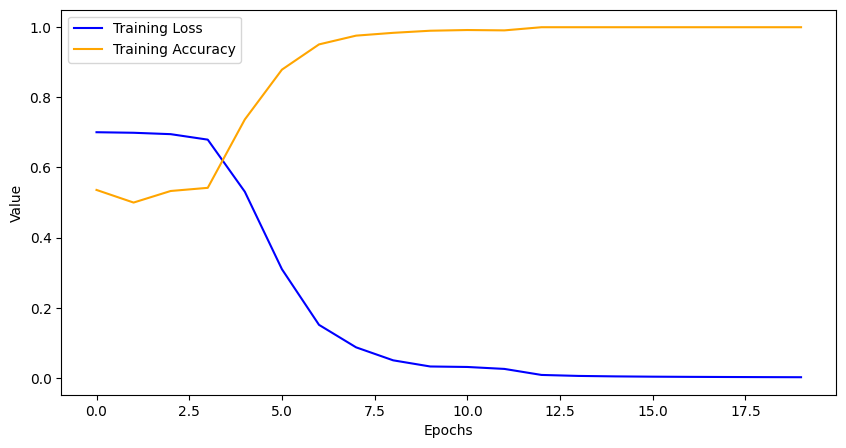

In [147]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10, 5))

# Plot Training Loss
plt.plot(loss, label='Training Loss', color='blue')

# Plot Training Accuracy on the same plot
plt.plot(accs, label='Training Accuracy', color='orange')

# Label the axes
plt.xlabel('Epochs')
plt.ylabel('Value')

# Add a legend to differentiate between the two
plt.legend()

# Show the plot
plt.show()


In [148]:
#Evaluate on test set
device = "cuda"
gold , predictions = evaluate_model(modelFF, dataloader_test)

100%|██████████| 63/63 [00:00<00:00, 461.77it/s]

Accuracy: 0.8
Precision: 0.7439446366782007
Recall: 0.8921161825726142
F1: 0.8113207547169811


## Optionnel: comparaison avec un LSTM

**Remplacez le modèle FF par un LSTM qui définira un embedding pour chaque mot du vocabulaire (en utilisant cette fois le module nn.Embedding)**

Vous pouvez reprendre le squelette ci-dessous

In [36]:
import torch
import torch.nn as nn

class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_hidden_dim, output_dim):
        super(LSTM_Model, self).__init__()
        self.emb_layer = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden_dim, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)  # output_dim should be 1 for binary classification
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary output

    def forward(self, input):
        embedded = self.emb_layer(input)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])  # Get the output from the last LSTM timestep
        out = self.sigmoid(out)  # Apply Sigmoid activation to the output
        return out


In [37]:
# créer le modèle + entrainement + eval sur test
model=LSTM_Model(vocab_size, best_params['embed_dim'], best_params['hidden_dim'], 2 )
model.to(device)
dataloader_train = DataLoader(encoded_train, batch_size=best_params['batch_size'])
dataloader_test = DataLoader(encoded_test, batch_size=best_params['batch_size'])
accs, loss = training(model, dataloader_train, torch.optim.AdamW(model.parameters(), lr=best_params['lr']), num_epochs=best_params['epochs'], device="cuda")


epoch:   5%|▌         | 1/20 [00:02<00:40,  2.13s/it]

Epoch: 0. Loss: 0.6945314202308654. Accuracy: 0.507



epoch:  10%|█         | 2/20 [00:03<00:29,  1.62s/it]

Epoch: 1. Loss: 0.693294536113739. Accuracy: 0.521



epoch:  15%|█▌        | 3/20 [00:04<00:22,  1.32s/it]

Epoch: 2. Loss: 0.692752724647522. Accuracy: 0.521



epoch:  20%|██        | 4/20 [00:05<00:18,  1.18s/it]

Epoch: 3. Loss: 0.6925848150253295. Accuracy: 0.521



epoch:  25%|██▌       | 5/20 [00:06<00:16,  1.10s/it]

Epoch: 4. Loss: 0.6925236330032348. Accuracy: 0.521



epoch:  30%|███       | 6/20 [00:07<00:14,  1.06s/it]

Epoch: 5. Loss: 0.6923633756637573. Accuracy: 0.521



epoch:  35%|███▌      | 7/20 [00:08<00:13,  1.03s/it]

Epoch: 6. Loss: 0.6921841721534729. Accuracy: 0.521



epoch:  40%|████      | 8/20 [00:09<00:12,  1.01s/it]

Epoch: 7. Loss: 0.6921597537994385. Accuracy: 0.521



epoch:  45%|████▌     | 9/20 [00:10<00:11,  1.01s/it]

Epoch: 8. Loss: 0.6921488075256348. Accuracy: 0.521



epoch:  50%|█████     | 10/20 [00:11<00:10,  1.01s/it]

Epoch: 9. Loss: 0.6921438736915588. Accuracy: 0.521



epoch:  55%|█████▌    | 11/20 [00:12<00:09,  1.02s/it]

Epoch: 10. Loss: 0.6921394453048706. Accuracy: 0.521



epoch:  60%|██████    | 12/20 [00:13<00:08,  1.01s/it]

Epoch: 11. Loss: 0.692136682510376. Accuracy: 0.521



epoch:  65%|██████▌   | 13/20 [00:14<00:07,  1.01s/it]

Epoch: 12. Loss: 0.6921338677406311. Accuracy: 0.521



epoch:  70%|███████   | 14/20 [00:15<00:06,  1.02s/it]

Epoch: 13. Loss: 0.692132137298584. Accuracy: 0.521



epoch:  75%|███████▌  | 15/20 [00:16<00:05,  1.02s/it]

Epoch: 14. Loss: 0.6921301417350769. Accuracy: 0.521



epoch:  80%|████████  | 16/20 [00:17<00:04,  1.03s/it]

Epoch: 15. Loss: 0.692128954410553. Accuracy: 0.521



epoch:  85%|████████▌ | 17/20 [00:18<00:03,  1.02s/it]

Epoch: 16. Loss: 0.6921275053024292. Accuracy: 0.521



epoch:  90%|█████████ | 18/20 [00:19<00:02,  1.02s/it]

Epoch: 17. Loss: 0.6921266775131225. Accuracy: 0.521



epoch:  95%|█████████▌| 19/20 [00:20<00:01,  1.03s/it]

Epoch: 18. Loss: 0.6921255826950073. Accuracy: 0.521



epoch: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]

Epoch: 19. Loss: 0.6921249370574951. Accuracy: 0.521


# 3. Fine-tuning d'un modèle contextuel préentrainé

1.   List item
2.   List item



Cette fois on va juste continuer l'entrainement d'un modèle préentrainé, sur nos données spécifiques, en utilisant une librarie dédiée, huggingface, qui gère tout depuis la tokenization, entrainement et prédiction.

**Dans cette partie tout le code est déjà fonctionnel (sauf pour faire les prédictions sur le test), mais vous devez trouver les meilleurs choix de paramètres**

In [38]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00


In [39]:
import transformers
import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModelForTokenClassification

In [120]:
# plus prudent avec un petit modele, mais vous pouvez essayer avec bert-base-uncased aussi
base_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForSequenceClassification.from_pretrained(base_model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Différentes options peuvent être testées pour la tokenization.
**Regardez la doc du tokenizer pour éventuellement changer la stratégie de padding et de troncation, et dites si vous voyez des changements de résultats expérimentaux**

In [121]:
# c'est ici qu'on définit ce qui sera effectivement passé en entrée du modèle à partir des instances du dataset
padding = [True, "max_length", "do_not_pad"] #do_not_pad cause des erreurs


#max_length - true ->   #0.34, 089 (validation-loss, accuracy)


#true-true meilleur #0.26-0.91

#True - False - erreur
#true - only-first -> validation loss 0.35 - 0.86


#max_length - false -> erreur
#max_length - only_first -> validation loss 0.41 - 0.84




truncation=[True, False, "only_first", "only_second"]#pas d'only second
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)


tokenized_train_datasets = dataset_train.map(tokenize_function, batched=True)
tokenized_test_datasets = dataset_test.map(tokenize_function, batched=True)

Huggingface permet de définir une boucle d'entrainement à partir de certains paramètres de configuration.

Voici une base, **vous pouvez chercher des réglages différents**

https://huggingface.co/docs/transformers/main_classes/trainer



In [122]:
from transformers import TrainingArguments, Trainer, get_scheduler, AdamW, EarlyStoppingCallback

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  # Increase weight decay for stronger regularization

# Learning Rate Scheduler
total_steps = len(tokenized_train_datasets) // 8 * 10  # Adjust for batch size and epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=total_steps // 10, num_training_steps=total_steps)

# Training Arguments
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",# Evaluate more frequently
    eval_steps=100,
    report_to="none",             # Disable reporting
    num_train_epochs=5,
    load_best_model_at_end=True,  # Save the best model during training
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # Save the best model during training
    warmup_steps=total_steps // 10,  # Warm-up step for the scheduler
)

# Add Early Stopping Callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.01
)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [123]:
# définition de la métrique d'éval
# NE RIEN MODIFIER ICI

# necessary for evaluation during training
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [124]:
# Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_test_datasets,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler),
    callbacks=[early_stopping],  # Add early stopping to callbacks
)


<ipython-input-124-0768c0c7ae5c>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [125]:
# necessary on colab -> NE RIEN MODIFIER ICI
# Tell the Trainer to not pin memory / caused by having the data already on GPU
training_args.dataloader_pin_memory = False

res = trainer.train()
print(res)

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.624004,0.784000
2,No log,0.317627,0.864000
3,No log,0.251564,0.916000
4,0.389600,0.300391,0.906000
5,0.389600,0.382921,0.900000


TrainOutput(global_step=625, training_loss=0.3303176528930664, metrics={'train_runtime': 329.53, 'train_samples_per_second': 15.173, 'train_steps_per_second': 1.897, 'total_flos': 662336993280000.0, 'train_loss': 0.3303176528930664, 'epoch': 5.0})


In [126]:
# test predictions sur un exemple
inputs = tokenizer("This movie was so bad it was almost good.", return_tensors="pt").to(device)
outputs = model(**inputs)
# get the normalized scores
list(nn.Softmax(dim=1)(outputs.logits).detach().cpu().numpy()[0])

[0.95427036, 0.045729674]

In [127]:
# test predictions sur un exemple
inputs = tokenizer("This movie was so good", return_tensors="pt").to(device)
outputs = model(**inputs)
# get the normalized scores
list(nn.Softmax(dim=1)(outputs.logits).detach().cpu().numpy()[0])

[0.10802183, 0.8919782]

In [128]:
# get the most likely class
np.argmax(outputs.logits.detach().cpu(),axis=-1)

tensor([1])

On peut regarder les prédictions du modèles, et les scores assignées à chaque classe pour chaque instance:

In [129]:
input_test = tokenized_test_datasets
predictions = trainer.predict(input_test)

In [130]:
predictions.metrics

{'test_loss': 0.25156405568122864,
 'test_accuracy': 0.916,
 'test_runtime': 7.8873,
 'test_samples_per_second': 63.393,
 'test_steps_per_second': 7.988}

In [131]:
predictions.predictions.shape

(500, 2)

In [132]:
torch_logits = torch.from_numpy(predictions.predictions)
probabilities_scores = F.softmax(torch_logits,dim=1).numpy()

(array([[177.,  17.,   7.,   5.,   9.,   8.,   1.,   4.,   4.,   0.,   2.,
           2.,   7.,   3.,   7.,   2.,  12.,   8.,  17., 208.],
        [208.,  17.,   8.,  12.,   2.,   7.,   3.,   7.,   2.,   2.,   0.,
           4.,   4.,   1.,   8.,   9.,   5.,   7.,  17., 177.]]),
 array([0.01932753, 0.06739478, 0.11546203, 0.16352928, 0.21159653,
        0.25966379, 0.30773103, 0.35579827, 0.40386555, 0.45193279,
        0.50000006, 0.54806727, 0.59613454, 0.64420176, 0.69226903,
        0.7403363 , 0.78840351, 0.83647078, 0.88453805, 0.93260527,
        0.98067254]),
 <a list of 2 BarContainer objects>)

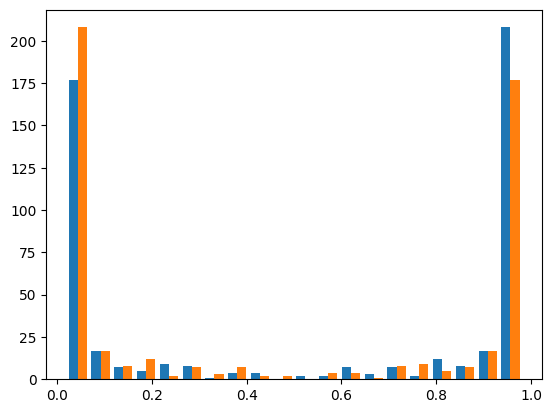

In [133]:
plt.hist(probabilities_scores,20)

**Que peut-on dire des probablités des prédictions du modèle ?**

Les probabilités indiquent que le modèle est très confiant dans la plupart de ses prédictions, avec une forte concentration près de 0 et 1, ce qui est un signe positif pour un model bien entraîné. La distribution suggère que les deux classes sont bien représentées, mais les échantillons avec des probabilités proches de 0,5 mettent en évidence les zones où le modèle est moins certain, ce qui pourrait entraîner des erreurs de classification. Ces prédictions incertaines peuvent refléter des cas d'ironie ou de sarcasme.